In [ ]:
import re
import os
import ast
import glob
import torch
import librosa
import webrtcvad
import matplotlib
import torchaudio
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from datasets import load_dataset
from sklearn.manifold import TSNE
from difflib import SequenceMatcher
from matplotlib.patches import ConnectionPatch
from whisper.normalizers import EnglishTextNormalizer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from scipy.stats import pearsonr, spearmanr, ttest_rel, wilcoxon, shapiro, mannwhitneyu
from Model.Model import Whisper
from utils.language_map import accent_map, language_family_dict, LanguageDist
from utils.language_map import language_family_dict, accent_map

In [ ]:
def walkthrough(audio_files, audio_dir, meta):
    audio_extensions = {".mp3", ".wav", ".m4a", ".aac", ".flac", ".ogg", ".wma"}
    audio_data = []
    for file in audio_files:
        file_extension = Path(file).suffix.lower()
        if file_extension in audio_extensions:
            file_path = os.path.join(audio_dir,file)
            y, sr = librosa.load(file_path)
            duration = len(y) / sr
            if (duration < 0.1):
                print(f"{file} Less than 0 sec")
            else:
                if not meta[meta['id']==file[:-4]].empty:
                    audio_data.append([file[:-4]])

    return pd.DataFrame(audio_data, columns=["id"])

def extract_age(age_sex):
    try:
        # Using regex to find the age before the comma
        age_match = re.search(r"(\d+)", age_sex)  # \d+ matches one or more digits
        
        if age_match:
            return age_match.group(1)  # Return the first matched group (age)
        return None  # If no match is found, return None
    except Exception as e:
        print(f"Error while extracting age: {e}")
        return None
path = 'Data/speech-accent-archive'
audio_dir = os.path.join(path, 'audio')
audio_files = os.listdir(audio_dir)
meta_saa = pd.read_csv(os.path.join(path, 'bio.csv'))

meta_saa.rename(columns={'filename': 'id'}, inplace=True)
meta_saa['age'] = meta_saa['age_sex'].apply(lambda x: int(extract_age(x)))
meta_saa = meta_saa.dropna(subset=['age', 'sex', 'native_language', 'birth_place'])


audio_df = walkthrough(audio_files, audio_dir, meta_saa)

meta_saa = meta_saa.drop(columns=['href'])
meta_saa['native_language'] = meta_saa['native_language'].apply(lambda x: x.split('\n')[0])
meta_saa['sex'] = meta_saa['sex'].replace('famale', 'female')
saa_df = pd.merge(meta_saa, audio_df ,  on='id', how="inner")

# Remove data less than 8 
language_counts = saa_df["native_language"].value_counts()

languages_to_keep = language_counts[language_counts >=  30].index
saa_df = saa_df[saa_df['native_language'].isin(languages_to_keep)]

# # Create the age groups
bins = [0, 13, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Define the bin ranges
labels = ['Children', 'teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies','eighties', 'nineties']  # Labels for bins

saa_df['age_group'] = pd.cut(saa_df['age'], bins=bins, labels=labels, right=False)

# 2 Data distribution

In [28]:
validated = pd.read_csv(
    "/Users/tinghui/Downloads/cv-corpus-5.1-2020-06-22/en/validated.tsv",
    sep='\t',
    usecols=["client_id"]
)



edacc = load_dataset("edinburghcstr/edacc")

print("Size for CV: ", len(validated), "EdACC: ", len(edacc['validation'])+len(edacc['test']) , "SSA:", len(meta_saa))

print('SSA, language counts:', len(meta_saa['native_language'].unique()))
all_l1 = edacc['validation']['l1'] + edacc['test']['l1']

l1_series = pd.Series(all_l1)
mask = ~l1_series.str.lower().str.contains("english")
filtered_l1_series = l1_series[mask]
counts = filtered_l1_series.value_counts()

Size for CV:  1085494 EdACC:  19137 SSA: 3035
SSA, language counts: 227


/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_20566/753197189.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_gender_counts = saa_df.groupby(['age_group', 'sex']).size().unstack(fill_value=0)


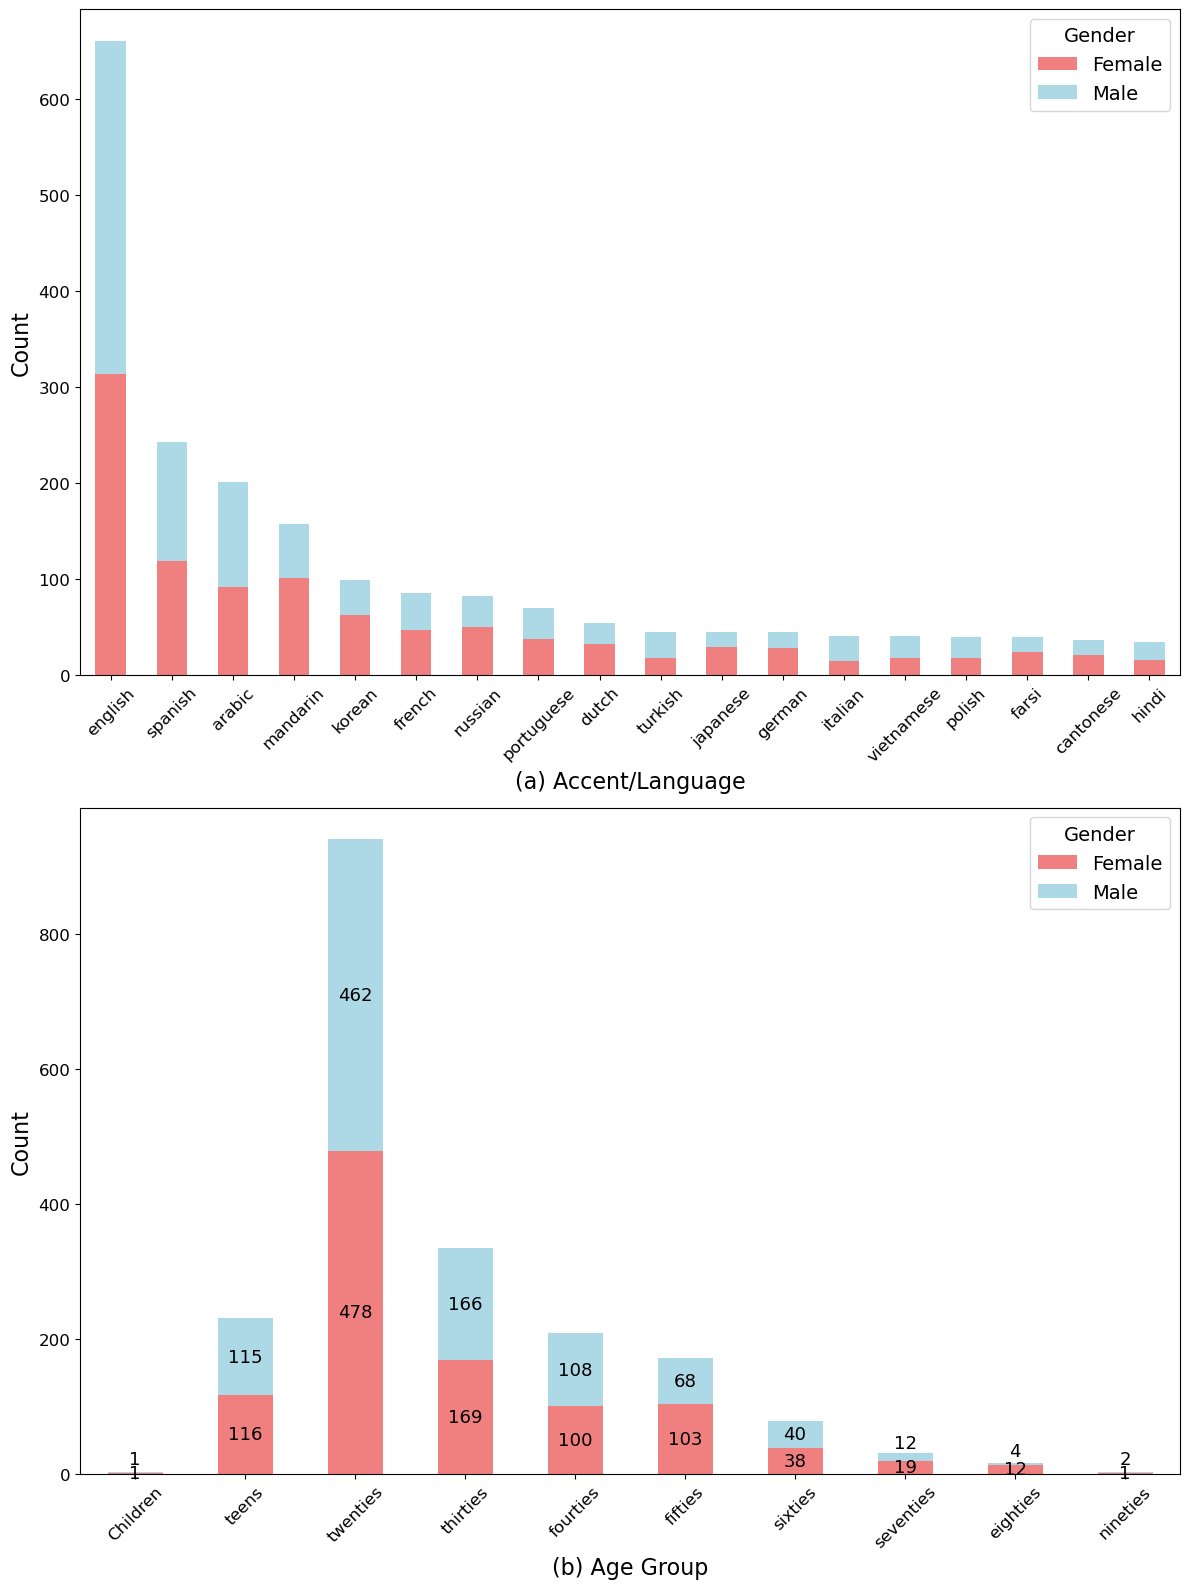

In [ ]:
# Group by Language and Gender
gender_by_accent = saa_df.groupby(['native_language', 'sex']).size().unstack(fill_value=0)

# Sort Accent/Gender by total count
gender_by_accent = gender_by_accent.loc[gender_by_accent.sum(axis=1).sort_values(ascending=False).index]

# Create the subplot (2 plots, 1 row, 2 columns)
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Gender Distribution by Accent/Language
gender_by_accent.plot(kind='bar', stacked=True, color=['lightcoral','lightblue'], ax=axes[0])
axes[0].tick_params(axis='y', labelsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].set_xlabel('(a) Accent/Language',fontsize=16)
axes[0].set_ylabel('Count', fontsize=16)
axes[0].legend(title='Gender', labels=['Female', 'Male'], loc='upper right',title_fontsize=14, fontsize=14)
axes[0].grid(False)
age_gender_counts = saa_df.groupby(['age_group', 'sex']).size().unstack(fill_value=0)

# Gender Distribution by Age Group
ax = age_gender_counts.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'], ax=axes[1])

# Annotate percentages on the bars for the second plot
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()    
    x, y = p.get_xy()       

    if height == 0:
        continue
    
    # Calculate the percentage for the current bar segment
    total_height = sum([patch.get_height() for patch in ax.patches if patch.get_x() == p.get_x()])
    percentage = (height / total_height) * 100  
    
    # Adjust annotation y position for different genders
    if p.get_facecolor() == (0.6784313725490196, 0.8470588235294118, 0.9019607843137255, 1.0) and (x <0.74 or x >5.75):  
        y_position = y + height / 2  +20
    else: 
        y_position = y + height / 2 

    # Annotate the percentage on the plot
    ax.annotate(f'{int(height)}', (x + width / 2, y_position),
                ha='center', va='center', fontsize=13, color='black')

# Customize the second plot appearance
ax.set_xlabel('(b) Age Group', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=12)  # Rotate x labels
ax.legend(title='Gender', fontsize=14, title_fontsize=14, labels=['Female', 'Male'], loc='upper right')
ax.grid(False)
plt.savefig(f"plot/data_analysis/ssa_distribution.pdf")

plt.tight_layout()
plt.show()


In [4]:
output_df = pd.read_csv('results/baseline/eva_small.csv')
result_small = pd.merge(output_df, saa_df,   on='id', how="left")
script_df = pd.read_csv('results/baseline/small.csv')
result_small = pd.merge(script_df , result_small,   on='id', how="left")

output_df = pd.read_csv('results/baseline/eva_large.csv')
result_ssa3 = pd.merge(output_df, saa_df,   on='id', how="left")

output_df = pd.read_csv('results/baseline/eva_google.csv')
result_ssa = pd.merge(output_df, saa_df,   on='id', how="left")

# 4.1.1 Metrics Performance Analysis

In [ ]:
def get_word_diffs(ref, hyp):
    ref_words = ref.split()
    hyp_words = hyp.split()
    matcher = SequenceMatcher(None, ref_words, hyp_words)
    added = []
    removed = []
    replaced = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'insert':
            added.extend(hyp_words[j1:j2])
        elif tag == 'delete':
            removed.extend(ref_words[i1:i2])
        elif tag == 'replace':
            replaced.append((ref_words[i1:i2], hyp_words[j1:j2]))
    return removed, added, replaced

ref = EnglishTextNormalizer()("Please call Stella. Ask her to bring these things with her from the store: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.")
ids = ['english156', 'english253', "portuguese44", "farsi15", "korean58"]
for idx in ids:
    row = result_small[result_small['id'] == idx]
    hyp = EnglishTextNormalizer()(row['prediction'].values[0])
    removed, added, replaced = get_word_diffs(ref, hyp)
    print(f"WER: {row['WER'].values[0]}, CER: {row['CER'].values[0]}, MER: {row['MER'].values[0]}, WIL: {row['WIL'].values[0]}, Ember: {row['Ember'].values[0]}, SemDist: {round(row['SemDist'].values[0],3)}, Removed words: {removed}, Added words: {added}, Replaced words:{replaced}")
    

WER: 1.449, CER: 0.904, MER: 1.429, WIL: 1.429, Ember: 1.429, SemDist: 0.787, Removed words: [], Added words: ['to'], Replaced words:[]
WER: 1.449, CER: 0.602, MER: 1.429, WIL: 1.429, Ember: 1.429, SemDist: 1.347, Removed words: [], Added words: ['i'], Replaced words:[]
WER: 1.449, CER: 0.602, MER: 1.449, WIL: 2.878, Ember: 0.145, SemDist: 0.799, Removed words: [], Added words: [], Replaced words:[(['the'], ['this'])]
WER: 1.449, CER: 0.602, MER: 1.449, WIL: 1.449, Ember: 1.449, SemDist: 1.037, Removed words: ['a'], Added words: [], Replaced words:[]
WER: 1.449, CER: 0.602, MER: 1.449, WIL: 2.878, Ember: 1.449, SemDist: 2.414, Removed words: [], Added words: [], Replaced words:[(['red'], ['bread'])]


# 4.1.2 L1L2 Comparison

<Figure size 600x800 with 0 Axes>

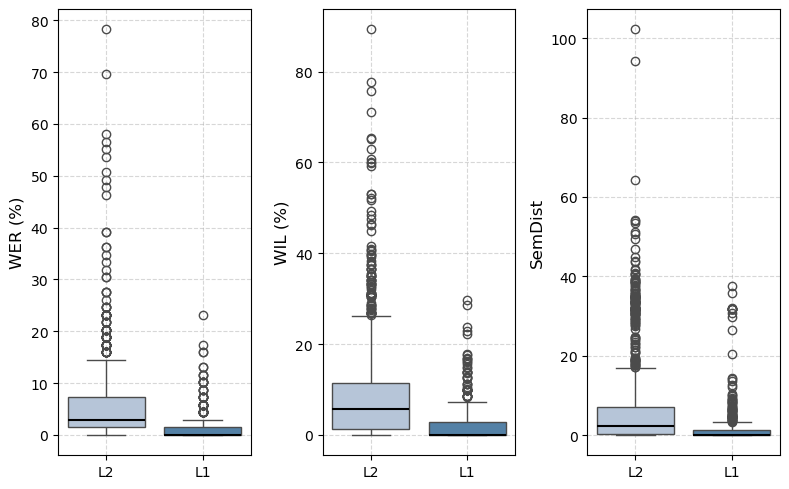

In [ ]:
result_small["language_group"] = result_small["native_language"].apply(
    lambda x: "L1" if x.lower() == "english" else "L2"
)
grouped_df = result_small.groupby(["language_group"]).agg(
    Mean_WER=("WER", "mean"),  
    Std_WER=("WER", "std"),   
    # Mean_CER=("CER", "mean"),   
    # Std_CER=("CER", "std"),  
    Mean_WIL=("WIL", "mean"),   
    Std_WIL=("WIL", "std"),   
    # Mean_MER=("MER", "mean"),  
    # Std_MER=("MER", "std"),  
    # Mean_Ember=("Ember", "mean"),   
    # Std_Ember=("Ember", "std"),   
    Mean_SemDist=("SemDist", "mean"),  
    Std_SemDist=("SemDist", "std"),  
    Count=("id", "count")      
).reset_index()

plt.figure(figsize=(6, 8))
palette = {
    "L1": "steelblue",       
    "L2": "lightsteelblue"   
}
median_props = {
    "color": "black",    
    "linewidth": 1.5   
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,5), sharex=True)
metrics = ["WER",
        #    "CER", 
        #    "MER", 
           "WIL", 
        #    "Ember", 
           "SemDist"]
for ax, metric in zip(axes, metrics):
    sns.boxplot(
        data=result_small,
        x="language_group",
        y=metric,
        hue="language_group",             
        palette=palette,
        medianprops=median_props,
        ax=ax,
        legend=False                     
    )
    if metric != "SemDist":
        text = f"{metric} (%)"
    else:
        text = metric
    ax.set_xlabel("")  
    ax.set_ylabel(text, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.5)

# # Add x-label to bottom subplot only
plt.tight_layout()
plt.savefig("plot/bias/L1L2_difference.pdf")
plt.show()


In [ ]:
# Compared different age groups performance mean
grouped = result_small.groupby(["age_group"])[['WER', 'WIL', 'SemDist']].mean().round(3)
grouped

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/1284568450.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = result_small.groupby(["age_group"])[['WER', 'WIL', 'SemDist']].mean().round(3)


WER     WIL  SemDist
age_group                         
Children   13.768  19.187   22.522
teens       3.658   6.070    5.036
twenties    4.217   6.970    5.237
thirties    3.565   5.766    4.454
fourties    4.034   6.550    5.125
fifties     3.373   5.475    4.184
sixties     3.846   6.046    4.034
seventies   2.992   5.098    2.564
eighties    3.714   6.604    5.211
nineties    1.932   2.830    1.738

# 4.1.2 Per Language

In [ ]:
for metric in ["WER", "WIL", "SemDist"]:
    # Extract groups
    native = result_small[result_small['native_language'].str.lower() == 'english'][metric].dropna()
    nonnative = result_small[result_small['native_language'].str.lower() != 'english'][metric].dropna()

    # Step 1: Test for normality
    shapiro_native = shapiro(native)
    shapiro_nonnative = shapiro(nonnative)

    native_is_normal = shapiro_native.pvalue > 0.05
    nonnative_is_normal = shapiro_nonnative.pvalue > 0.05

    # Step 2: Choose test based on normality
    if native_is_normal and nonnative_is_normal:
        # Both are normal → use Welch's t-test
        test_stat, p_val = ttest_ind(native, nonnative, equal_var=False)
        test_name = "Welch’s t-test (independent)"
    else:
        # At least one is not normal → use Mann–Whitney U test
        test_stat, p_val = mannwhitneyu(native, nonnative, alternative="two-sided")
        test_name = "Mann–Whitney U test"

    print(metric)
    print(f"Normality p-values: Native={shapiro_native.pvalue:.4f}, Non-native={shapiro_nonnative.pvalue:.2e}")
    print(f"{test_name} Test Statistic = {test_stat:.3f}, p-value = {p_val:.2e}")
    print(f"Mean Diff (Non-native - Native): {nonnative.mean() - native.mean():.3f} Native Mean = {native.mean():.3f}, Non-native Mean = {nonnative.mean():.3f}")


WER
Normality p-values: Native=0.0000, Non-native=8.24e-46
Mann–Whitney U test Test Statistic = 215704.000, p-value = 1.09e-84
Mean Diff (Non-native - Native): 4.086 Native Mean = 1.177, Non-native Mean = 5.263
WIL
Normality p-values: Native=0.0000, Non-native=5.94e-41
Mann–Whitney U test Test Statistic = 209802.500, p-value = 1.87e-88
Mean Diff (Non-native - Native): 6.845 Native Mean = 1.836, Non-native Mean = 8.680
SemDist
Normality p-values: Native=0.0000, Non-native=4.64e-47
Mann–Whitney U test Test Statistic = 228017.000, p-value = 1.43e-75
Mean Diff (Non-native - Native): 5.003 Native Mean = 1.545, Non-native Mean = 6.548


In [ ]:
# Full Table for mean and std for different languages and gender groups
print(f"English: oldest {result_small[result_small['native_language'] == 'english']['age'].max()}, youngest {result_small[result_small['native_language'] == 'english']['age'].min()}")
print(f"English: oldest {result_small[result_small['native_language'] == 'dutch']['age'].max()}, youngest {result_small[result_small['native_language'] == 'dutch']['age'].min()}")

grouped = (
    result_small
    .groupby(["native_language", "sex"])
    .agg({
        "WER": ["mean", "std"],
        "WIL": ["mean", "std"],
        "SemDist": ["mean", "std"]
    })
)
grouped.columns = [f"{metric}_{stat}" for metric, stat in grouped.columns]
lang_means = result_small.groupby("native_language")["WER"].mean()
sorted_langs = lang_means.sort_values().index
grouped = grouped.loc[sorted_langs]


grouped = grouped.round(2)
grouped

English: oldest 93, youngest 6
English: oldest 68, youngest 18


WER_mean  WER_std  WIL_mean  WIL_std  SemDist_mean  \
native_language sex                                                          
dutch           female      0.86     1.10      1.57     1.94          0.86   
                male        1.58     1.73      2.78     3.24          1.62   
english         female      0.98     1.99      1.53     3.18          1.37   
                male        1.36     2.83      2.11     4.33          1.70   
hindi           female      1.35     1.85      2.28     3.29          2.75   
                male        1.98     2.95      3.25     5.10          1.54   
german          female      2.12     2.83      3.57     5.04          5.26   
                male        3.07     4.64      5.26     7.80          6.46   
french          female      2.71     3.21      4.59     5.66          5.02   
                male        3.59     3.85      6.08     6.68          5.07   
japanese        female      3.35     3.99      5.93     7.17          5.89   
                male        4.26     4.72      7.50     8.24          9.53   
polish          female      3.54     4.51      6.53     8.24          3.89   
                male        3.80     5.15      6.72     9.11          5.30   
portuguese      female      3.72     8.84      5.85    11.93          3.05   
                male        4.04     4.16      6.95     7.20         10.27   
russian         female      3.97     5.45      6.50     8.15          7.17   
                male        3.80     3.73      6.63     6.65          4.36   
farsi           female      3.32     3.59      6.01     6.28          3.01   
                male        5.89     9.71      8.85    13.40          7.59   
korean          female      4.60     4.86      7.68     8.12          4.52   
                male        4.74     4.64      8.19     8.04          8.49   
italian         female      4.87     4.78      8.13     8.17          8.05   
                male        4.79     4.67      8.28     8.16          6.28   
turkish         female      6.39     7.34     11.05    12.73          7.81   
                male        5.64     4.49      9.71     7.78          5.33   
arabic          female      5.51     6.64      8.73     9.90          6.32   
                male        6.79     9.06     10.59    12.31          7.52   
spanish         female      7.19    11.65     11.03    15.34          7.11   
                male        5.65     9.09      8.97    12.63          6.52   
mandarin        female      7.10     5.58     12.26     9.26         10.31   
                male        7.61     6.25     13.25    10.88         10.48   
cantonese       female      7.66     6.94     13.20    11.30          4.54   
                male        7.34     7.64     12.78    12.57          9.19   
vietnamese      female      7.73     5.73     13.25     9.74          7.49   
                male       12.98    14.44     20.90    20.26          9.06   

                        SemDist_std  
native_language sex                  
dutch           female         1.26  
                male           2.19  
english         female         4.54  
                male           4.84  
hindi           female         8.19  
                male           2.22  
german          female         9.78  
                male          12.12  
french          female         8.18  
                male           8.13  
japanese        female        10.68  
                male          12.94  
polish          female         5.64  
                male           8.21  
portuguese      female         7.76  
                male          14.30  
russian         female        11.46  
                male           6.86  
farsi           female         7.68  
                male          12.20  
korean          female         7.10  
                male          12.59  
italian         female        10.17  
                male           7.77  
turkish         female        10.65  
                male           6.

# 4.1.2 Per Language group

In [ ]:
result_small["Language_Family"] = result_small["native_language"].map(language_family_dict)
result_small["LanguageDist"] = result_small["native_language"].map(LanguageDist)

mean_cer_scores = result_small.groupby(['Language_Family', 'sex'])['WER'].mean()
grouped_df = result_small.groupby(["Language_Family", "sex"]).agg(
    Mean_WER=("WER", "mean"),   # Calculate the mean of WER
    Mean_CER=("CER", "mean"),   # Calculate the mean of WER
    Mean_MER=("MER", "mean"),   # Calculate the mean of WER
    Mean_WIL=("WIL", "mean"),   # Calculate the mean of WER
    Mean_Ember=("Ember", "mean"),   # Calculate the mean of WER
    Mean_SemDist=("SemDist", "mean"),   # Calculate the mean of WER
    Count=("id", "count")       # Count number of speakers
).reset_index()
grouped_df

Language_Family     sex   Mean_WER  Mean_CER   Mean_MER   Mean_WIL  \
0     Afro-Asiatic  female   5.510451  3.187396   5.318242   8.730527   
1     Afro-Asiatic    male   6.785273  3.712991   6.473309  10.591464   
2   Austro-Asiatic  female   7.729444  3.848833   7.648000  13.246833   
3   Austro-Asiatic    male  12.977591  7.625909  12.533318  20.899955   
4    Indo-European  female   2.786437  1.612181   2.699216   4.456245   
5    Indo-European    male   2.852610  1.719122   2.789220   4.637754   
6          Japonic  female   3.348276  1.952586   3.346897   5.934931   
7          Japonic    male   4.257250  2.428437   4.208813   7.502313   
8         Koreanic  female   4.604968  2.584500   4.557710   7.678435   
9         Koreanic    male   4.739541  2.800378   4.691486   8.192676   
10    Sino-Tibetan  female   7.198869  4.066205   7.106311  12.420344   
11    Sino-Tibetan    male   7.552577  4.059887   7.505507  13.148620   
12          Turkic  female   6.393882  3.649882   6.343118  11.054765   
13          Turkic    male   5.641821  3.087393   5.592893   9.712357   

    Mean_Ember  Mean_SemDist  Count  
0     4.751989      6.322087     91  
1     5.920927      7.520914    110  
2     6.256333      7.485682     18  
3    10.509136      9.064784     22  
4     2.218105      3.517741    698  
5     2.316951      3.794703    694  
6     2.927069      5.893460     29  
7     3.293188      9.528546     16  
8     4.274274      4.519377     62  
9     3.962622      8.494789     37  
10    5.983869      9.320163    122  
11    6.013690     10.209436     71  
12    5.991294      7.806104     17  
13    4.979750      5.330146     28

In [ ]:
# Convert the string to an actual list
convert = {"africa":"southafrica" , 
            "arabia": "saudiarabia",
            "republic": "czechrepublic" ,
           "zealand": "newzealand",
            "man": "uk",
            "virginia": "usa",
            "York": "usa",
            "coast": "ivorycoast",
            "lanka": "srilanka",
            "salvador": "elsalvador",
            "rico": "puertorico",
            "rica": "costarica"
           }
def extract(birth_place_str):
    birth_place_list = ast.literal_eval(birth_place_str)

    # Extract the country part
    country = birth_place_list[-1].strip() 
    if country == "islands":
            return birth_place_list[0].strip() + " islands"

    return convert.get(country, country)  


/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:168: UserWarning: This figure includes Axes that are not compatible with ti

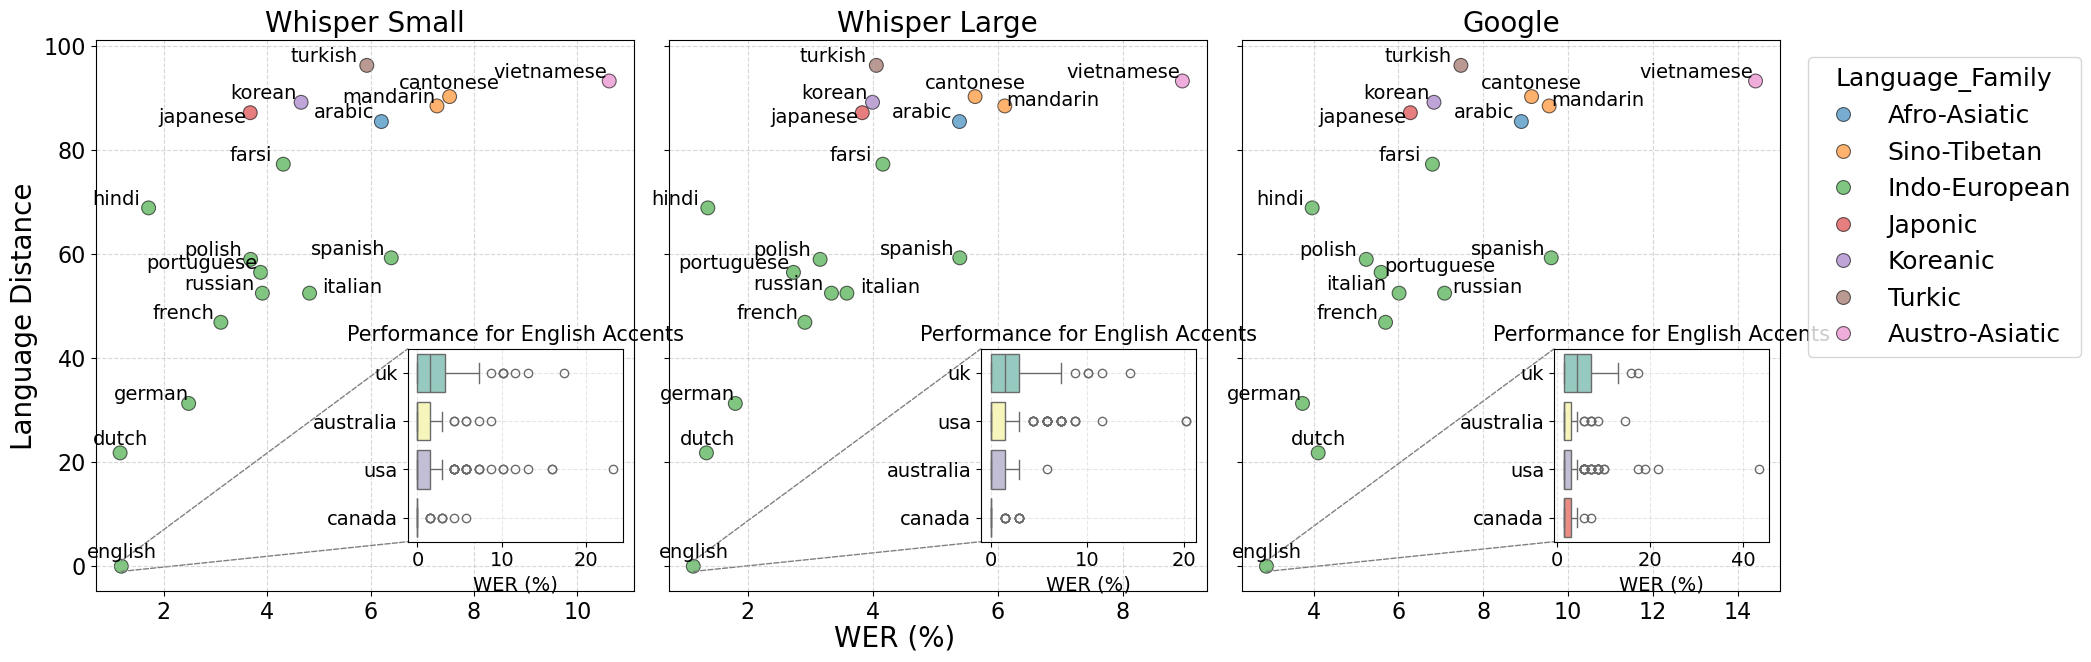

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:168: UserWarning: This figure includes Axes that are not compatible with ti

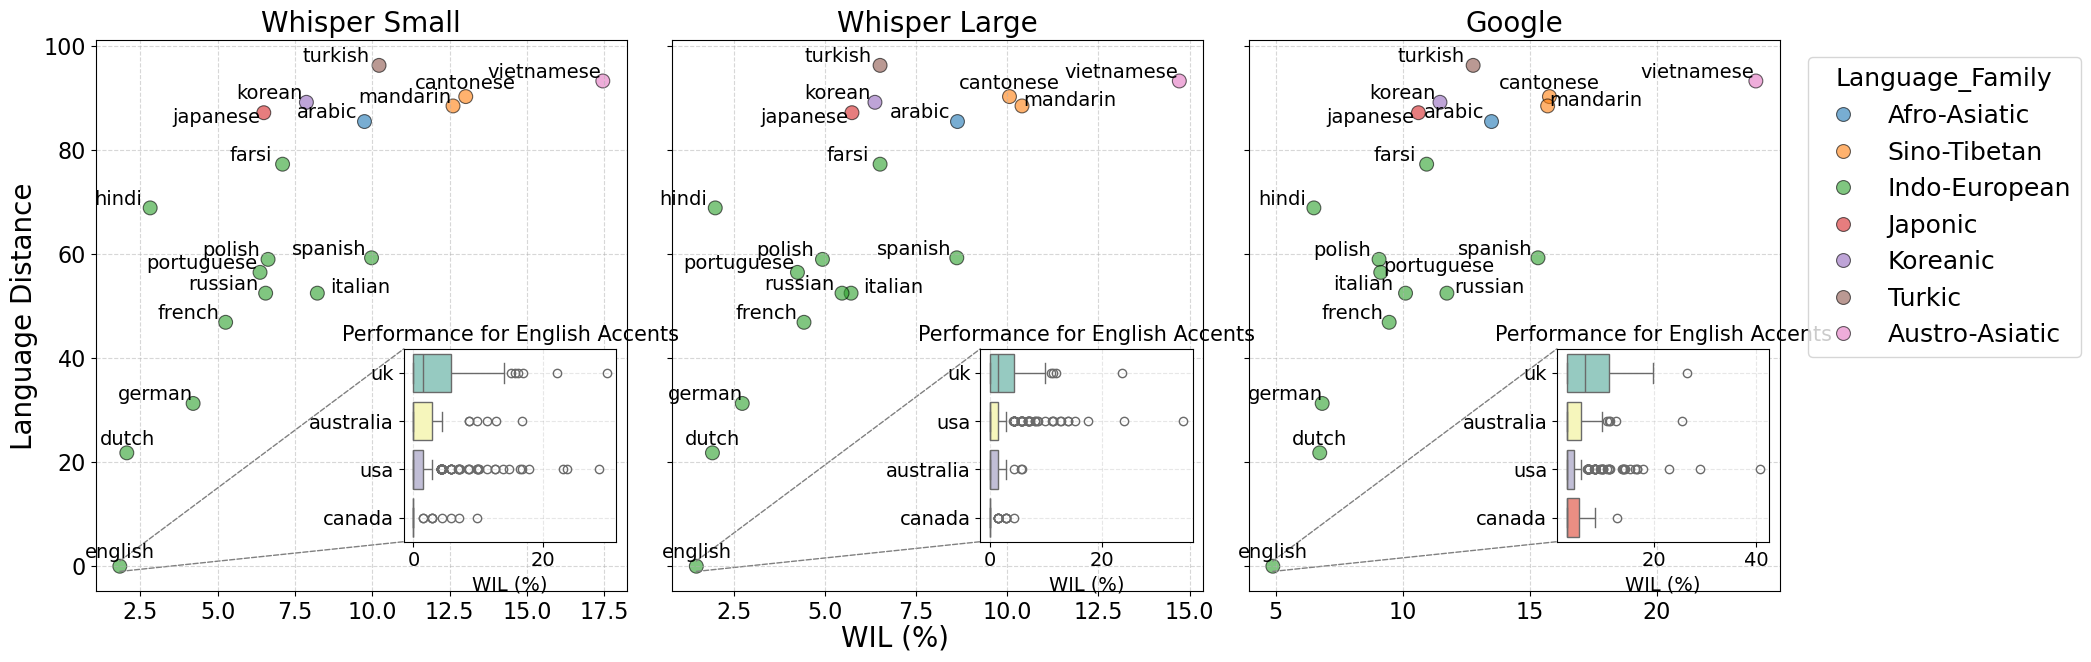

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/2901217530.py:168: UserWarning: This figure includes Axes that are not compatible with ti

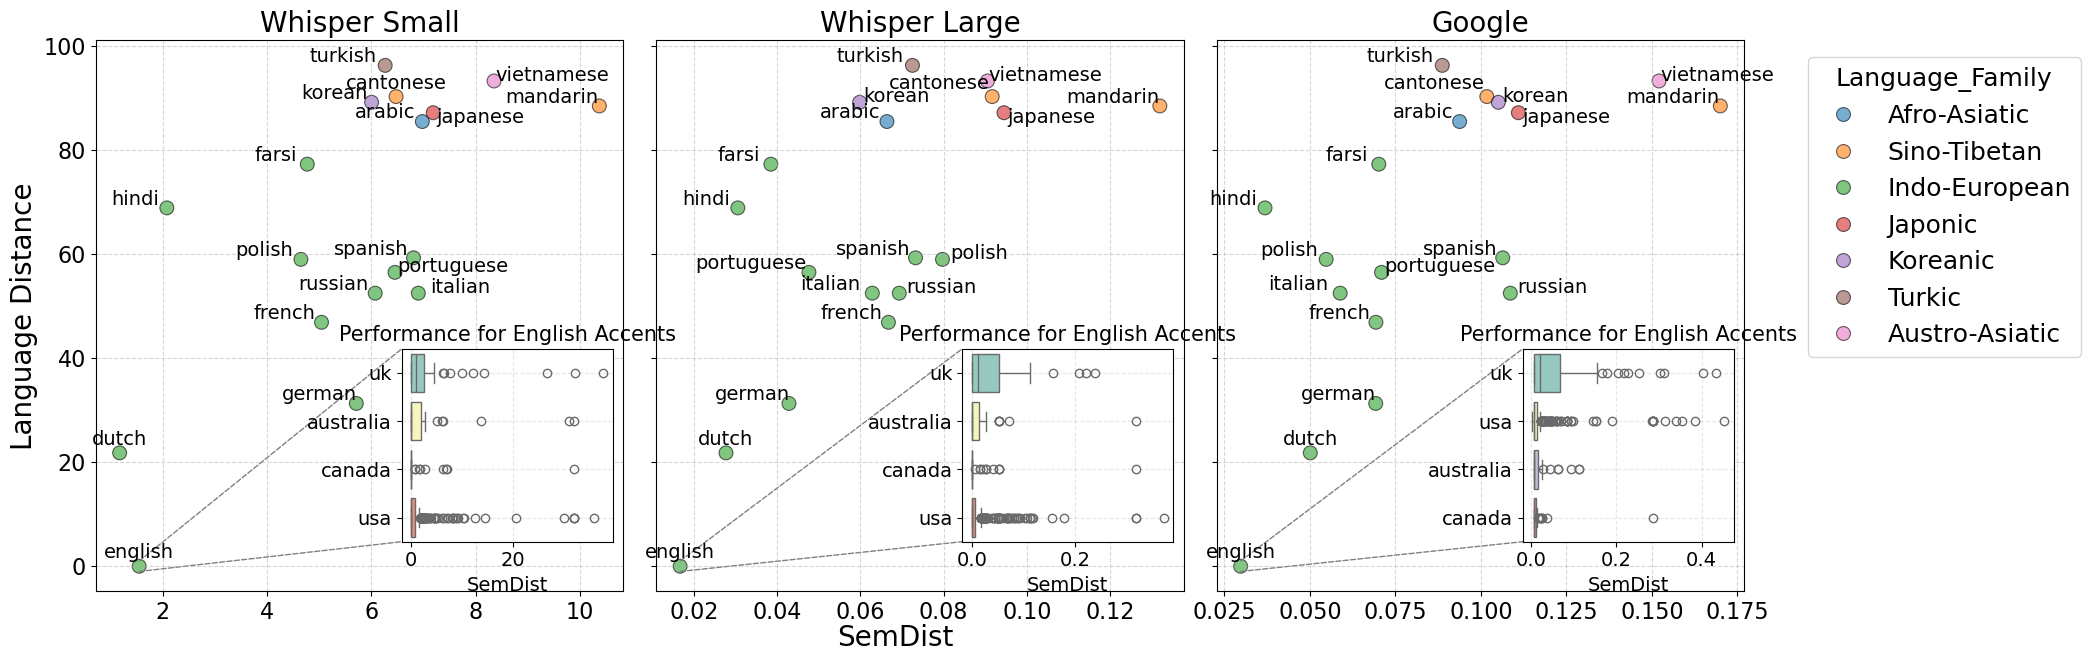

In [ ]:
data_list = [result_small, result_ssa3, result_ssa]
titles = ["Whisper Small",  "Whisper Large", "Google"]
ylabel = ["WER (%)", "WIL (%)", "SemDist"]

for k, metric in enumerate(['WER', 'WIL', 'SemDist']):
    fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)


    for i, (df, ax, title) in enumerate(zip(data_list, axes, titles)):
        df["Language_Family"] = df["native_language"].map(language_family_dict)
        df["LanguageDist"] = df["native_language"].map(LanguageDist)
        grouped_df = df.groupby([ "native_language", "Language_Family", "LanguageDist"]).agg(
            Mean=(metric, "mean"),   
            Std=(metric, "std"),  
            Count=("id", "count")     
        ).reset_index()

        # Collect all unique language families across datasets
        all_families = pd.concat(data_list)["Language_Family"].unique()
        palette = dict(zip(all_families, sns.color_palette("tab10", len(all_families))))
        if i == 0:
            ax.set_ylabel("Language Distance", fontsize=20)
            set_legend = True

        else:
            ax.set_ylabel("")
            set_legend = False

        axes[i] = sns.scatterplot(
            data=grouped_df,
            ax=ax,
            x="Mean",
            y="LanguageDist",
            hue="Language_Family",
            palette=palette,
            edgecolor="black",
            alpha=0.6,
            s=100,
            legend=set_legend  
        )
        x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
        offset = 0.01 * x_range  
        # Annotate points
        for j in range(len(grouped_df)):
            lang = grouped_df["native_language"].iloc[j]
            x = grouped_df["Mean"].iloc[j]
            y = grouped_df["LanguageDist"].iloc[j]
            y_offset = 0
            x_offset = 0
            # Adjust offsets based on language and index
            if (lang == 'italian' and i!=2 and (k==0 or k == 1)) or (lang== 'italian' and i ==0 and k ==2) \
                or (lang == 'mandarin'and k!=2 and i!=0) or (lang=='korean' and k==2 and i!=0) \
                or (lang == 'russian' and i==2) or (lang == 'russian' and i==1 and k==2) \
                or (lang=='polish' and k==2 and i==1 ) or (lang=='japanese' and k==2) \
                or (lang=='vietnamese' and k ==2) or (lang=='portuguese' and i ==2) \
                or (lang=='portuguese' and k ==2 and i==0):
                x_offset = offset *(len(lang)+1)
            elif (lang == 'cantonese'):
                y_offset = 1.5
            elif (lang=='english' and k!=2) or (lang=="dutch" and k!=2):
                x_offset = 0.01
                y_offset = 1.5
            elif (lang=='english' and k==2) or (lang=="dutch" and k==2):
                x_offset = 0
                y_offset = 1.5
            else: 
                x_offset = -offset*(len(lang)+1)
                y_offset = 0.6
            if (lang == 'japanese'):
                y_offset = -2
            if (lang == 'cantonese' and k==2 and i!= 0):
                x_offset = -offset *(len(lang)+1)
            ax.text(x + x_offset, y + y_offset, lang, fontsize=14, ha='center')

        english_df = df[df["native_language"] == "english"].copy()
        english_df["Country"] = english_df["birth_place"].apply(lambda x: extract(x))

        language_counts = english_df["Country"].value_counts()
        languages_to_keep = language_counts[language_counts >=  30].index
        english_df = english_df[english_df['Country'].isin(languages_to_keep)]
        ax_inset = inset_axes(
                        ax,
                        width="40%",
                        height="35%",
                        bbox_to_anchor=(-0.02, 0.09, 1, 1),  
                        loc='lower right',
                        bbox_transform=ax.transAxes,
                        borderpad=0  
                    )
        
        zoom_df = english_df.groupby(["Country"]).agg(
            Mean=(metric, "mean"),  
            Std=(metric, "std"),   
            Count=("id", "count")      
        ).reset_index()
        
        order = zoom_df.sort_values("Mean", ascending=False)["Country"]

        # Create boxplot
        sns.boxplot(
            data=english_df,
            y="Country",
            x=metric,
            order=order,
            palette="Set3",
            hue=None,        
            legend=False      
        )

        ax_inset.tick_params(labelsize=14)
        ax_inset.set_title("Performance for English Accents", fontsize=15)
        ax_inset.set_xlabel(ylabel[k], fontsize=14)
        ax_inset.set_ylabel("")
        ax_inset.grid(True, linestyle="--", alpha=0.3)

        x_min = grouped_df[grouped_df["native_language"] == "english"]["Mean"].min()
        x_max = grouped_df[grouped_df["native_language"] == "english"]["Mean"].max()
        y_mean = df[df["native_language"] == "english"]["LanguageDist"].mean()
        # Draw lines from main_ax to ax_inset
        con1 = ConnectionPatch(
            xyA=(x_min, y_mean - 1), coordsA=ax.transData,
            xyB=(0, 0), coordsB=ax_inset.transAxes,
            color="gray", linestyle="--", linewidth=1
        )
        con2 = ConnectionPatch(
            xyA=(x_max, y_mean + 1), coordsA=ax.transData,
            xyB=(0, 1), coordsB=ax_inset.transAxes,
            color="gray", linestyle="--", linewidth=1
        )

        ax.add_artist(con1)
        ax.add_artist(con2)

        ax.tick_params(labelsize=16)
        ax.set_title(title, fontsize=20)
        ax.set_xlabel("")

        if ax.get_legend(): 
            ax.get_legend().remove()
        ax.grid(True, linestyle="--", alpha=0.5)
    # Create a single shared legend
    handles, labels = axes[0].get_legend_handles_labels()


    legend =fig.legend(handles, labels, title="Language_Family",title_fontsize=18,
            loc='upper left', bbox_to_anchor=(1.0, 0.9),
            prop={'size': 18})
    shared_xlabel = fig.text(0.5, 0.04, ylabel[k], ha='center', fontsize=20)
    plt.tight_layout(rect=[0, 0.05, 1, 0.97])
    plt.savefig(f"plot/bias/{metric}_service_distance_comparison.pdf",bbox_extra_artists=(legend,shared_xlabel),
    bbox_inches="tight")
    plt.show()




## Embedding

In [ ]:
embeddings_dic = {}
# Load processor and model
model_type = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_type, language="en", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(model_type)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

sample_rate = 16000
chunk_duration = 25  
chunk_samples = sample_rate * chunk_duration
embeddings_dic = {}

for i, row in tqdm(saa_df.iterrows(), total=len(saa_df), desc="Processing"):
    file_id = row["id"]
    file_path = f"/Users/tinghui/workspace/github/Thesis/Data/speech-accent-archive/audio/{row['id']}.wav"
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

    try:
        y, sr = librosa.load(file_path, sr=sample_rate)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        continue

    total_length = len(y)
    num_chunks = (total_length + chunk_samples - 1) // chunk_samples 

    chunk_embeddings = []
    for split_idx in range(num_chunks):
        start_sample = split_idx * chunk_samples
        end_sample = min(start_sample + chunk_samples, total_length)
        audio_chunk = y[start_sample:end_sample]

        inputs = processor(audio_chunk, sampling_rate=sample_rate, return_tensors="pt")
        input_features = inputs.input_features.to(device)

        with torch.no_grad():
            encoder_outputs = model.model.encoder(input_features.squeeze(1))
        chunk_embedding = encoder_outputs.last_hidden_state.squeeze(0)  
        chunk_embeddings.append((split_idx, chunk_embedding.cpu()))

    # Merge embeddings
    if chunk_embeddings:
        sorted_chunks = sorted(chunk_embeddings, key=lambda x: x[0])
        
        full_embedding = torch.cat([emb for _, emb in sorted_chunks], dim=0)
        pooled = full_embedding.mean(dim=0)
        embeddings_dic[file_id] = pooled


Processing: 100%|██████████| 2015/2015 [29:24<00:00,  1.14it/s]


In [ ]:

result_small["Language_Family"] = result_small["native_language"].map(language_family_dict)

# Create lists
file_ids = list(embeddings_dic.keys())
embeddings = torch.stack([embeddings_dic[fid] for fid in file_ids]).numpy()  # shape: (N, hidden_dim)

# Optional: labels for coloring
labels = [result_small[result_small['id'] == fid]['Language_Family'].values[0] for fid in file_ids]  

# Dimensionality reduction
tsne = TSNE(n_components=2,random_state=42, n_iter=5000, metric='cosine', perplexity=30)
# tsne = TSNE(n_components=2, random_state=42, perplexity=1)
embeddings_2d = tsne.fit_transform(embeddings)

unique_labels = sorted(set(labels))

# Get colormap
cmap = plt.cm.get_cmap('tab20', len(unique_labels))  # 20 distinct colors max


df_plot = pd.DataFrame({
    "x": embeddings_2d[:, 0],
    "y": embeddings_2d[:, 1],
    "id": file_ids,
    "label": labels
})

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/218477919.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))  # 20 distinct colors max


/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/3053471533.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/3053471533.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



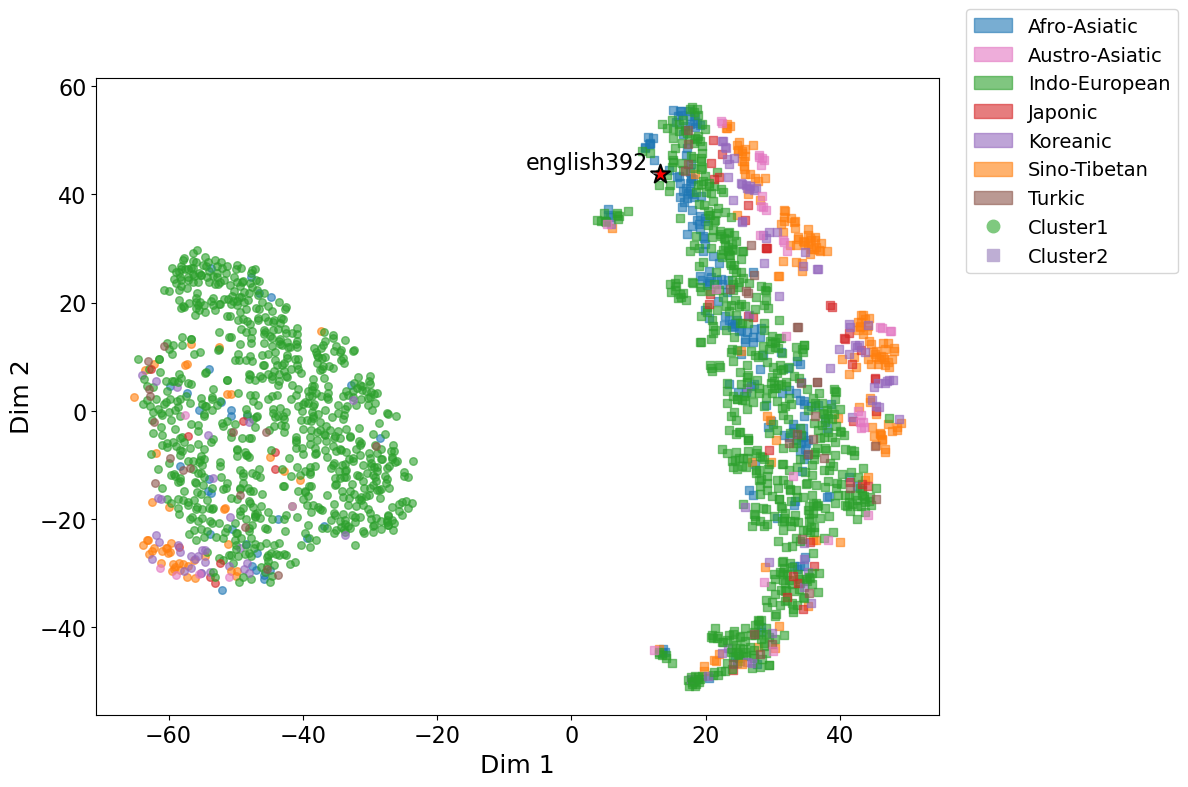

In [ ]:
conditions = [
    df_plot["x"] < 0
]
choices = [1]
df_plot["group"] = np.select(conditions, choices, default=2)

# Define marker shapes for groups
marker_map = {1: 'o', 2: 's'}  # circle, square, triangle
group_labels = {1: 'Cluster1', 2: 'Cluster2'}
cmap = plt.cm.get_cmap('tab20', len(unique_labels))
color_map = {label: cmap(i) for i, label in enumerate(unique_labels)}

cm = plt.cm.get_cmap('Accent')
colors = {1: cm(0), 2: cm(1)}
cs = {1: 'green', 2: 'purple'}

plt.figure(figsize=(12, 8))

# Loop through each combination of group + label
for idx, row in df_plot.iterrows():
    plt.scatter(
        row['x'],
        row['y'],
        color=palette[row['label']],
        marker=marker_map[row['group']],
        s = 30,
        alpha=0.6,
        label=None  
    )

# Highlight a specific data point, e.g., "english392"
highlight_row = df_plot[df_plot["id"] == "english392"]

if not highlight_row.empty:
    x_val = highlight_row["x"].values[0]
    y_val = highlight_row["y"].values[0]

    # Plot the highlighted point
    plt.scatter(
        x_val,
        y_val,
        color='red',
        marker='*',
        s=200,
        edgecolors='black',
        linewidths=1.5,
        label="english392"
    )

    # Annotate with line connecting to the label
    plt.annotate(
        "english392",
        xy=(x_val, y_val),              
        xytext=(x_val -20, y_val + 1),  
        textcoords='data',
        arrowprops=dict(
            arrowstyle='-',           
            color='gray',
            lw=1
        ),
        fontsize=16,
        color='black'
    )

# ---- Custom legends ----
# Legend for language families (color only)
color_patches = [
    mpatches.Patch(color=palette[label], label=label, alpha=0.6) for label in unique_labels
]
# Legend for groups (marker shape only)
group_handles = [
    mlines.Line2D([], [], color=colors[g], marker=marker_map[g], linestyle='None',
                  markersize=9, label=group_labels[g]) for g in group_labels
]
# Add both legends
combined_handles = color_patches + group_handles
plt.legend(
    handles=combined_handles,
    loc='center left',               
    bbox_to_anchor=(1.02, 0.9),     
    frameon=True,
    fontsize=14,
)

plt.xlabel("Dim 1", fontsize =18)
plt.ylabel("Dim 2", fontsize= 18)
plt.tick_params(axis='both', labelsize=16)
plt.grid(False)
plt.tight_layout()
plt.savefig("plot/bias/Embeddings.pdf")
plt.show()

color_map = {
    label: matplotlib.colors.to_hex(cmap(i))  
    for i, label in enumerate(unique_labels)
}

fig = px.scatter(
    df_plot, 
    x="x", 
    y="y", 
    color="label", 
    color_discrete_map=color_map,
    hover_data=["id"],
    title="Whisper Embeddings (t-SNE)", 
    width=900, 
    height=700
)
fig.show()

In [ ]:
# Load and resample audio files
def load_and_resample(path, target_sr=16000):
    waveform, sr = torchaudio.load(path) 
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)  
    return waveform.squeeze().numpy(), target_sr

# Convert numpy audio to 16-bit PCM bytes 
def wav_to_pcm_bytes(waveform):
    import numpy as np
    waveform = (waveform * 32768).astype(np.int16)  
    return waveform.tobytes()

# Frame generator 
class Frame:
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration
def frame_generator(frame_duration_ms, audio_bytes, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = n / (2 * sample_rate)
    while offset + n <= len(audio_bytes):
        yield Frame(audio_bytes[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n

# VAD collection 
def vad_collector(sample_rate, frame_duration_ms, padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    triggered = False
    segments = []

    segment_start = 0
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        if not triggered:
            ring_buffer.append((frame, is_speech))
            if sum(s for _, s in ring_buffer) > 0.9 * ring_buffer.maxlen:
                triggered = True
                segment_start = ring_buffer[0][0].timestamp
                ring_buffer.clear()
        else:
            ring_buffer.append((frame, is_speech))
            if sum(1 for _, s in ring_buffer if not s) > 0.9 * ring_buffer.maxlen:
                triggered = False
                segment_end = frame.timestamp + frame.duration
                segments.append((segment_start, segment_end))
                ring_buffer.clear()

    if triggered:
        segment_end = frame.timestamp + frame.duration
        segments.append((segment_start, segment_end))

    return segments


pause_times = []
groups = []
durations = []
ids = []
sen_times = []
for index, row in result_small.iterrows():
    path = "/Users/tinghui/workspace/github/Thesis/Data/speech-accent-archive/audio/" + row['id'] + ".wav"

    waveform, sr = load_and_resample(path)
    pcm_bytes = wav_to_pcm_bytes(waveform)

    # Run VAD
    vad = webrtcvad.Vad(3)  # 0-3 aggressiveness
    frames = list(frame_generator(10, pcm_bytes, sr))
    segments = vad_collector(sr, 10, 200, vad, frames)
    duration = len(waveform) / sr
    pause_time = 0 
    sentence_time = 0
    prev_end = 0
    for i in range(len(segments)):
        sentence_time += segments[i][1]-segments[i][0]
        if i==0:
            prev_end = segments[i][1]
        else:
            pause_time += (segments[i][0] - prev_end)
            prev_end = segments[i][1]
    ids.append(row['id'])

    sen_times.append(sentence_time)
    durations.append(duration)
    pause_times.append(pause_time)
    
pauses_df = pd.DataFrame({
            "id": ids,
            "pause": pause_times,
            "duration": durations,
            "Tsentence": sen_times
        })
result_small = pd.merge(result_small, pauses_df,   on='id', how="left")
result_small = pd.merge(result_small, df_plot ,   on='id', how="right")


In [23]:
for group in result_small['group'].unique():
    subset = result_small[result_small['group'] == group]
    print(group, "duration", subset['duration'].max(), subset['duration'].min(), "pause", subset['pause'].max(), subset['pause'].min())


2 duration 91.32575 25.000625 pause 25.630000000000738 0.0
1 duration 25.0 16.4605625 pause 5.410000000000275 0.0


/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_28180/616631094.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



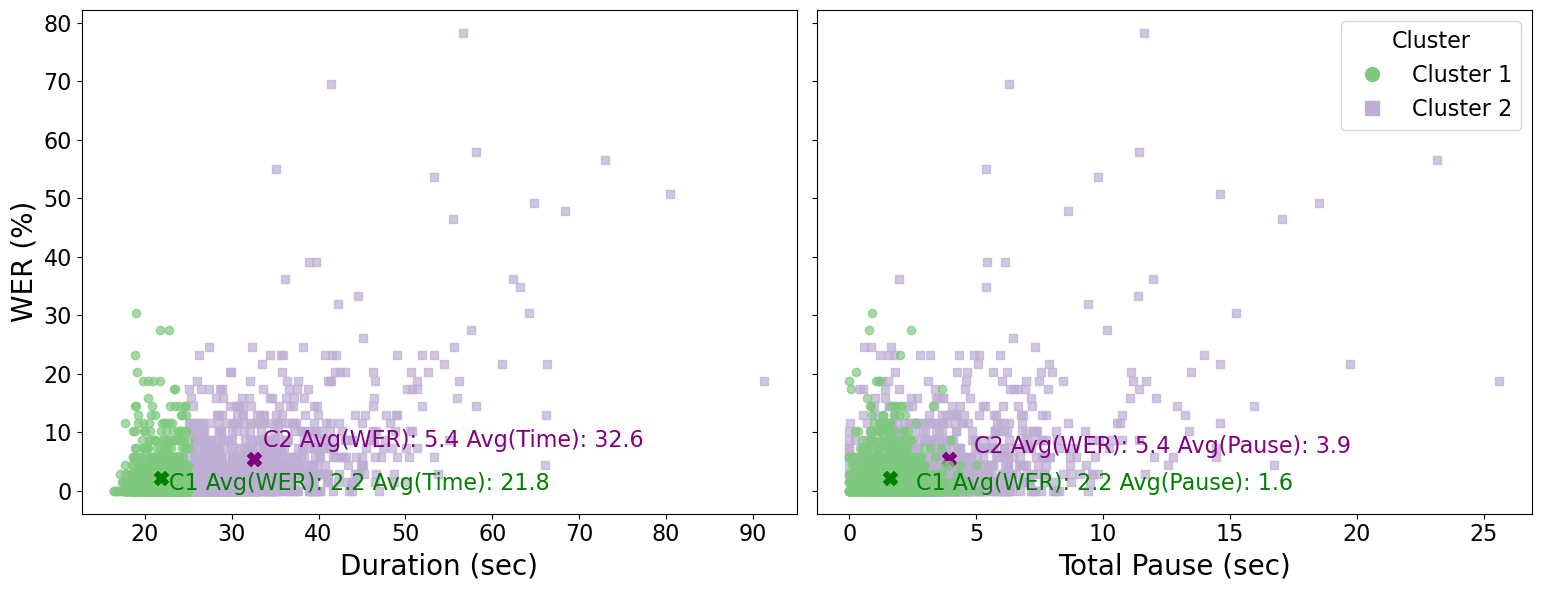

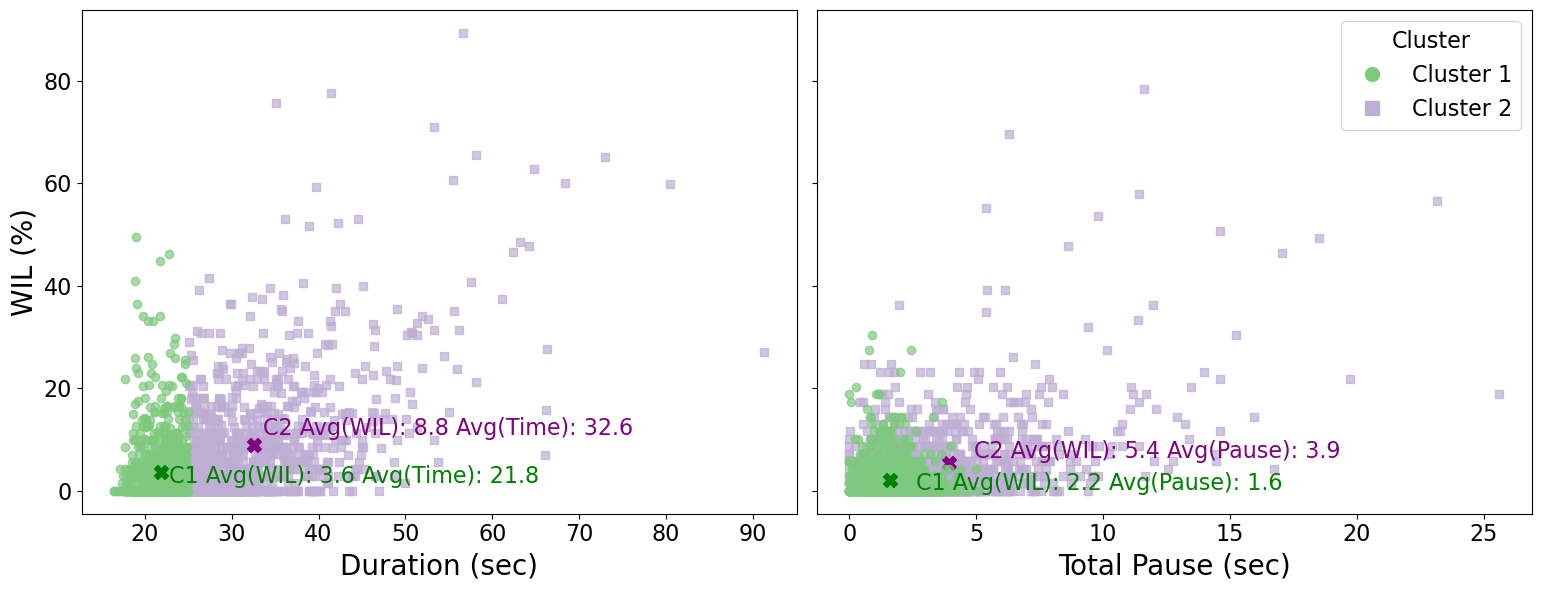

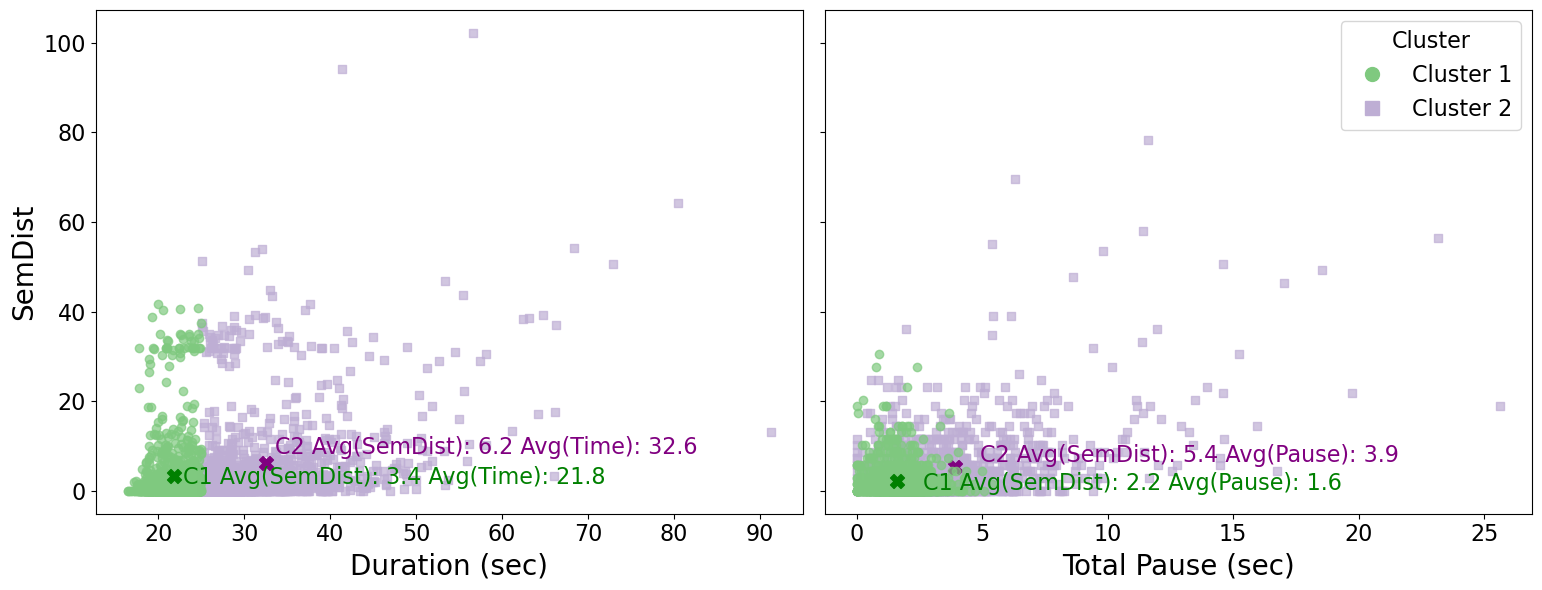

In [ ]:
# Setup
markers = {1: 'o', 2: 's', 3: '^'}  
cmap = plt.cm.get_cmap('Accent')
colors = {1: cmap(0), 2: cmap(1)}
cs = {1: 'green', 2: 'purple'}

metrics = ["WER", "WIL", "SemDist"]

for metric in metrics:
    
    if metric != 'SemDist':
        text = f'{metric} (%)'
    else:
        text = metric

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # -------- Plot 1: Duration vs WER --------
    ax = axes[0]
    for group in result_small['group'].unique():
        subset = result_small[result_small['group'] == group]
        ax.scatter(subset['duration'], subset[metric ],
                label=f'Cluster {group}',
                marker=markers.get(group, 'o'),
                color=colors.get(group, 'black'),
                alpha=0.7)
        
        avg_wer = subset[metric].mean()
        avg_T = subset['duration'].mean()
        ax.scatter(avg_T, avg_wer, color=cs.get(group, 'black'),
                marker='X', s=100, label=f'G{group} Avg')
        if group == 1:
             offset = -2
        else:
             offset = 2
        ax.text(avg_T + 1, avg_wer + offset,
                s=f'C{group} Avg({metric}): {avg_wer:.1f} Avg(Time): {avg_T:.1f}',
                color=cs.get(group, 'black'), fontsize=16)

    ax.set_xlabel('Duration (sec)', fontsize=20)
    ax.set_ylabel(text, fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(False)

    # -------- Plot 2: pause vs WER --------
    ax = axes[1]
    for group in result_small['group'].unique():
        subset = result_small[result_small['group'] == group]
        ax.scatter(subset['pause'], subset['WER'],
                label=f'Cluster {group}',
                marker=markers.get(group, 'o'),
                color=colors.get(group, 'black'),
                alpha=0.7)
        
        avg_wer = subset['WER'].mean()
        avg_pause = subset['pause'].mean()
        ax.scatter(avg_pause, avg_wer, color=cs.get(group, 'black'),
                marker='X', s=100, label=f'G{group} Avg')
        if group == 1:
             offset = -2
        else:
             offset = 1
        ax.text(avg_pause + 1, avg_wer + offset,
                s=f'C{group} Avg({metric}): {avg_wer:.1f} Avg(Pause): {avg_pause:.1f}',
                color=cs.get(group, 'black'), fontsize=16)

    ax.set_xlabel('Total Pause (sec)', fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(False)

    # -------- Shared legend --------
    group_handles = [
        mlines.Line2D([], [], color=colors[g], marker=markers[g], linestyle='None',
                    markersize=10, label=f'Cluster {g}') for g in sorted(colors.keys())
    ]
    plt.legend(handles=group_handles, title="Cluster", loc='upper right', fontsize=16, title_fontsize=16)

    # Layout
    plt.tight_layout(rect=[0, 0, 0.97, 1])  
    plt.savefig(f"plot/bias/{metric}vsDurationPause.pdf")
    plt.show()


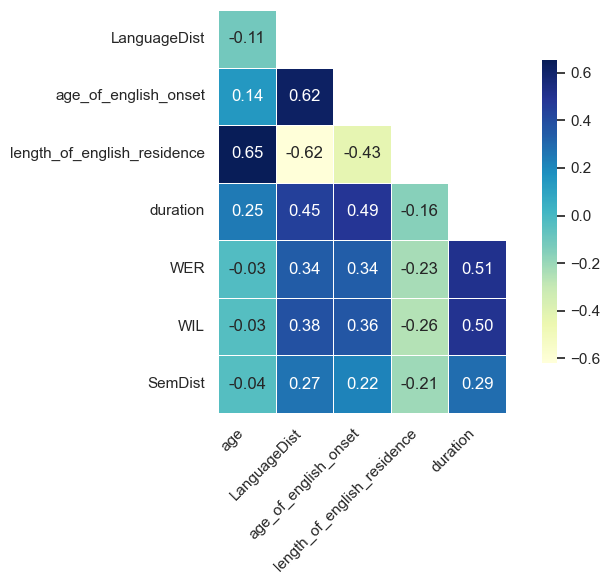

age vs WER: r = -0.026, p = 0.23684
age vs WIL: r = -0.033, p = 0.14175
age vs SemDist: r = -0.037, p = 0.09421


In [ ]:
# Correlation matrix
cols = [
    'age', 'LanguageDist', 'age_of_english_onset',
    'length_of_english_residence', 'duration', 
    'WER', 'WIL', 'SemDist'
]
corr = result_small[cols].corr()

# Build initial mask
mask = np.triu(np.ones_like(corr, dtype=bool))
# Mask WER–WIL–SemDist against each other
exclude = ['WER', 'WIL', 'SemDist']
for i, row in enumerate(corr.index):
    for j, col in enumerate(corr.columns):
        if row in exclude and col in exclude:
            mask[i, j] = True

# Masked version to detect fully hidden rows/cols
masked_corr = corr.mask(mask)

# Drop fully masked rows and columns
visible_rows = ~masked_corr.isnull().all(axis=1)
visible_cols = ~masked_corr.isnull().all(axis=0)
filtered_corr = corr.loc[visible_rows, visible_cols]
filtered_mask = mask[visible_rows.values, :][:, visible_cols.values]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    filtered_corr,
    mask=filtered_mask,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.75}
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(False)
plt.savefig("plot/bias/correlation.pdf")
plt.show()

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        r, p = pearsonr(result_small[cols[i]], result_small[cols[j]])
        if p > 0.05:
            print(f"{cols[i]} vs {cols[j]}: r = {r:.3f}, p = {p:.5f}")


In [ ]:
# Store added words for each group
added_words_group1 = Counter()
added_words_group2 = Counter()

# Process each row
for _, row in result_small.iterrows():
    if row['group'] not in [1, 2]:
        continue
    hyp = EnglishTextNormalizer()(row['prediction'])
    removed, added, replaced = get_word_diffs(ref, hyp)
    if row['group'] == 1:
        added_words_group1.update((tuple(r[0]), tuple(r[1])) for r in replaced)
    elif row['group'] == 2:
        added_words_group2.update((tuple(r[0]), tuple(r[1])) for r in replaced)


# Get most common added words
common_added_group2 = added_words_group2.most_common()
common_added_group1 = added_words_group1.most_common()

# Convert to sets for comparison
words_group1 = set(added_words_group1)
words_group2 = set(added_words_group2)

# Compare
only_in_group2 = words_group2 - words_group1
common_in_both = words_group2 & words_group1

print("Group1: ", len(result_small[result_small['group'] == 1]), "Group2: ", len(result_small[result_small['group'] == 2]))
print("Common replaced words in group 2:", common_added_group2[:10])
print("Common replaced words in group 1:", common_added_group1[:10])

Group1:  930 Group2:  1085
Common replaced words in group 2: [((('snake',), ('snack',)), 173), ((('these', 'things'), ('this', 'thing')), 69), ((('scoop',), ('scope',)), 49), ((('these',), ('the',)), 41), ((('these',), ('those',)), 40), ((('snack',), ('snake',)), 34), ((('wednesday',), ('one', 'day')), 26), ((('5', 'thick'), ('56',)), 26), ((('her',), ('here',)), 23), ((('thick',), ('thin',)), 21)]
Common replaced words in group 1: [((('her',), ('a',)), 56), ((('snake',), ('snack',)), 32), ((('snow',), ('milk',)), 17), ((('these',), ('the',)), 16), ((('snow',), ('no',)), 16), ((('thick',), ('6',)), 15), ((('6', 'spoons'), ('£6',)), 15), ((('into',), ('in', 'the')), 13), ((('5', 'thick'), ('56',)), 11), ((('3',), ('free',)), 11)]


In [ ]:
r_wer, _ = spearmanr(result_small['duration'], result_small['WER'])
r_sem, _ = spearmanr(result_small['duration'], result_small['SemDist'])
print(f"Spearman correlation (Length vs WER): {r_wer}")
print(f"Spearman correlation (Length vs Semantic): {r_sem}")

# example: duration vs WER
pearson_corr, _ = pearsonr(result_small['duration'], result_small['WER'])
spearman_corr, _ = spearmanr(result_small['duration'], result_small['WER'])
print(f"Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}")
pearson_corr, _ = pearsonr(result_small['duration'], result_small['WIL'])
spearman_corr, _ = spearmanr(result_small['duration'], result_small['WIL'])
print(f"Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}")
pearson_corr, _ = pearsonr(result_small['duration'], result_small['SemDist'])
spearman_corr, _ = spearmanr(result_small['duration'], result_small['SemDist'])
print(f"Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}")

Spearman correlation (Length vs WER): 0.39501517504237094
Spearman correlation (Length vs Semantic): 0.3200861135671735
Pearson: 0.51, Spearman: 0.40
Pearson: 0.50, Spearman: 0.39
Pearson: 0.29, Spearman: 0.32


# Comparison between finetune & original

### LWF

In [ ]:
embeddings_dic_fine = {}
opt = {
        "model_name": "openai/whisper-small",
        "strategy": "lwf",
        "language": 'en',
        "device": "cuda" if torch.cuda.is_available() else "cpu"
    }
# Load processor and model
device = opt['device']
checkpoint_path = "models/lwf/checkpoint-350"
# Initialize the processor
processor = WhisperProcessor.from_pretrained(checkpoint_path ) 

# Instantiate your custom model
model = Whisper(opt)
model.load_state_dict(torch.load(f"{checkpoint_path}/full_model.pth", map_location=torch.device('cpu')))

# Move to device and set to evaluation mode
model.to('cpu')
model.eval()

sample_rate = 16000
chunk_duration = 25  # seconds
chunk_samples = sample_rate * chunk_duration

for i, row in tqdm(saa_df.iterrows(), total=len(saa_df), desc="Processing"):
    file_id = row["id"]
    accent = row["native_language"]
    file_path = f"/Users/tinghui/workspace/github/Thesis/Data/speech-accent-archive/audio/{row['id']}.wav"

    y, sr = librosa.load(file_path, sr=sample_rate)


    total_length = len(y)
    num_chunks = (total_length + chunk_samples - 1) // chunk_samples

    chunk_embeddings = []
    for split_idx in range(num_chunks):
        start_sample = split_idx * chunk_samples
        end_sample = min(start_sample + chunk_samples, total_length)
        audio_chunk = y[start_sample:end_sample]

        inputs = processor(audio_chunk, sampling_rate=sample_rate, return_tensors="pt")
        input_features = inputs.input_features.to(device)
        
        with torch.no_grad():
            accent_id_tensor = torch.tensor([accent_map[language_family_dict[accent]]], device=device)
            model._base_model.model.encoder.layers[11].set_accent_id(accent_id_tensor)

            forced_decoder_ids = model.processor.get_decoder_prompt_ids(language="en", task="transcribe")
            encoder_outputs = model._base_model.model.get_encoder()(input_features)

            final_hidden = encoder_outputs[0] if isinstance(encoder_outputs, tuple) else encoder_outputs
            
        chunk_embedding = encoder_outputs.last_hidden_state.squeeze(0)  # remove batch dim
        chunk_embeddings.append((split_idx, chunk_embedding.cpu()))
        
    # Merge embeddings
    if chunk_embeddings:
        sorted_chunks = sorted(chunk_embeddings, key=lambda x: x[0])
        
        full_embedding = torch.cat([emb for _, emb in sorted_chunks], dim=0)
        pooled = full_embedding.mean(dim=0)
        embeddings_dic_fine[file_id] = pooled

Gradient checkpointing enabled: True


/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/4035342504.py:22: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Processing: 100%|██████████| 2015/2015 [35:02

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/3885656456.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/3885656456.py:36: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



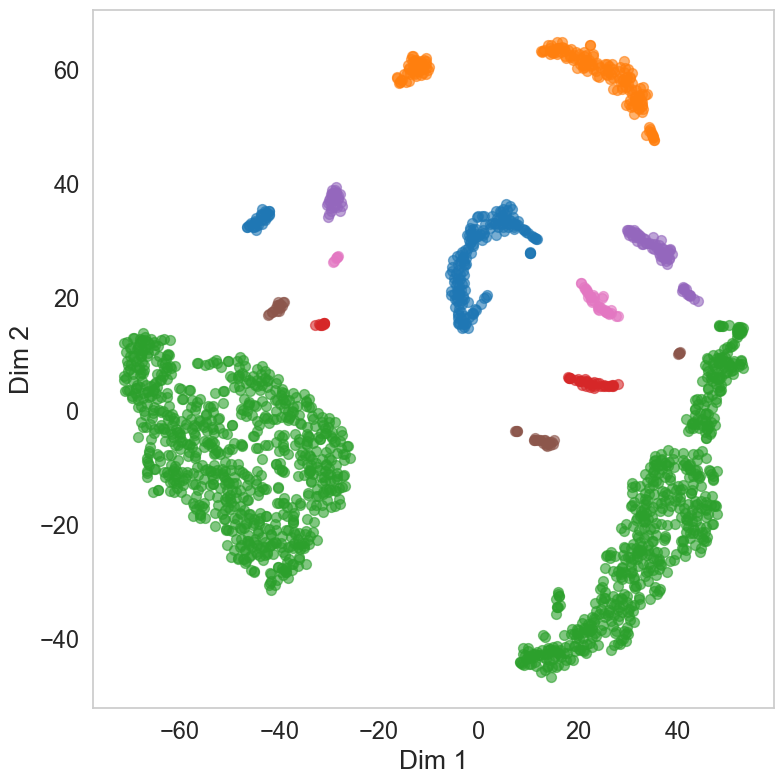

In [ ]:
file_ids = list(embeddings_dic_fine.keys())
embeddings_fine = torch.stack([embeddings_dic_fine[fid] for fid in file_ids]).numpy()  
# Optional: labels for coloring
labels = [result_small[result_small['id'] == fid]['Language_Family'].values[0] for fid in file_ids]  

# Dimensionality reduction
tsne = TSNE(n_components=2,random_state=42, n_iter=5000, metric='cosine', perplexity=30)
embeddings_fine_2d = tsne.fit_transform(embeddings_fine)

unique_labels = sorted(set(labels))

# Get colormap 
df_fine_plot = pd.DataFrame({
    "x": embeddings_fine_2d[:, 0],
    "y": embeddings_fine_2d[:, 1],
    "id": file_ids,
    "label": labels
})


plt.figure(figsize=(8, 8))

# Loop through each combination of group + label
for idx, row in df_fine_plot.iterrows():
    plt.scatter(
        row['x'],
        row['y'],
        color=palette[row['label']],
        s = 50,
        alpha=0.6,
        label=None  # Prevent duplicate legend entries
    )

plt.xlabel("Dim 1", fontsize =19)
plt.ylabel("Dim 2", fontsize= 19)
plt.tick_params(axis='both', labelsize=17)
plt.grid(False)
plt.tight_layout()
plt.savefig(f"plot/finetune/embedding_lora.pdf", )
plt.show()

### LoRA

In [ ]:
embeddings_dic_lora = {}
opt = {
        "model_name": "openai/whisper-small",
        "strategy": "lora",
        "language": 'en',
        "device": "cuda" if torch.cuda.is_available() else "cpu"
    }
# Load processor and model
device = opt['device']
checkpoint_path = "models/lora/test/checkpoint-50"
# Initialize the processor
processor = WhisperProcessor.from_pretrained(checkpoint_path )

# Instantiate your custom model
model = Whisper(opt)
model.load_state_dict(torch.load(f"{checkpoint_path}/full_model.pth", map_location=torch.device('cpu')))

# Move to device and set to evaluation mode
model.to('cpu')
model.eval()

sample_rate = 16000
chunk_duration = 25  
chunk_samples = sample_rate * chunk_duration

for i, row in tqdm(saa_df.iterrows(), total=len(saa_df), desc="Processing"):
    file_id = row["id"]
    accent = row["native_language"]
    file_path = f"/Users/tinghui/workspace/github/Thesis/Data/speech-accent-archive/audio/{row['id']}.wav"

    y, sr = librosa.load(file_path, sr=sample_rate)

    total_length = len(y)
    num_chunks = (total_length + chunk_samples - 1) // chunk_samples 

    chunk_embeddings = []
    for split_idx in range(num_chunks):
        start_sample = split_idx * chunk_samples
        end_sample = min(start_sample + chunk_samples, total_length)
        audio_chunk = y[start_sample:end_sample]

        inputs = processor(audio_chunk, sampling_rate=sample_rate, return_tensors="pt")
        input_features = inputs.input_features.to(device)
        with torch.no_grad():
            accent_id_tensor = torch.tensor([accent_map[language_family_dict[accent]]], device=device)
            model._encoder_layers[11].set_accent_id(accent_id_tensor)

            forced_decoder_ids = model.processor.get_decoder_prompt_ids(language="en", task="transcribe")
            encoder_outputs = model._base_model.model.get_encoder()(input_features)

            final_hidden = encoder_outputs[0] if isinstance(encoder_outputs, tuple) else encoder_outputs
            
        chunk_embedding = encoder_outputs.last_hidden_state.squeeze(0) 
        chunk_embeddings.append((split_idx, chunk_embedding.cpu()))
        
    # Merge embeddings
    if chunk_embeddings:
        sorted_chunks = sorted(chunk_embeddings, key=lambda x: x[0])
        
        full_embedding = torch.cat([emb for _, emb in sorted_chunks], dim=0)
        pooled = full_embedding.mean(dim=0)
        embeddings_dic_lora[file_id] = pooled

Gradient checkpointing enabled: True


/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/1378643174.py:22: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Processing: 100%|██████████| 2015/2015 [34:48

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/3324633265.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/3324633265.py:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



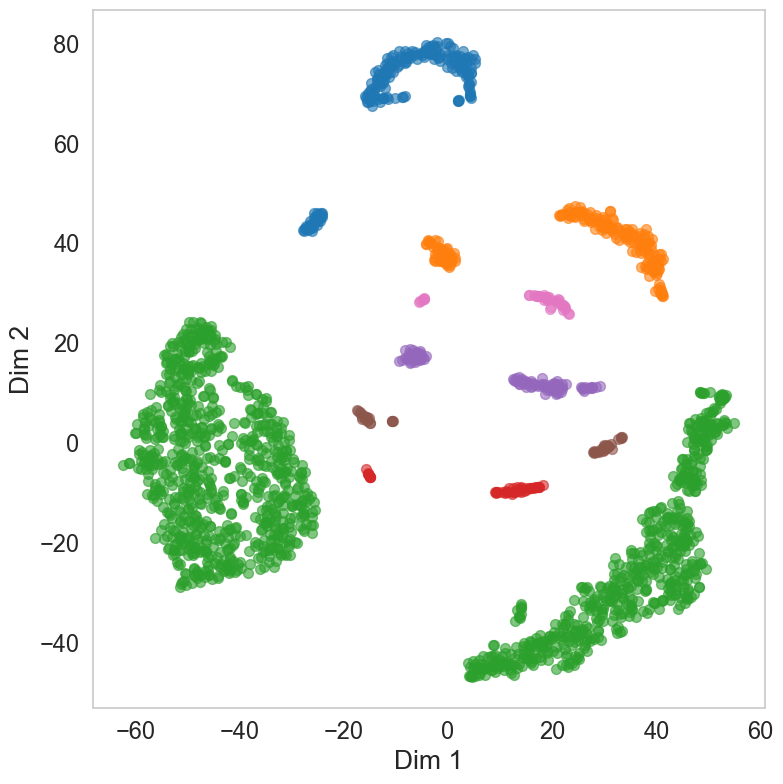

In [ ]:
file_ids = list(embeddings_dic_lora.keys())
embeddings_fine = torch.stack([embeddings_dic_lora[fid] for fid in file_ids]).numpy()  # shape: (N, hidden_dim)

# Optional: labels for coloring
labels = [result_small[result_small['id'] == fid]['Language_Family'].values[0] for fid in file_ids]  

# Dimensionality reduction
tsne = TSNE(n_components=2,random_state=42, n_iter=5000, metric='cosine', perplexity=30)

embeddings_fine_2d = tsne.fit_transform(embeddings_fine)

unique_labels = sorted(set(labels))
df_fine_plot = pd.DataFrame({
    "x": embeddings_fine_2d[:, 0],
    "y": embeddings_fine_2d[:, 1],
    "id": file_ids,
    "label": labels
})

plt.figure(figsize=(8, 8))

# Loop through each combination of group + label
for idx, row in df_fine_plot.iterrows():
    plt.scatter(
        row['x'],
        row['y'],
        color=palette[row['label']],
        s = 50,
        alpha=0.6,
        label=None  
    )

plt.xlabel("Dim 1", fontsize =19)
plt.ylabel("Dim 2", fontsize= 19)
plt.tick_params(axis='both', labelsize=17)
plt.grid(False)
plt.tight_layout()
plt.savefig(f"plot/finetune/embedding_lwf.pdf", )
plt.show()

### LEACE

In [ ]:
def add_leace(model):
    eraser_dir = "models/leace_erasers/"
    erasers = []
    layers_to_hook = [11]
    
    # Load erasers for these layers
    for i in layers_to_hook:
        path = os.path.join(eraser_dir, f"leace_eraser_layer{i}.pt")
        erasers.append(torch.load(path))

    # Register hooks only on these layers
    for layer_idx, eraser in zip(layers_to_hook, erasers):
        layer = model.model.encoder.layers[layer_idx]
        
        def make_hook(my_eraser):
            def hook_fn(module, input, output):
                hidden_states = output[0]
                erased = my_eraser(hidden_states.squeeze(0)).unsqueeze(0)
                return (erased,)
            return hook_fn
        
        layer.register_forward_hook(make_hook(eraser))
    return model
# Load processor and model
model_type = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_type, language="en", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(model_type)
model =add_leace(model)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assume saa_df has 'id' and 'FilePath'
sample_rate = 16000
chunk_duration = 25  # seconds
chunk_samples = sample_rate * chunk_duration
embeddings_dic_leace = {}

for i, row in tqdm(saa_df.iterrows(), total=len(saa_df), desc="Processing"):
    file_id = row["id"]
    file_path = f"/Users/tinghui/workspace/github/Thesis/Data/speech-accent-archive/audio/{row['id']}.wav"
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

    try:
        y, sr = librosa.load(file_path, sr=sample_rate)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        continue

    total_length = len(y)
    num_chunks = (total_length + chunk_samples - 1) // chunk_samples  

    chunk_embeddings = []
    for split_idx in range(num_chunks):
        start_sample = split_idx * chunk_samples
        end_sample = min(start_sample + chunk_samples, total_length)
        audio_chunk = y[start_sample:end_sample]

        inputs = processor(audio_chunk, sampling_rate=sample_rate, return_tensors="pt")
        input_features = inputs.input_features.to(device)

        with torch.no_grad():
            encoder_outputs = model.model.encoder(input_features.squeeze(1))
        chunk_embedding = encoder_outputs.last_hidden_state.squeeze(0)  
        chunk_embeddings.append((split_idx, chunk_embedding.cpu()))

    # Merge embeddings
    if chunk_embeddings:
        sorted_chunks = sorted(chunk_embeddings, key=lambda x: x[0])
        
        full_embedding = torch.cat([emb for _, emb in sorted_chunks], dim=0)
        pooled = full_embedding.mean(dim=0)
        embeddings_dic_leace[file_id] = pooled

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/1907357384.py:12: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Processing: 100%|██████████| 2015/2015 [30:08

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/910774480.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/910774480.py:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_1280/910774480.py:40: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



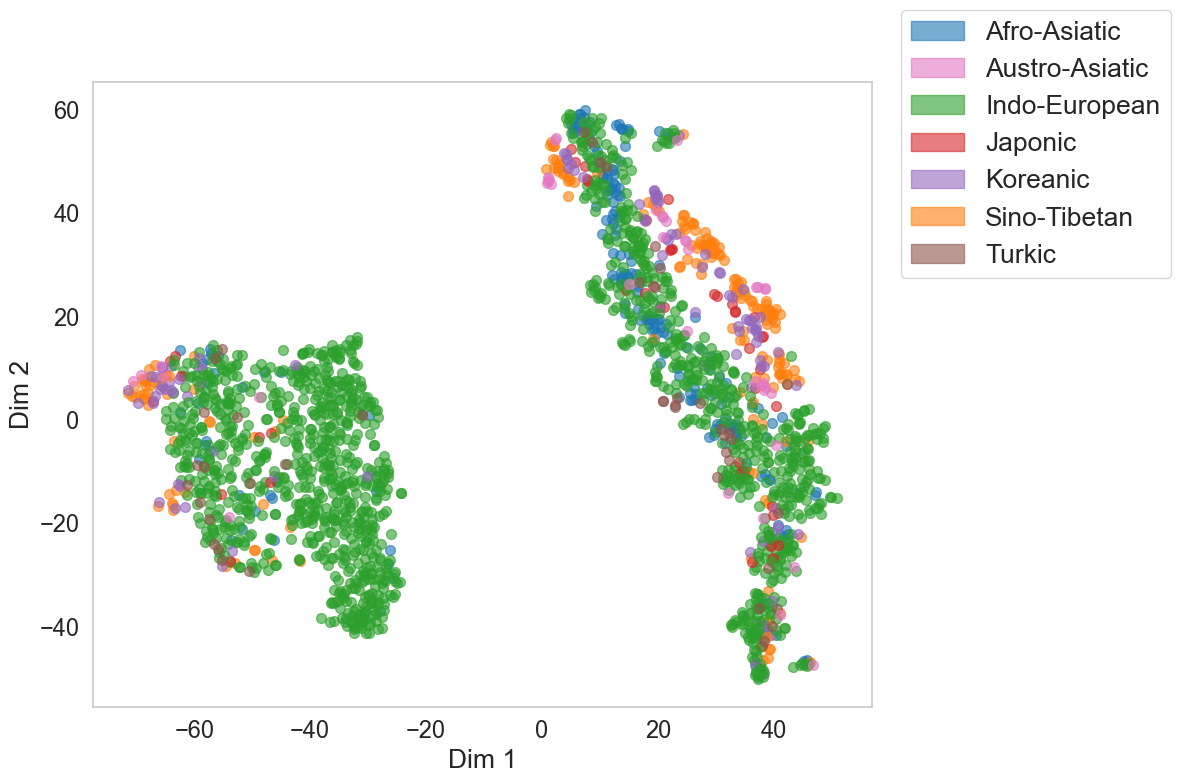

In [ ]:
file_ids = list(embeddings_dic_leace.keys())
embeddings_fine = torch.stack([embeddings_dic_leace[fid] for fid in file_ids]).numpy()  
labels = [result_small[result_small['id'] == fid]['Language_Family'].values[0] for fid in file_ids]  

# Dimensionality reduction
tsne = TSNE(n_components=2,random_state=42, n_iter=5000, metric='cosine', perplexity=30)
embeddings_fine_2d = tsne.fit_transform(embeddings_fine)

unique_labels = sorted(set(labels))

# Get colormap
cmap = plt.cm.get_cmap('tab20', len(unique_labels))  


df_fine_plot = pd.DataFrame({
    "x": embeddings_fine_2d[:, 0],
    "y": embeddings_fine_2d[:, 1],
    "id": file_ids,
    "label": labels
})

plt.figure(figsize=(12, 8))

# Loop through each combination of group + label
for idx, row in df_fine_plot.iterrows():
    plt.scatter(
        row['x'],
        row['y'],
        color=palette[row['label']],
        s = 50,
        alpha=0.6,
        label=None  
    )


# ---- Custom legends ----
# Legend for language families (color only)
color_patches = [
    mpatches.Patch(color=palette[label], label=label, alpha=0.6) for label in unique_labels
]
# Add both legends
combined_handles = color_patches 
plt.legend(
    handles=combined_handles,
    loc='center left',               
    bbox_to_anchor=(1.02, 0.9),     
    frameon=True,
    fontsize=19,
)
plt.xlabel("Dim 1", fontsize =19)
plt.ylabel("Dim 2", fontsize= 19)
plt.tick_params(axis='both', labelsize=17)
plt.grid(False)
plt.tight_layout()
plt.savefig(f"plot/finetune/embedding_leace.pdf", )
plt.show()

# Performance Difference

In [ ]:
# Load the Original results
df_ori = pd.read_csv("results/baseline/eva_small.csv")
df_ori = pd.merge(df_ori, saa_df, on="id", how="left")

# Load the Finetune-LWF results
df_lwf = pd.read_csv("results/eva_lwf2.csv")
df_lwf = pd.merge(df_lwf, saa_df, on="id", how="left")

# Load the Finetune-LoRA results
df_lora = pd.read_csv("results/eva_lora.csv")
df_lora = pd.merge(df_lora, saa_df, on="id", how="left")

# Load the Finetune-LEACE results
df_leace = pd.read_csv("results/eva_leace_11.csv")
df_leace = pd.merge(df_leace, saa_df, on="id", how="left")

def test_improvement_per_language(original_df, finetuned_df, metric, method_name):
    """
    Paired tests between baseline and fine-tuned results, per native language.
    """

    merged = pd.merge(
        original_df[["id", "native_language", metric]],
        finetuned_df[["id", "native_language", metric]],
        on=["id","native_language"],
        suffixes=("_orig", "_fine")
    )
    # Drop any rows without language or metric
    merged = merged.dropna(subset=["native_language", f"{metric}_orig", f"{metric}_fine"])
    
    # Get all unique languages
    languages = merged["native_language"].unique()
    
    # For each language, do paired test
    for lang in sorted(languages):
        subset = merged[merged["native_language"] == lang]
        
        if len(subset) < 3:
            # Too few samples to run test
            print(f"\nLanguage: {lang} | Method: {method_name}")
            print("Too few samples (<3), skipping.")
            continue
        
        diffs = subset[f"{metric}_orig"] - subset[f"{metric}_fine"]
        
        # Normality test
        shapiro_p = shapiro(diffs).pvalue
  
        if shapiro_p > 0.05:
            # Data is normal: paired t-test
            test = ttest_rel(subset[f"{metric}_orig"], subset[f"{metric}_fine"])
            test_name = "Paired t-test"
        else:
            # Non-normal: Wilcoxon signed-rank
            test = wilcoxon(subset[f"{metric}_orig"], subset[f"{metric}_fine"])
            test_name = "Wilcoxon signed-rank"
        
        print(f"\nLanguage: {lang} | Method: {method_name}")
        print(f"Normality p={shapiro_p:.4f} --> {'normal' if shapiro_p > 0.05 else 'not normal'}")
        print(f"{test_name}: statistic={test.statistic:.4f}, p={test.pvalue:.4e} significant= {int(test.pvalue < 0.05)}")

def test_improvement_overall(original_df, finetuned_df, metric, method_name):
    """
    Paired test between baseline and fine-tuned results over all samples (no grouping).
    """
    merged = pd.merge(
        original_df[["id", metric]],
        finetuned_df[["id", metric]],
        on="id",
        suffixes=("_orig", "_fine")
    )
    # Drop any rows with missing
    merged = merged.dropna(subset=[f"{metric}_orig", f"{metric}_fine"])
    
    diffs = merged[f"{metric}_orig"] - merged[f"{metric}_fine"]
    
    if len(diffs) < 3:
        print(f"\nMethod: {method_name}")
        print("Too few samples (<3), skipping.")
        return
    
    # Normality test
    shapiro_p = shapiro(diffs).pvalue
    if shapiro_p > 0.05:
        test = ttest_rel(merged[f"{metric}_orig"], merged[f"{metric}_fine"])
        test_name = "Paired t-test"
    else:
        test = wilcoxon(merged[f"{metric}_orig"], merged[f"{metric}_fine"])
        test_name = "Wilcoxon signed-rank"

    print(f"\n=== Overall Comparison: {method_name} ===")
    print(f"N = {len(diffs)}")
    print(f"Mean improvement: {diffs.mean():.4f}")
    print(f"Std improvement: {diffs.std():.4f}")
    print(f"Normality p={shapiro_p:.4e} --> {'normal' if shapiro_p > 0.05 else 'not normal'}")
    print(f"{test_name}: statistic={test.statistic:.4f}, p={test.pvalue:.4e}, significant= {bool(test.pvalue < 0.05)}")

for metric in ["WER", "WIL", "SemDist"]:
    test_improvement_overall(df_ori, df_lwf, metric, "LWF")
    test_improvement_overall(df_ori, df_lora, metric, "LORA")
    test_improvement_overall(df_ori, df_leace, metric, "LEACE")



=== Overall Comparison: LWF ===
N = 2015
Mean improvement: 0.0662
Std improvement: 1.4124
Normality p=3.2408e-57 --> not normal
Wilcoxon signed-rank: statistic=184953.0000, p=4.4682e-02, significant= True

=== Overall Comparison: LORA ===
N = 2015
Mean improvement: -0.0209
Std improvement: 1.1771
Normality p=1.0907e-62 --> not normal
Wilcoxon signed-rank: statistic=17832.0000, p=7.1940e-01, significant= False

=== Overall Comparison: LEACE ===
N = 2015
Mean improvement: -0.0460
Std improvement: 1.0865
Normality p=5.4751e-65 --> not normal
Wilcoxon signed-rank: statistic=9904.5000, p=1.2064e-01, significant= False

=== Overall Comparison: LWF ===
N = 2015
Mean improvement: -0.0001
Std improvement: 1.9699
Normality p=4.3203e-56 --> not normal
Wilcoxon signed-rank: statistic=44826.5000, p=7.9852e-01, significant= False

=== Overall Comparison: LORA ===
N = 2015
Mean improvement: -0.0176
Std improvement: 1.6663
Normality p=1.7303e-61 --> not normal
Wilcoxon signed-rank: statistic=20511.00

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_44136/2457833371.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


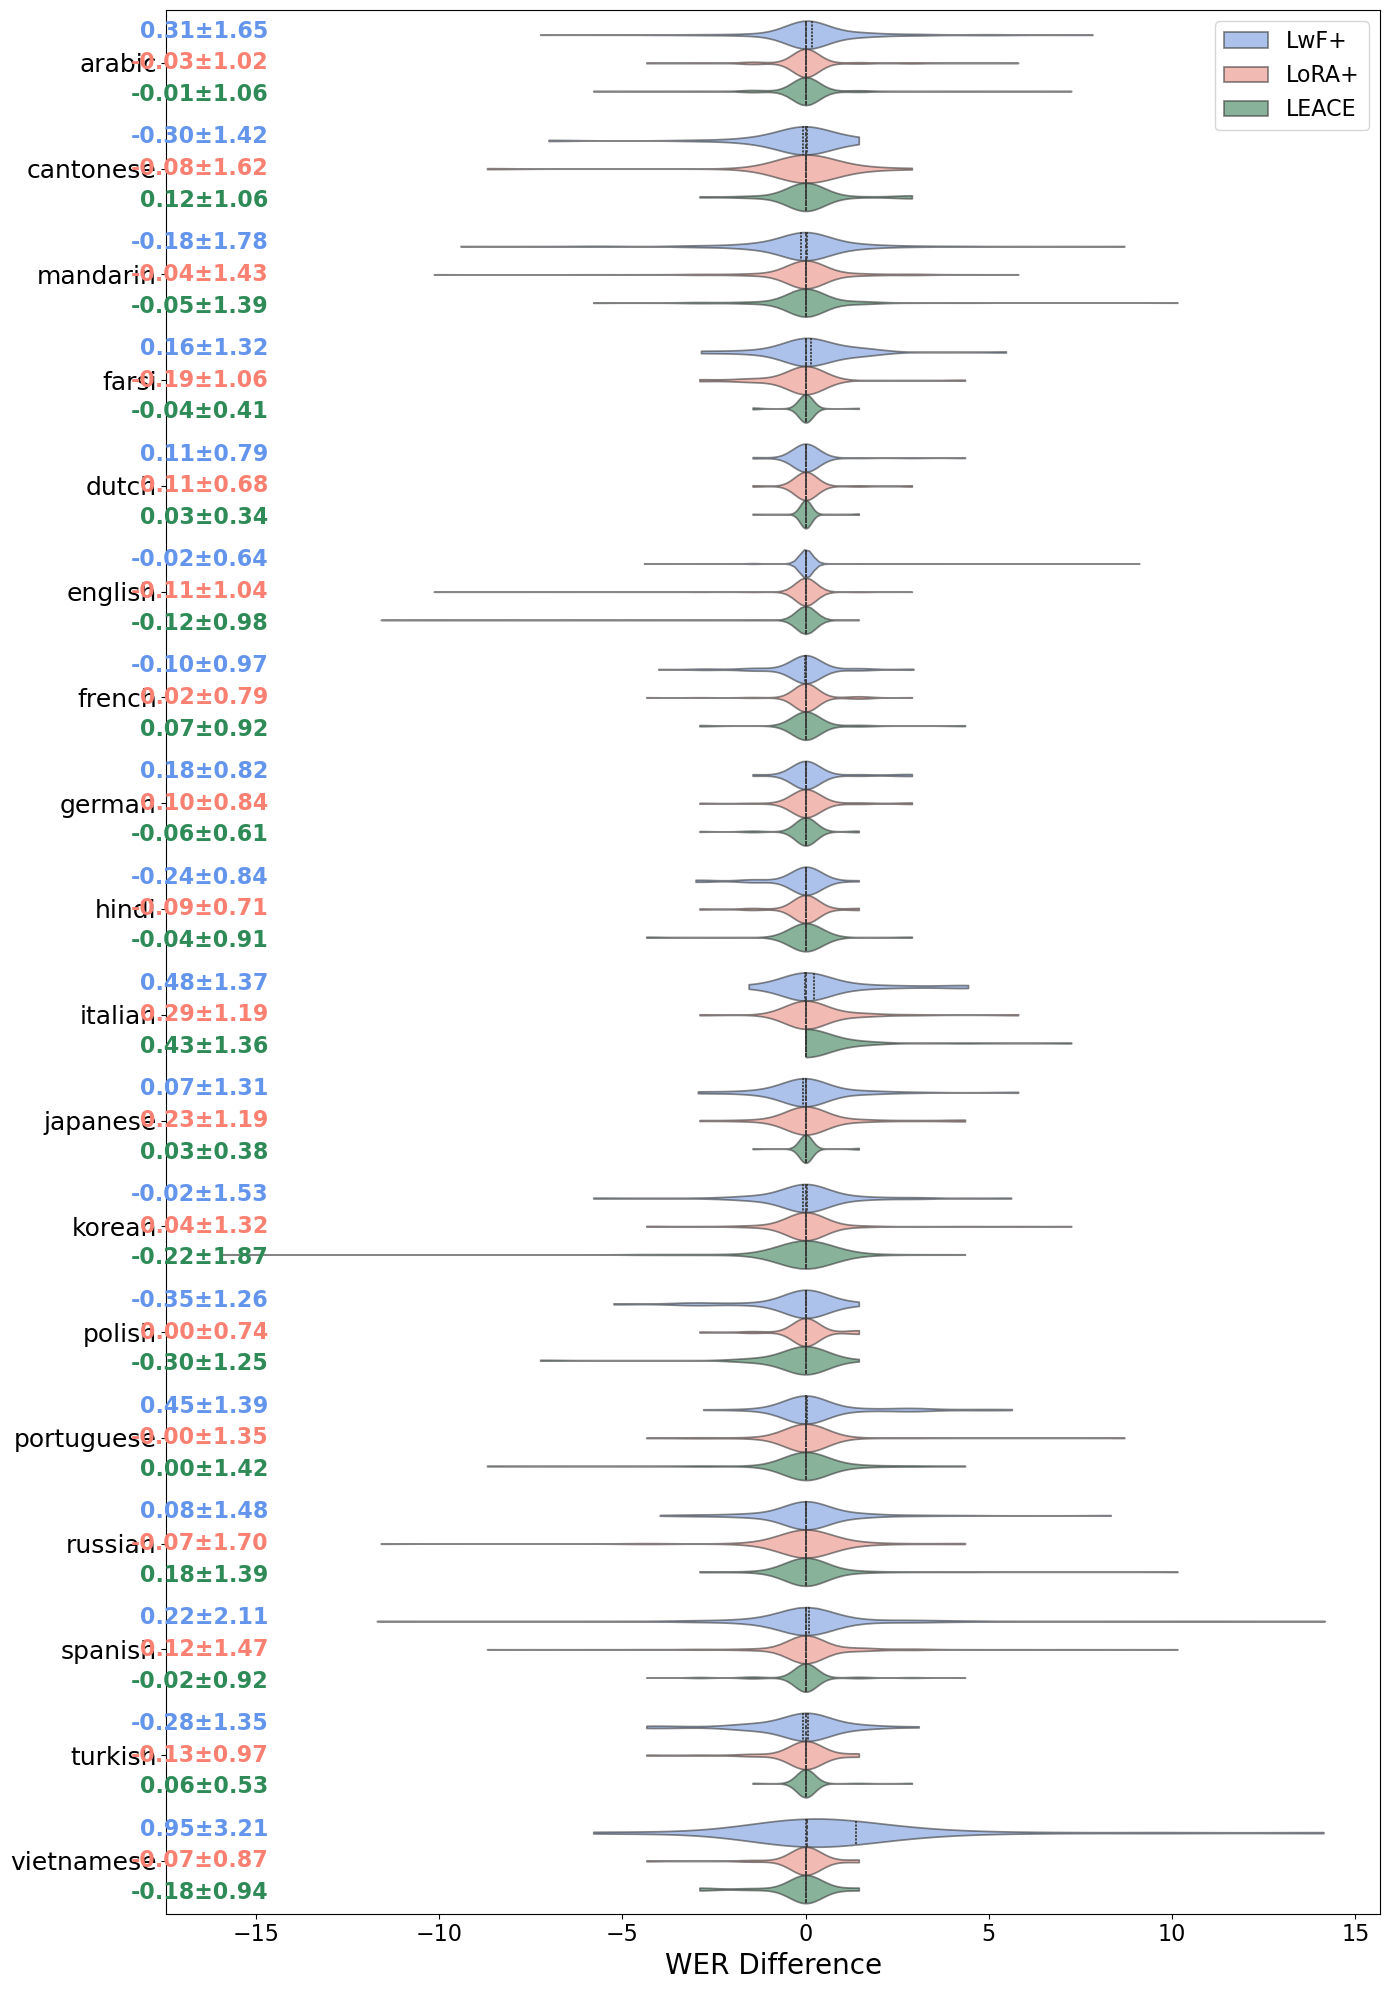

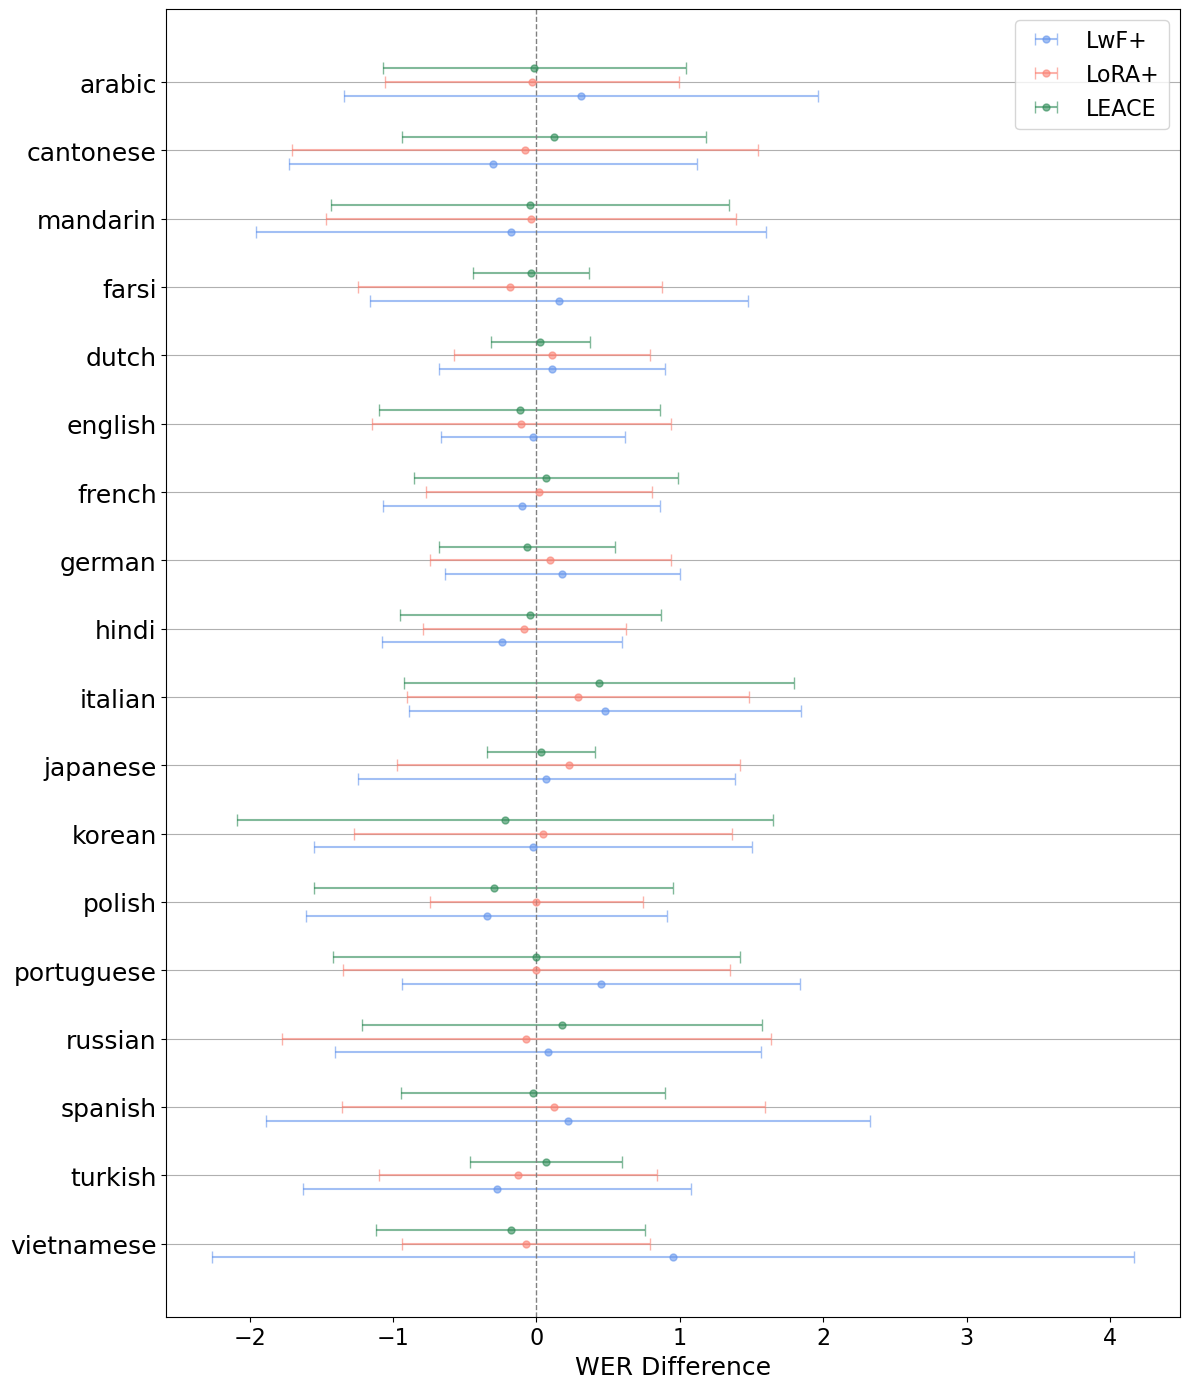

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_44136/2457833371.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


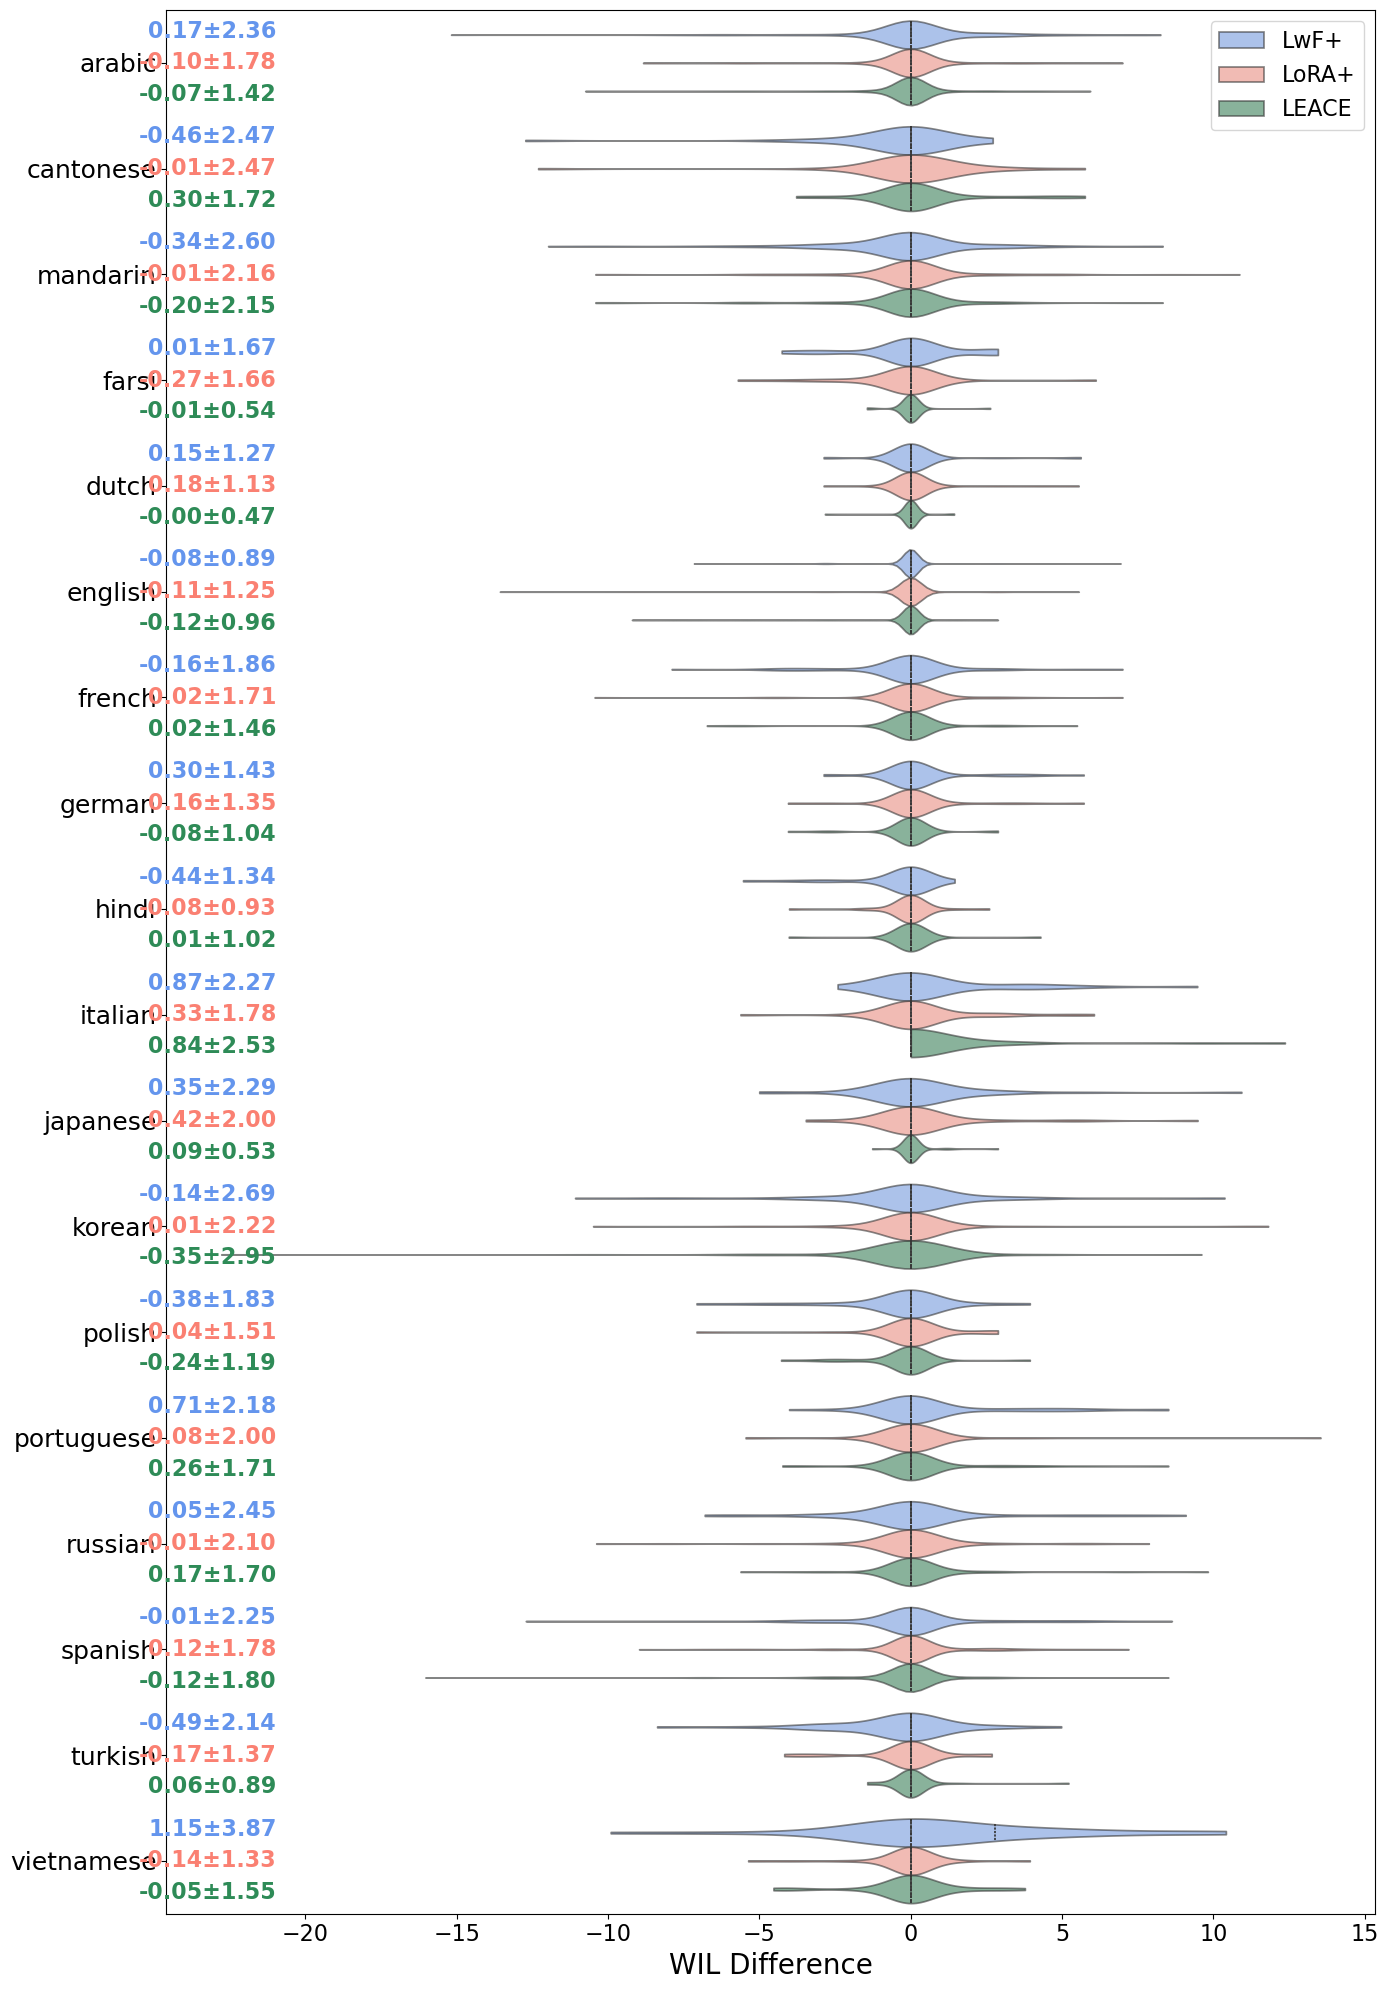

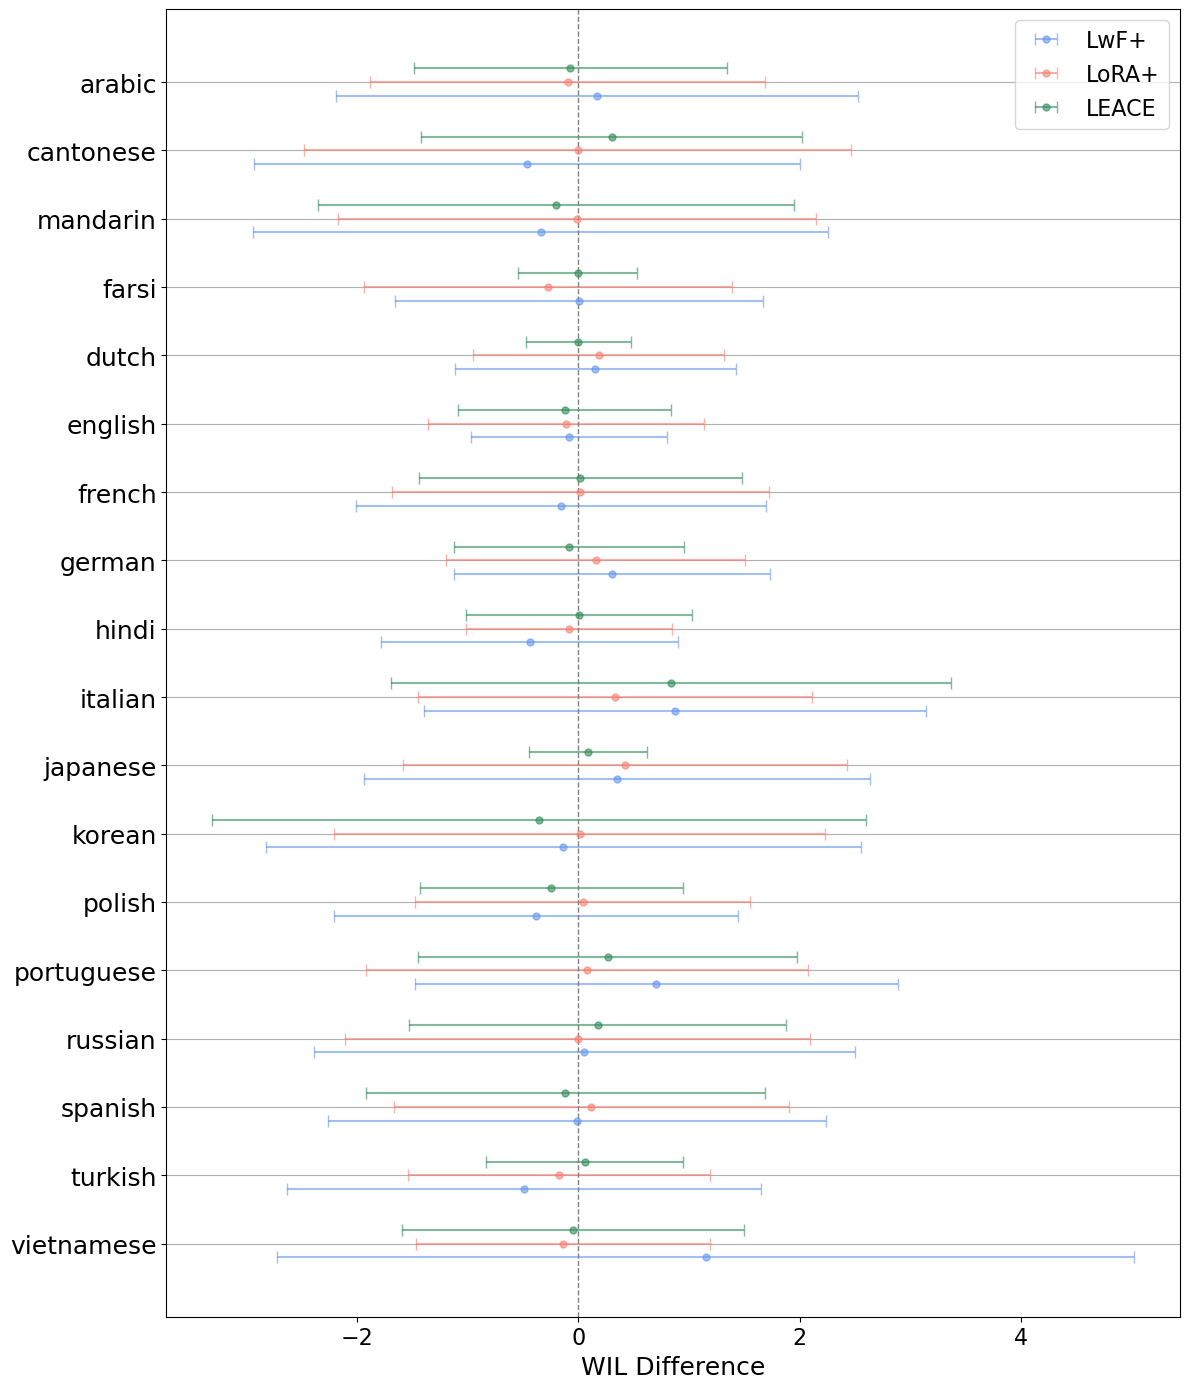

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_44136/2457833371.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


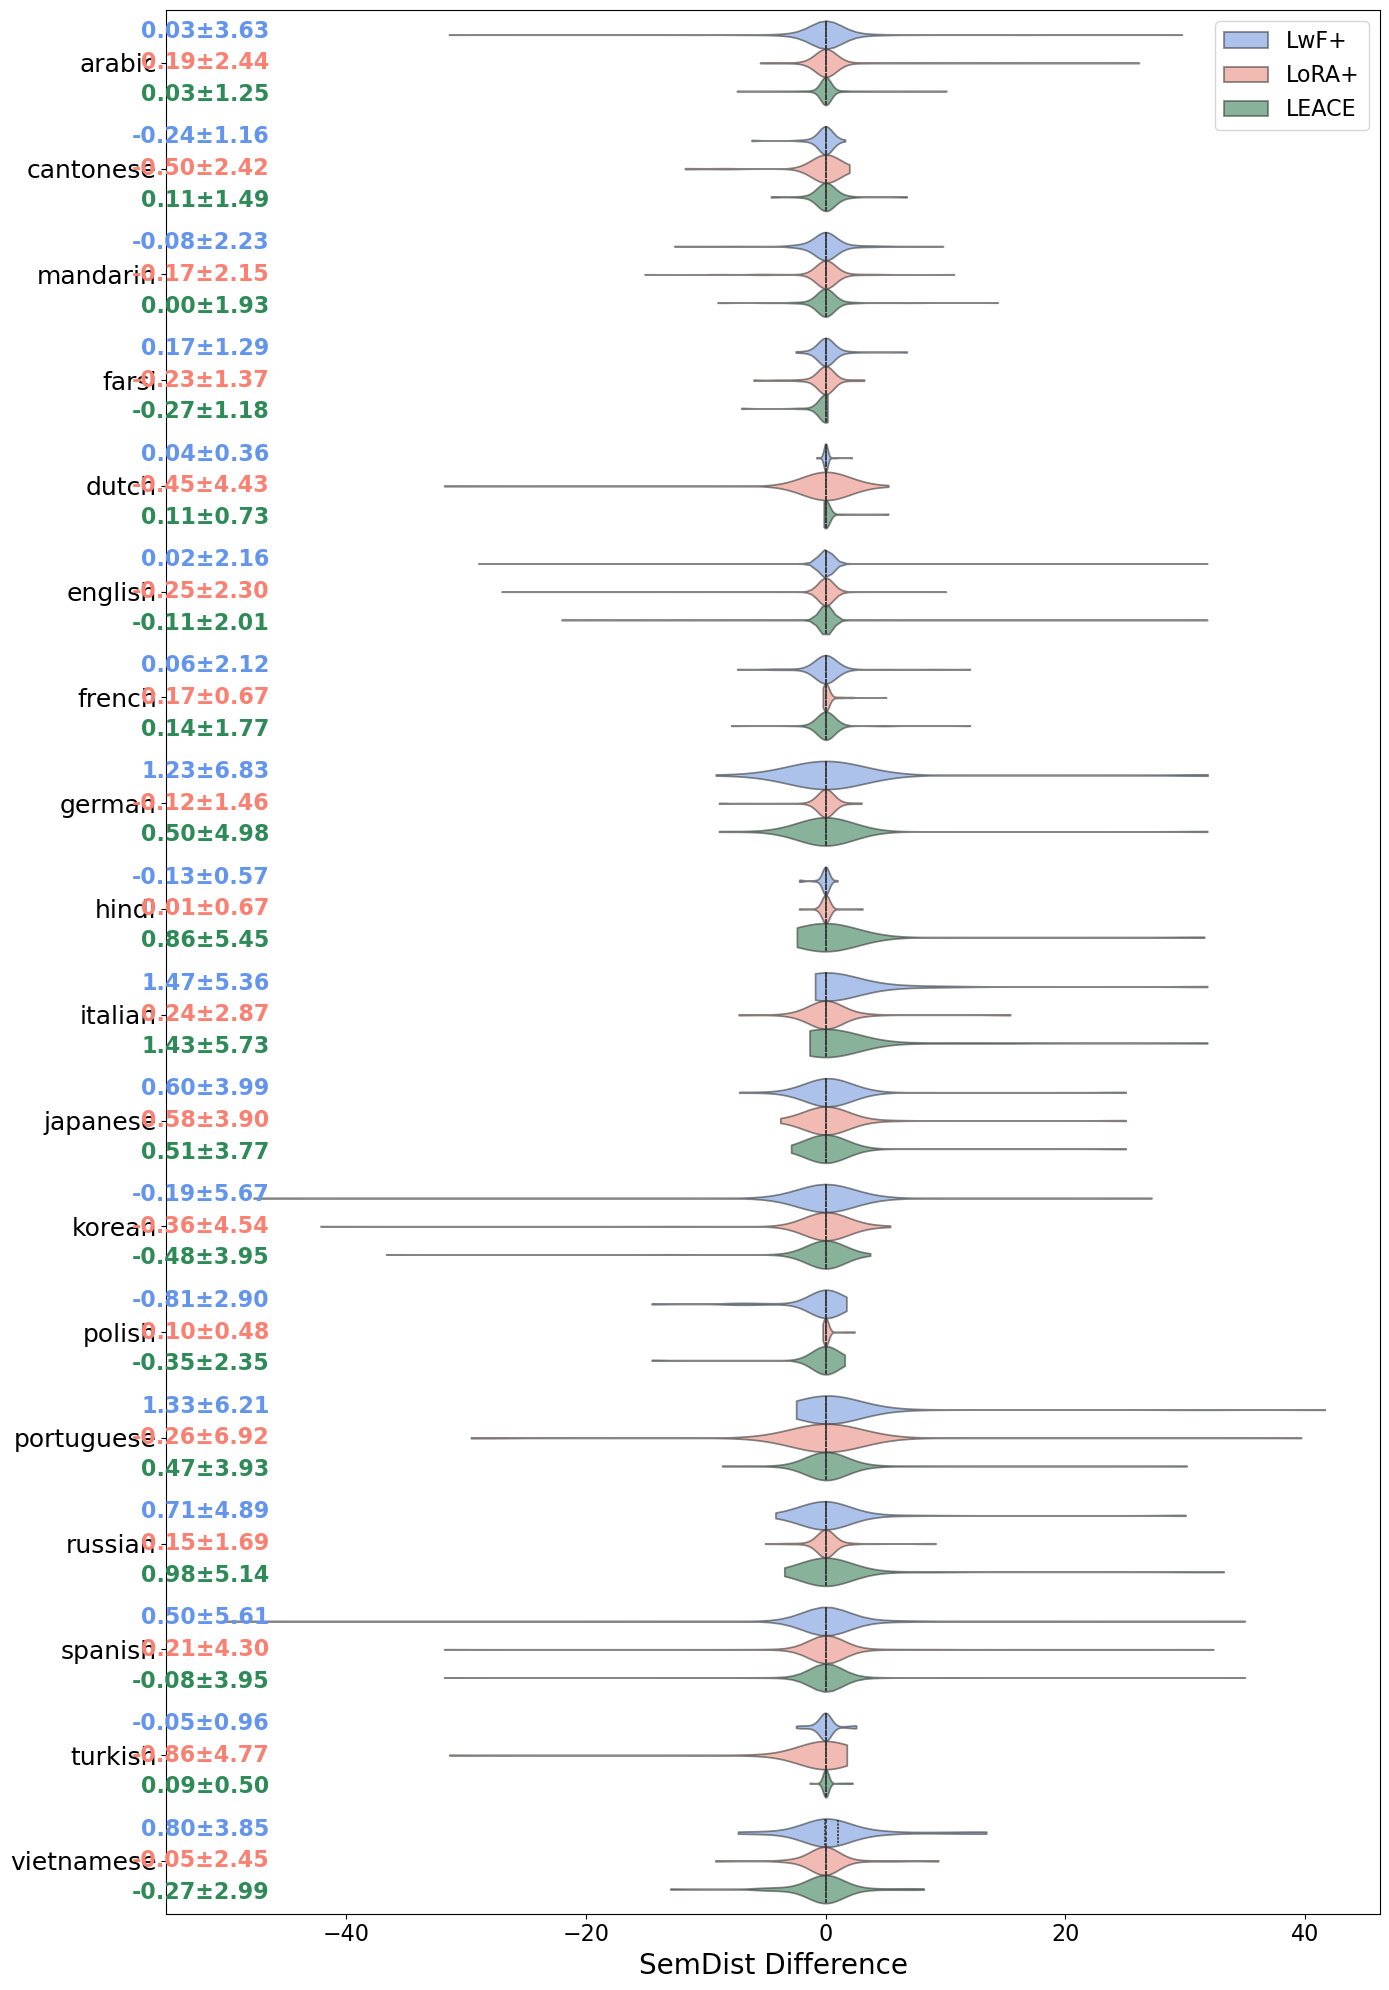

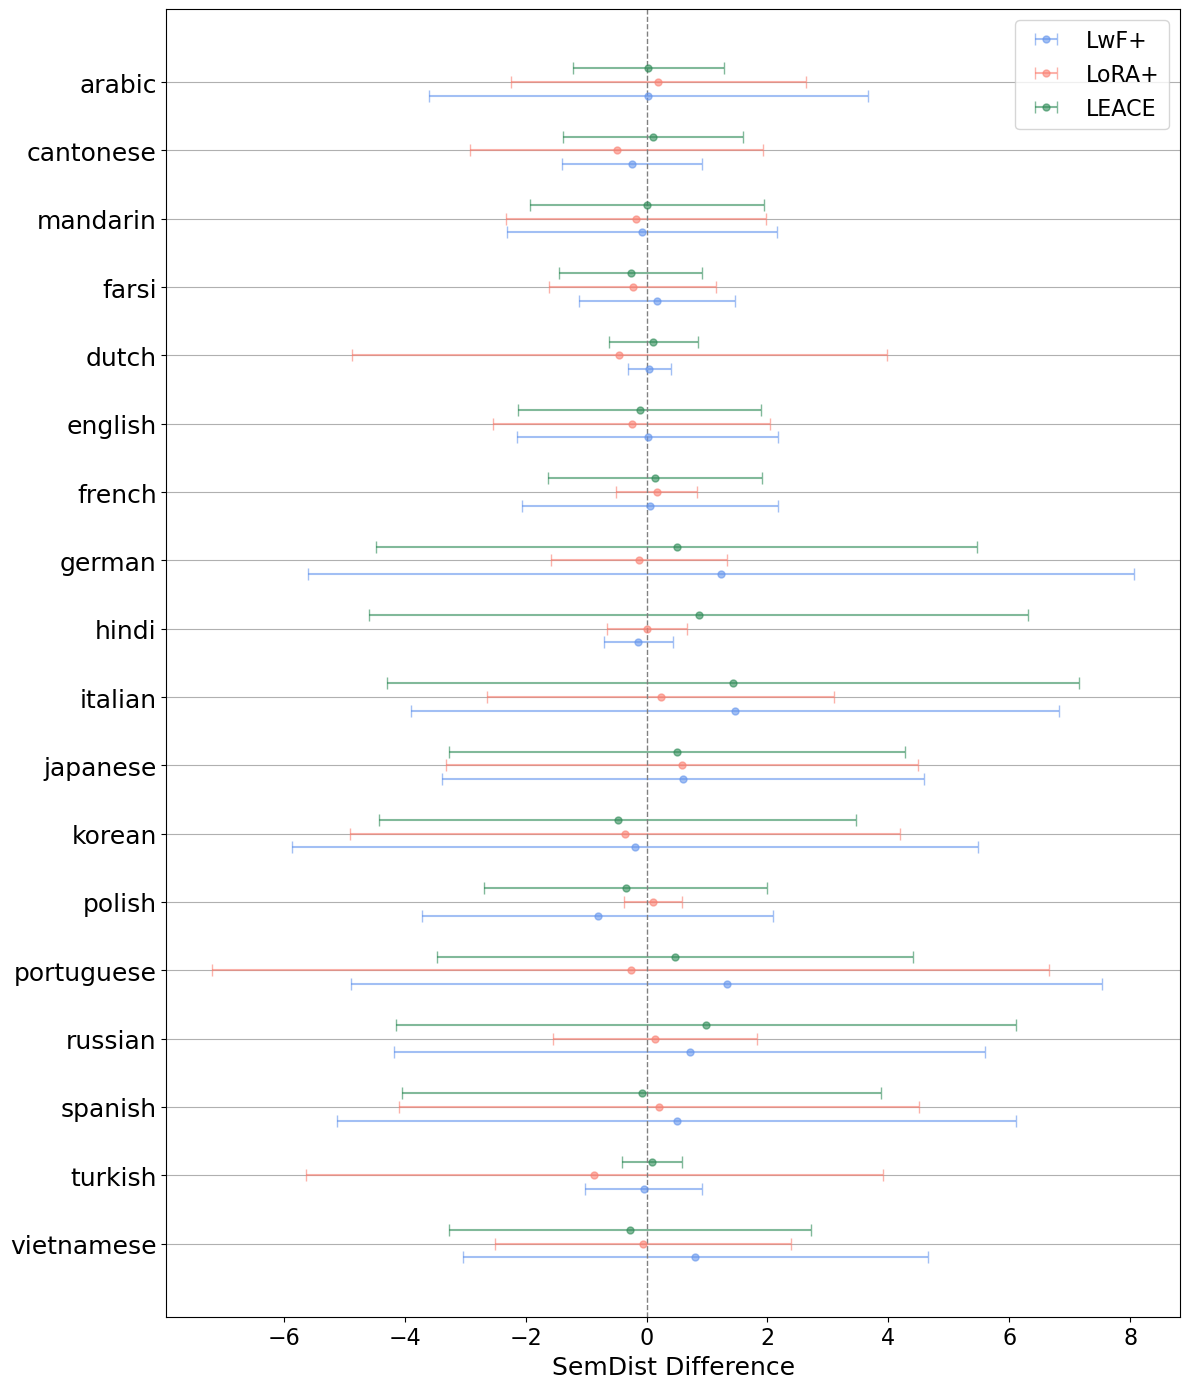

In [ ]:
def compute_improvement_raw(original_df, finetuned_df, metric, method_name):
    merged = pd.merge(
        original_df[["id", "native_language", metric]],
        finetuned_df[["id", metric]],
        on="id",
        suffixes=("_orig", "_fine")
    )
    merged = merged.dropna(subset=["native_language"])
    merged["diff"] = merged[f"{metric}_orig"] - merged[f"{metric}_fine"]
    merged["method"] = method_name
    return merged[["native_language", "diff", "method"]]
palette = {
    "LwF+": "cornflowerblue",
    "LoRA+": "salmon",
    "LEACE": "seagreen"
}
def violin(df_all):
    plt.figure(figsize=(14, 20))
    ax = sns.violinplot(
        data=df_all,
        x="diff",
        y="native_language",
        hue="method",
        palette=palette,
        cut=0,
        alpha=0.6,
        scale="width",
        inner="quartile"
    )

    # Compute stats
    stats = (
        df_all
        .groupby(["native_language", "method"])["diff"]
        .agg(["mean", "std"])
        .reset_index()
    )

    # Get language order used in the plot
    yticklabels = [t.get_text() for t in ax.get_yticklabels()]
    languages = yticklabels  # in top-to-bottom order

    methods = df_all["method"].unique()
    num_methods = len(methods)

    # Define offset for text position
    x_offset = df_all["diff"].min() + 0.08 * abs(df_all["diff"].min())

    for i, language in enumerate(languages):
        for j, method in enumerate(methods):
            row = stats[
                (stats["native_language"] == language) &
                (stats["method"] == method)
            ]
            if not row.empty:
                mean = row["mean"].values[0]
                std = row["std"].values[0]

                y_pos = i + 0.3 * (j - (num_methods - 1) / 2)

                plt.text(
                    x_offset, y_pos,
                    f"{mean:.2f}±{std:.2f}",
                    ha="right", va="center",
                    fontsize=16, color=palette[method],
                    weight="bold"
                )

    plt.yticks(size=18)
    plt.xticks(size=16)
    plt.xlabel(f"{metric} Difference", fontsize=20)
    plt.ylabel("", fontsize=18)
    plt.legend(fontsize=16, title_fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plot/finetune/compared/lora_lwf_leace_{metric}.pdf")
    plt.show()

def mean_std(df_all):
    plt.figure(figsize=(12, 14))
    
    # Compute means and stds
    mean_std = (
        df_all
        .groupby(["native_language", "method"])["diff"]
        .agg(["mean", "std"])
        .reset_index()
    )

    languages = df_all["native_language"].drop_duplicates().tolist()
    languages = languages[::-1]  
    methods = df_all["method"].unique()

    method_offsets = {method: i for i, method in enumerate(methods)}
    
    plotted_methods = set()

    # For each point, overlay mean ± std
    for i, language in enumerate(languages):
        for j, method in enumerate(methods):
            row = mean_std[
                (mean_std["native_language"] == language)
                & (mean_std["method"] == method)
            ]
            if not row.empty:
                mean = row["mean"].values[0]
                std = row["std"].values[0]
                y_pos = i + 0.2 * (j - (len(methods) - 1) / 2)
                label = method if method not in plotted_methods else None
                plotted_methods.add(method)
                plt.errorbar(
                    x=mean,
                    y=y_pos,
                    xerr=std,
                    fmt="o",
                    color=palette[method],
                    ecolor=palette[method],
                    alpha=0.6,
                    elinewidth=1.5,
                    capsize=4,
                    markersize=5,
                    label=label
                )

    # Manually set y-ticks
    plt.yticks(
        ticks=range(len(languages)),
        labels=languages
    )
    plt.axvline(x=0, color="grey", linestyle="--", linewidth=1)

    plt.grid(axis="y")
    plt.xlabel(f"{metric} Difference", fontsize=18)
    plt.ylabel("", fontsize=18)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.savefig(f"plot/finetune/compared/lora_lwf_leace_mean_std_{metric}.pdf")
    plt.tight_layout()
    plt.show()



for metric in ["WER", "WIL", "SemDist"]:
    all_improvements = []
    for df, label in zip(
        [df_lwf, df_lora, df_leace],
        ["LwF+", "LoRA+", "LEACE"]
    ):
        improvements = compute_improvement_raw(df_ori, df, metric=metric, method_name=label)
        all_improvements.append(improvements)

    # Combine into one DataFrame
    df_all = pd.concat(all_improvements, ignore_index=True)

    violin(df_all)
    mean_std(df_all)

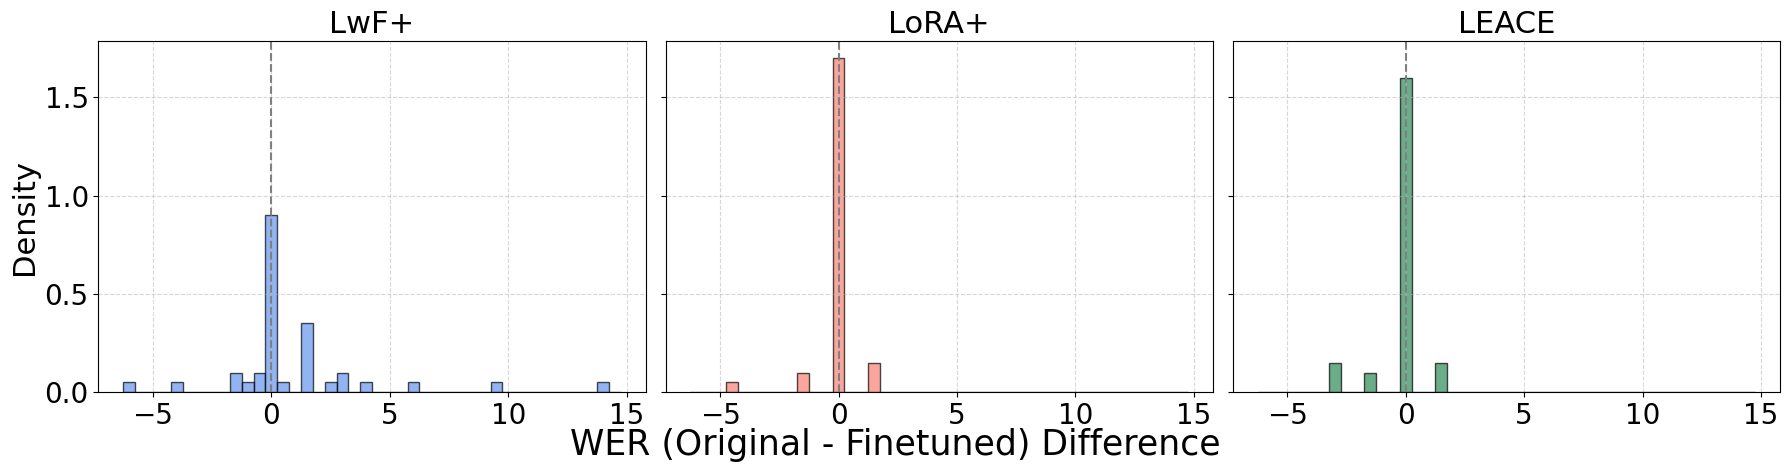

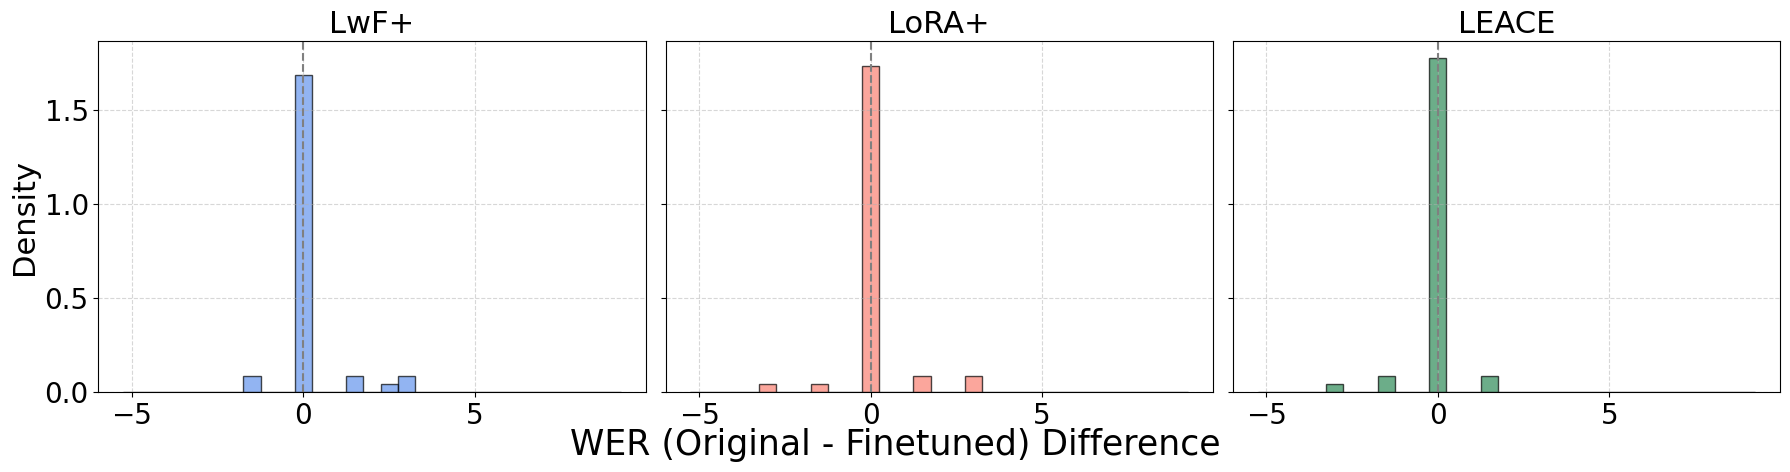

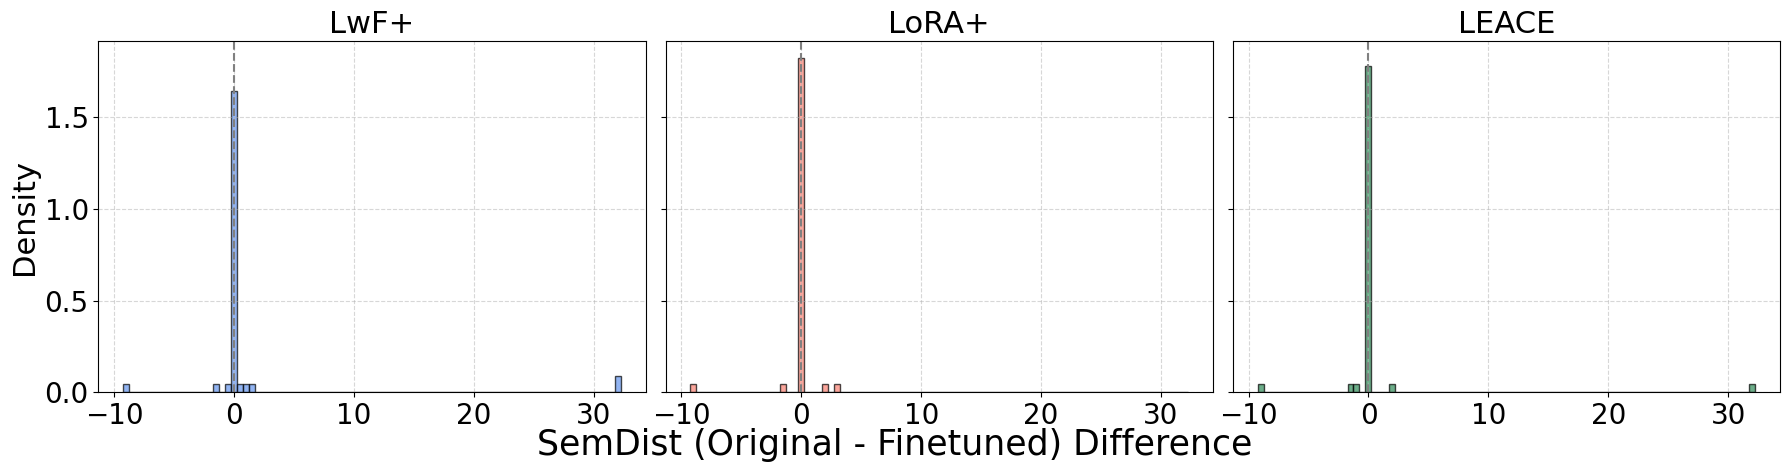

In [ ]:
def get_diffs(original_df, finetuned_df, language, metric="WER"):
    merged = pd.merge(
        original_df[["id", "native_language", metric]],
        finetuned_df[["id", metric]],
        on="id",
        suffixes=("_orig", "_fine")
    )
    # Filter English
    merged = merged[merged["native_language"] == language]
    # Compute diff per sample
    merged["diff"] = merged[f"{metric}_orig"] - merged[f"{metric}_fine"]
    return merged


metrics = ['WER']
for metric in metrics:
    for lan in ["vietnamese"]:
        # Get diffs
        diffs_lwf = get_diffs(df_ori, df_lwf, lan, metric)
        diffs_lora = get_diffs(df_ori, df_lora, lan,metric)
        diffs_leace = get_diffs(df_ori, df_leace, lan,metric)
        bin_width = 0.5
        min_edge = np.floor(-6.25 / bin_width) * bin_width
        max_edge = np.ceil(10 / bin_width) * bin_width
        bins = np.arange(-6.25, 15, 0.5)

        # Plot distributions
        # Example for one language and one metric
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
        # Define methods and diffs in order
        methods = [
            ("LwF+", diffs_lwf, "cornflowerblue"),
            ("LoRA+", diffs_lora, "salmon"),
            ("LEACE", diffs_leace, "seagreen")
        ]

        for ax, (label, diffs, color) in zip(axes, methods):
            ax.hist(
                diffs["diff"],
                bins=bins,
                alpha=0.7,
                color=color,
                edgecolor="black",
                density=True
            )
            ax.axvline(0, color="gray", linestyle="--")
            ax.set_title(label, fontsize=22)
            # ax.set_xlabel(f"{metric}\nImprovement", fontsize=12)
            ax.grid(True, linestyle="--", alpha=0.5)
            ax.tick_params(axis="both", labelsize=20)

        axes[0].set_ylabel("Density", fontsize=22)

        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        fig.text(0.5, 0.03, f"{metric} (Original - Finetuned) Difference", fontsize=25, ha='center')

        plt.savefig(f"plot/finetune/distribution/Distribution_{lan}_{metric}_subplots.pdf")
        plt.show()

metrics = ['WER', 'SemDist']
Range = [[-5.25, 9.75], [-9.25, 32.75]]
for i, metric in enumerate(metrics):
    for lan in ["german"]:
        diffs_lwf = get_diffs(df_ori, df_lwf, lan, metric)
        diffs_lora = get_diffs(df_ori, df_lora, lan,metric)
        diffs_leace = get_diffs(df_ori, df_leace, lan,metric)

        bin_width = 0.5
        min_edge = np.floor(Range[i][0] / bin_width) * bin_width
        max_edge = np.ceil(Range[i][1] / bin_width) * bin_width
        bins = np.arange(Range[i][0], Range[i][1], 0.5)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
        # Define methods and diffs in order
        methods = [
            ("LwF+", diffs_lwf, "cornflowerblue"),
            ("LoRA+", diffs_lora, "salmon"),
            ("LEACE", diffs_leace, "seagreen")
        ]

        for ax, (label, diffs, color) in zip(axes, methods):
            ax.hist(
                diffs["diff"],
                bins=bins,
                alpha=0.7,
                color=color,
                edgecolor="black",
                density=True
            )
            ax.axvline(0, color="gray", linestyle="--")
            ax.set_title(label, fontsize=22)
            ax.grid(True, linestyle="--", alpha=0.5)
            ax.tick_params(axis="both", labelsize=20)

        axes[0].set_ylabel("Density", fontsize=22)

        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        fig.text(0.5, 0.03, f"{metric} (Original - Finetuned) Difference", fontsize=25, ha='center')
        plt.savefig(f"plot/finetune/distribution/Distribution_{lan}_{metric}_subplots.pdf")
        plt.show()


## Ablation Study

In [8]:
result_small = pd.merge(output_df, saa_df,   on='id', how="left")
script_df = pd.read_csv('results/baseline/small.csv')
result_lwf = pd.merge(script_df , result_small,   on='id', how="left")
result_lwf['group'] = result_lwf['native_language'].apply(lambda x: 1 if x == 'english' else 2)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


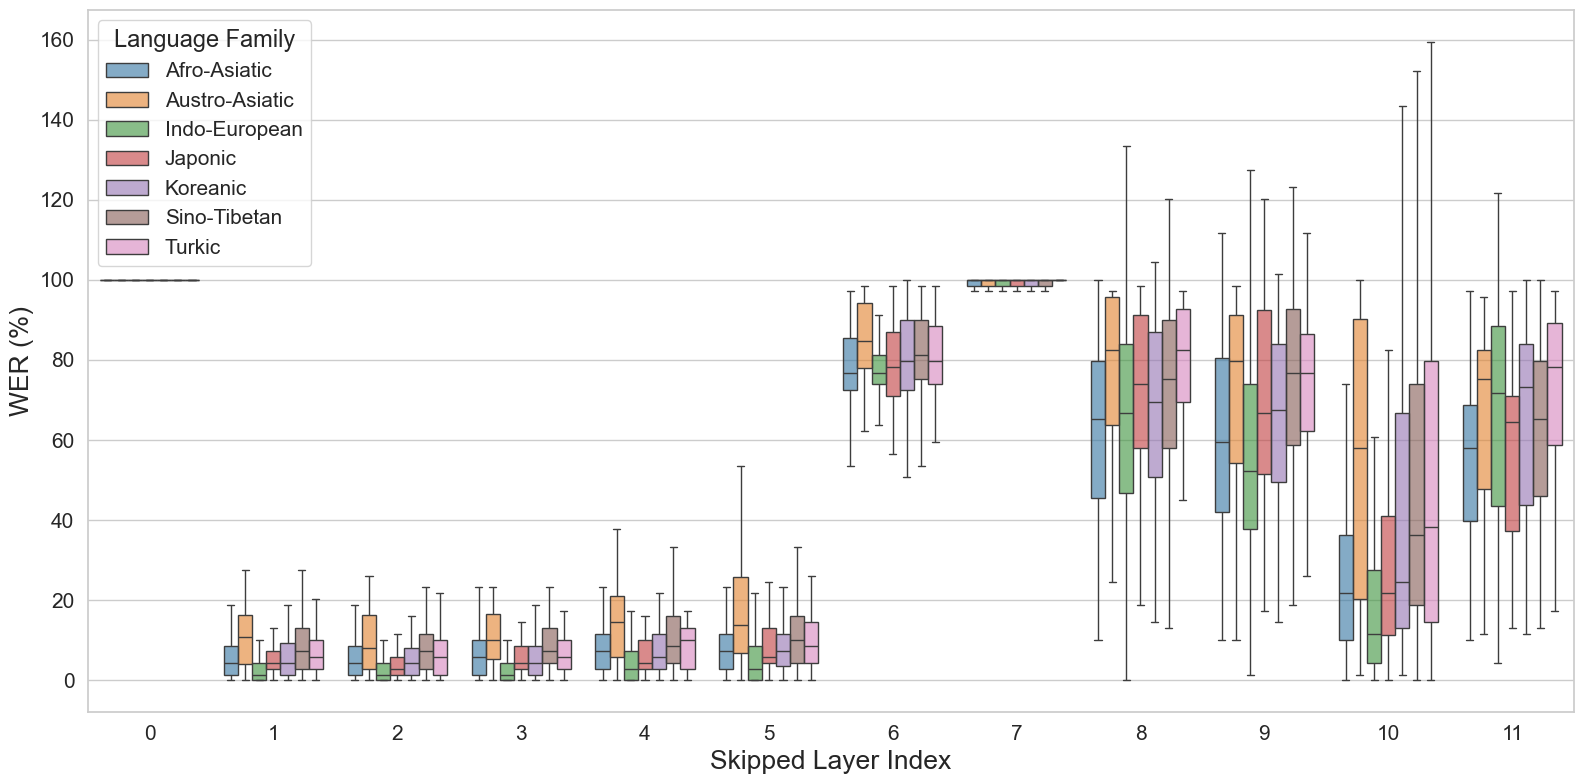

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


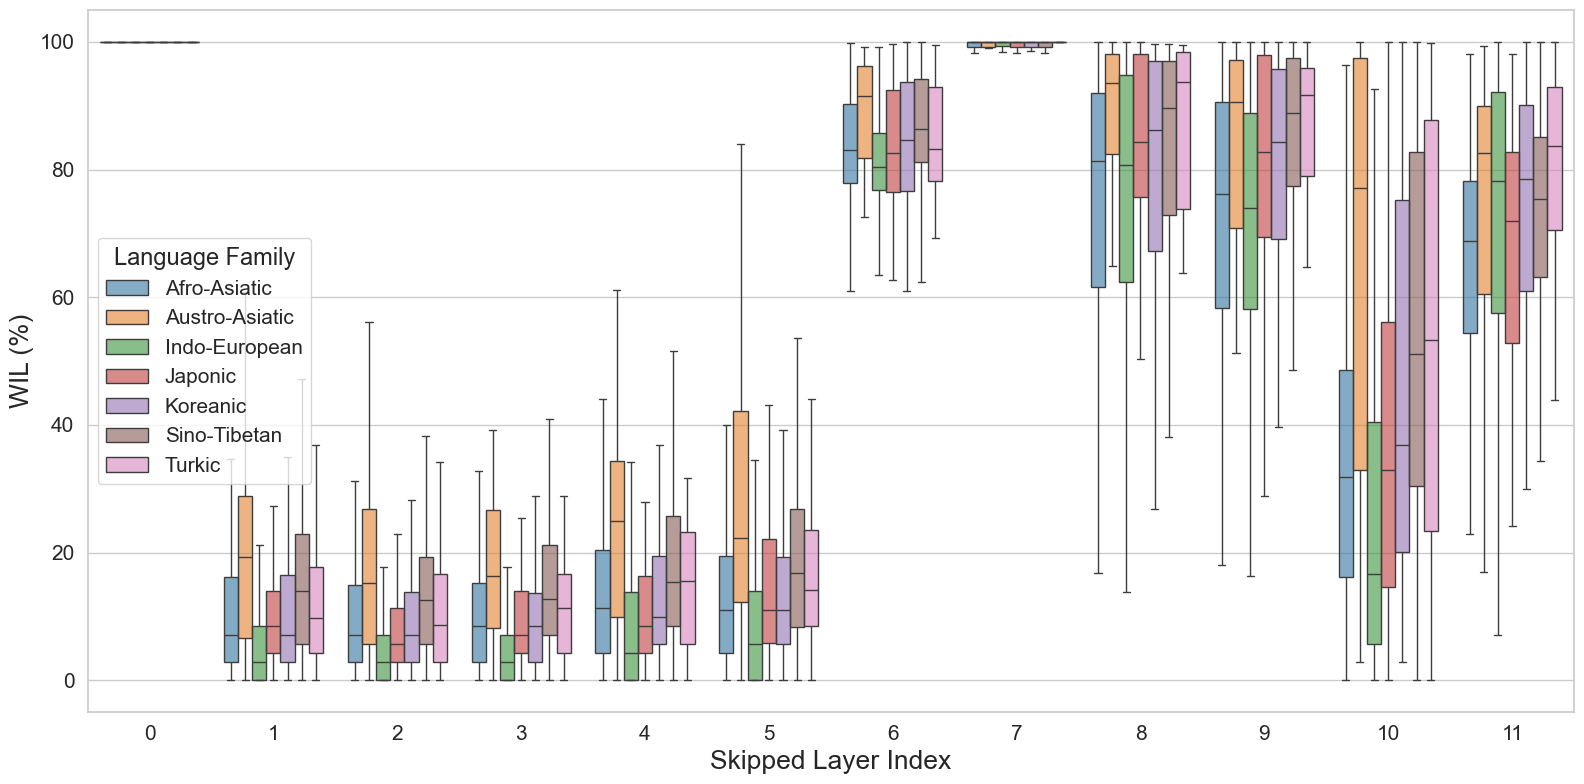

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


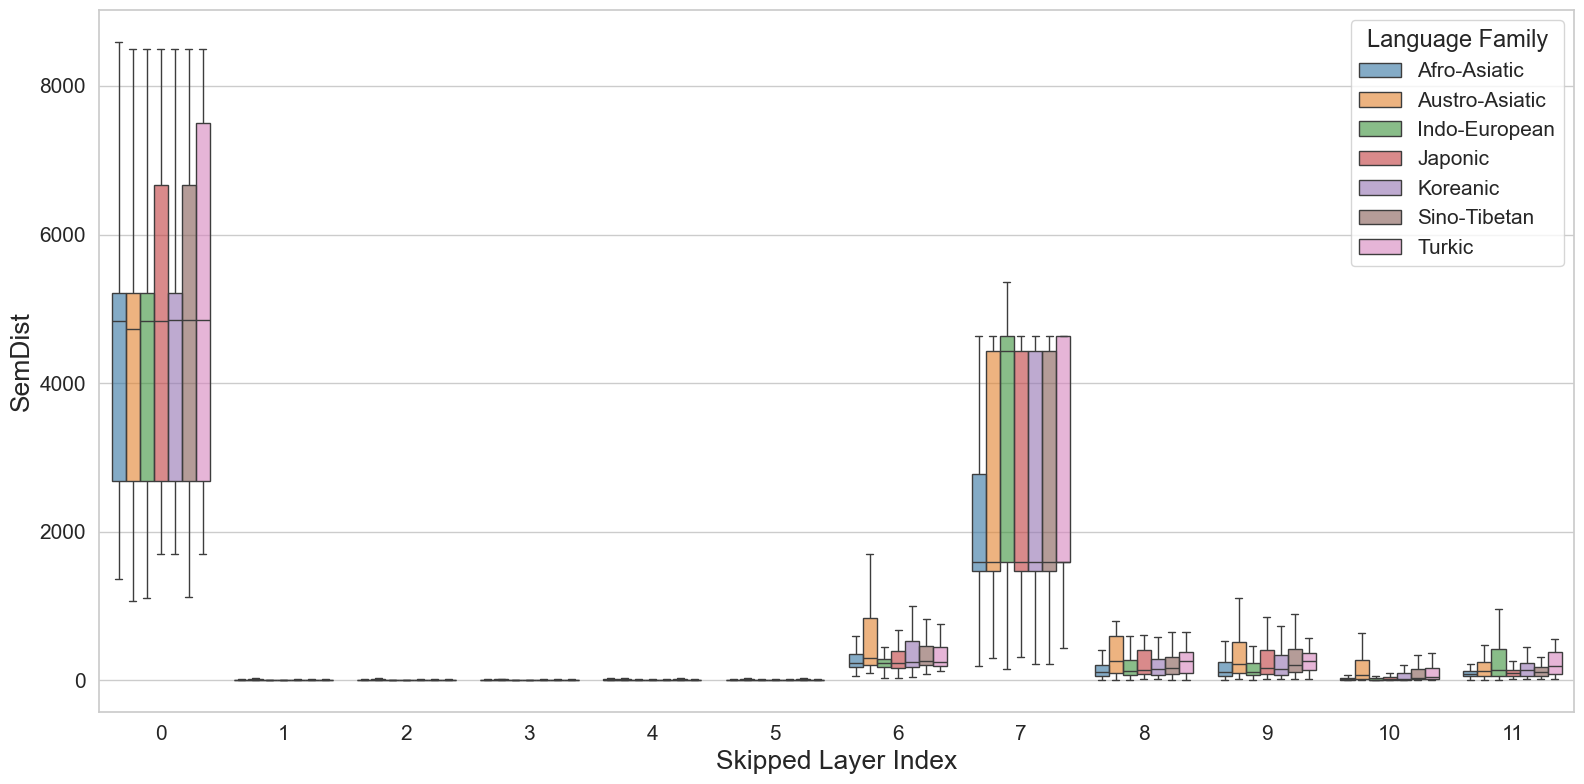

In [13]:
# ------------------------
# Load evaluation files
# ------------------------
def load_eval_files(folder, model_name):
    files = sorted(glob.glob(os.path.join(folder, "eval*.csv")))
    dfs = []
    for f in files:
        layer_str = os.path.splitext(os.path.basename(f))[0]
        layer_num = int(layer_str.split("_")[-1].replace("layer", ""))
        df = pd.read_csv(f)
        df["LayerNum"] = layer_num
        df["Model"] = model_name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load dataset
df_baseline = load_eval_files("results/ablation/small", "Baseline")

# Combine (if you had more models, you could concat them here)
df_ablation = df_baseline.copy()

# Map accents to language families
df_ablation["Language_Family"] = df_ablation["Accent"].map(language_family_dict)

# Define colors
all_families = sorted(df_ablation["Language_Family"].dropna().unique())
palette_families = sns.color_palette("tab10", n_colors=len(all_families))
family_colors = dict(zip(all_families, palette_families))

# ------------------------
# Prepare DataFrame for plotting
# ------------------------
# For each family, collect per-sample WIL (no aggregation)
all_dfs = []
for family in all_families:
    df_family = df_ablation[df_ablation["Language_Family"] == family]
    df_family = df_family.copy()
    df_family["Language_Family"] = family
    all_dfs.append(df_family)

df_plot = pd.concat(all_dfs, ignore_index=True)

for metric in ["WER", "WIL", "SemDist"]:
    if metric != "SemDist":
        text = f"{metric} (%)"
    else:
        text = metric
    # ------------------------
    # Create boxplot
    # ------------------------
    plt.figure(figsize=(16, 8))
    sns.set(style="whitegrid")

    # Main boxplot
    ax = sns.boxplot(
        data=df_plot,
        x="LayerNum",
        y=metric,
        hue="Language_Family",
        palette=family_colors,
        showfliers=False
    )

    # Set alpha for each box
    for patch in ax.patches:
        color = patch.get_facecolor()
        patch.set_facecolor(mcolors.to_rgba(color, alpha=0.6))

    # Remove duplicated legends
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Language Family", fontsize=15, title_fontsize=17)

    # Labels and styling
    plt.xlabel("Skipped Layer Index", fontsize=19)
    plt.ylabel(text, fontsize=19)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()

    # Save
    plt.savefig(f"plot/ablation/ablation_layer_pretrained_{metric}.pdf")
    plt.show()


In [14]:
def paired_test_by_family_and_layer(df_all, model_name):
    """
    Performs per-layer, per-language-family paired tests comparing Baseline to model_name.
    """
    results = []

    df_base = df_all[df_all["Model"] == "Baseline"]
    df_model = df_all[df_all["Model"] == model_name]

    layers = sorted(df_all["LayerNum"].unique())
    for layer in layers:
        df_base_layer = df_base[df_base["LayerNum"] == layer]
        df_model_layer = df_model[df_model["LayerNum"] == layer]

        merged = pd.merge(
            df_base_layer[["id", "WIL"]],
            df_model_layer[["id", "WIL"]],
            on="id",
            suffixes=("_baseline", "_model")
        )
        if merged.empty:
            continue

        diffs = merged["WIL_baseline"] - merged["WIL_model"]

        if len(diffs) < 3:
            # Too few samples to test
            continue

        # Normality test
        shapiro_p = shapiro(diffs).pvalue
        is_normal = shapiro_p > 0.05

        # Paired test
        if is_normal:
            test_res = ttest_rel(merged["WIL_baseline"], merged["WIL_model"])
            test_name = "Paired t-test"
        else:
            test_res = wilcoxon(merged["WIL_baseline"], merged["WIL_model"])
            test_name = "Wilcoxon signed-rank"

        result = {
            "Layer": layer,
            "Normal": is_normal,
            "Test": test_name,
            "Statistic": test_res.statistic,
            "p_value": test_res.pvalue,
            "Significant": bool(test_res.pvalue < 0.05)
        }
        results.append(result)

    return pd.DataFrame(results)

# ------------------------
# Load evaluation files
# ------------------------
def load_eval_files(folder, model_name):
    files = sorted(glob.glob(os.path.join(folder, "eval*.csv")))
    dfs = []
    for f in files:
        layer_str = os.path.splitext(os.path.basename(f))[0]
        layer_num = int(layer_str.split("_")[-1].replace("layer", ""))
        df = pd.read_csv(f)
        df["LayerNum"] = layer_num
        df["Model"] = model_name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load datasets
df_baseline = load_eval_files("results/ablation/small", "Baseline")
df_lora = load_eval_files("results/ablation/lora", "LoRA")
df_lwf = load_eval_files("results/ablation/lwf", "LWF")
df_leace = load_eval_files("results/ablation/leace", "LEACE")

# Combine all
df_all = pd.concat([df_baseline, df_lora, df_lwf, df_leace], ignore_index=True)

# Map accents to language families
df_all["Language_Family"] = df_all["Accent"].map(language_family_dict)

# Define colors (one per language family)
all_families = sorted(df_all["Language_Family"].unique())
palette_families = sns.color_palette("tab10", n_colors=len(all_families))
family_colors = dict(zip(all_families, palette_families))


df_lora_tests = paired_test_by_family_and_layer(df_all, "LoRA")
df_lwf_tests = paired_test_by_family_and_layer(df_all, "LWF")
df_leace_tests = paired_test_by_family_and_layer(df_all, "LEACE")
print("=== LoRA ===")
print(df_lora_tests)
print("\n=== LWF ===")
print(df_lwf_tests)
print("\n=== LEACE ===")
print(df_leace_tests)


=== LoRA ===
    Layer  Normal                  Test  Statistic       p_value  Significant
0       0   False  Wilcoxon signed-rank        3.0  2.770276e-03         True
1       1   False  Wilcoxon signed-rank    26890.5  2.137487e-01        False
2       2   False  Wilcoxon signed-rank    19910.0  5.920850e-01        False
3       3   False  Wilcoxon signed-rank    27272.5  7.617626e-01        False
4       4   False  Wilcoxon signed-rank    56124.5  3.640466e-01        False
5       5   False  Wilcoxon signed-rank    65117.0  6.137041e-05         True
6       6   False  Wilcoxon signed-rank   478420.0  2.321434e-01        False
7       7   False  Wilcoxon signed-rank    13115.5  8.890781e-07         True
8       8   False  Wilcoxon signed-rank   254902.5  3.986767e-08         True
9       9   False  Wilcoxon signed-rank   546735.5  3.546322e-22         True
10     10   False  Wilcoxon signed-rank   175517.0  3.339997e-17         True
11     11   False  Wilcoxon signed-rank    43150.0 

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


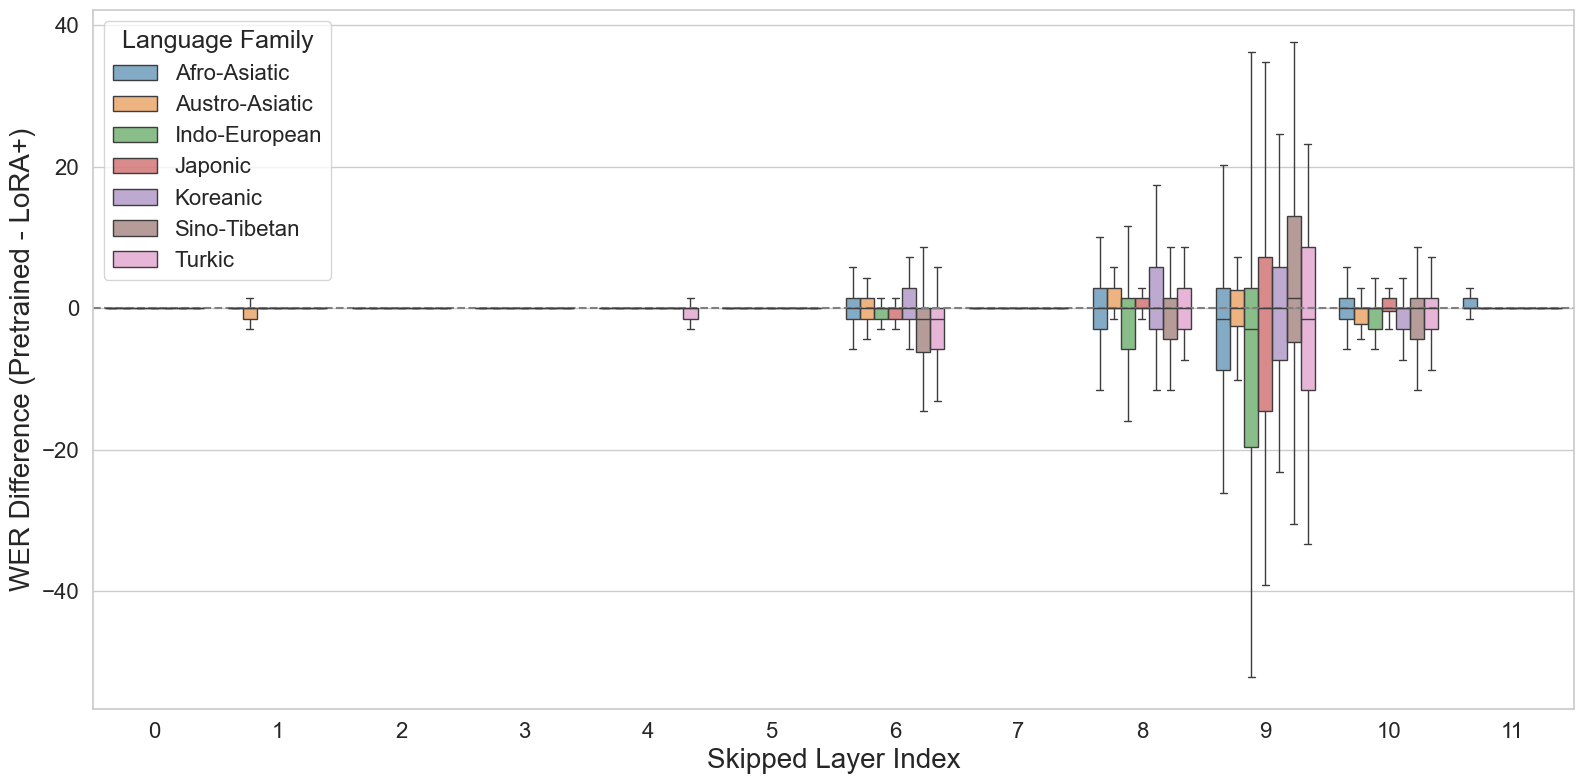

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


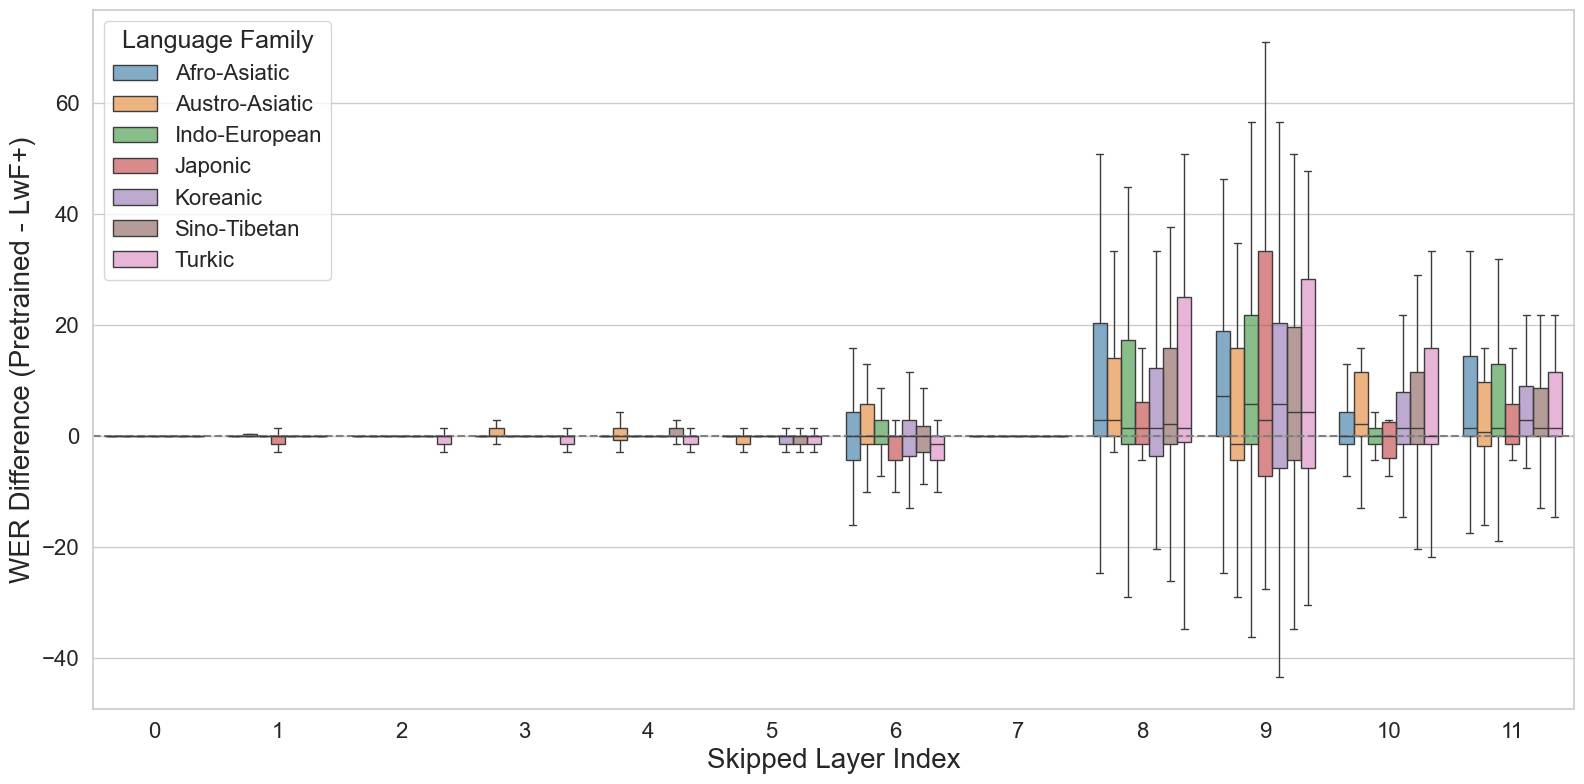

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


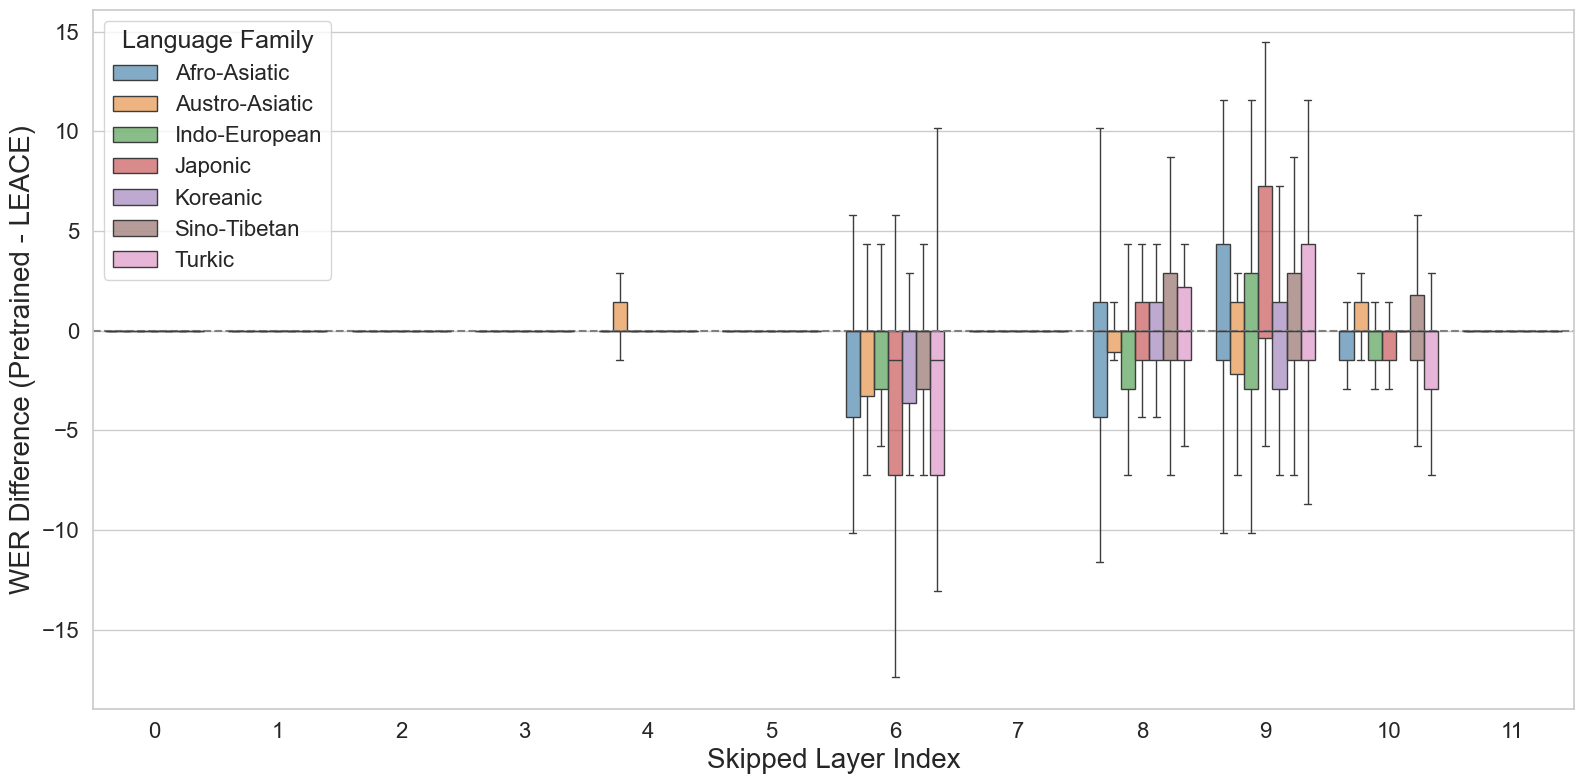

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


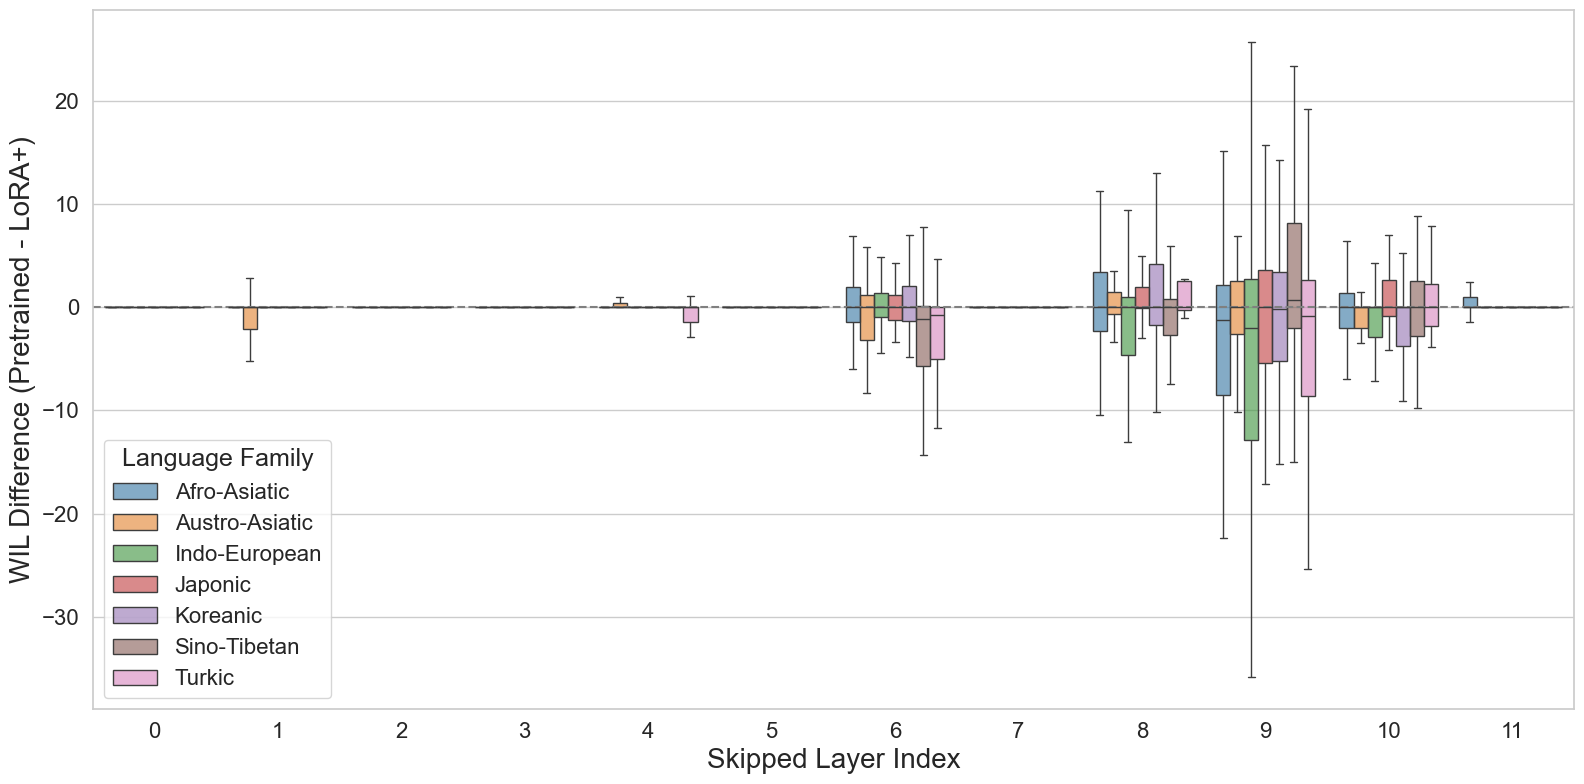

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


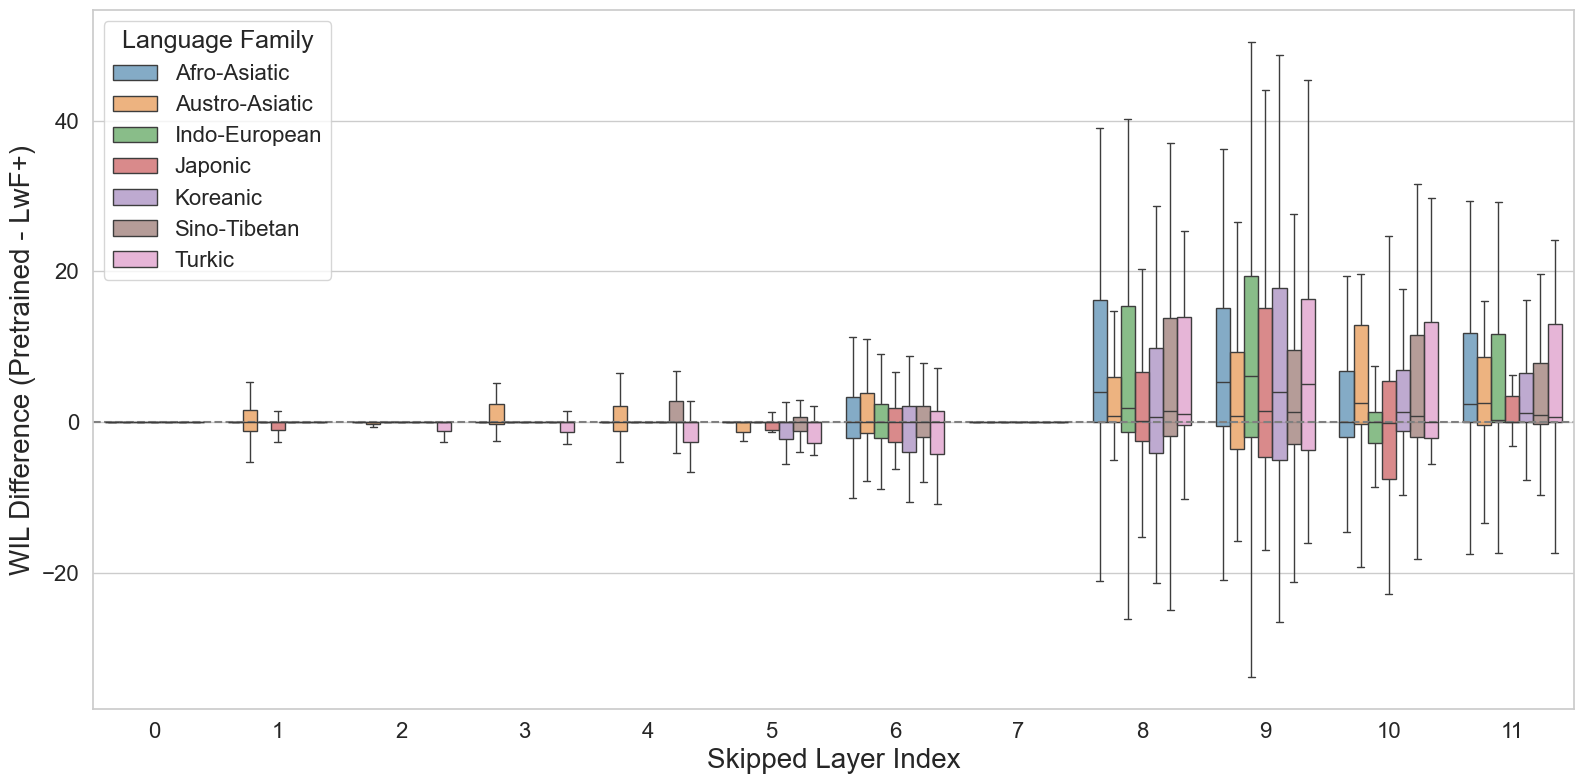

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


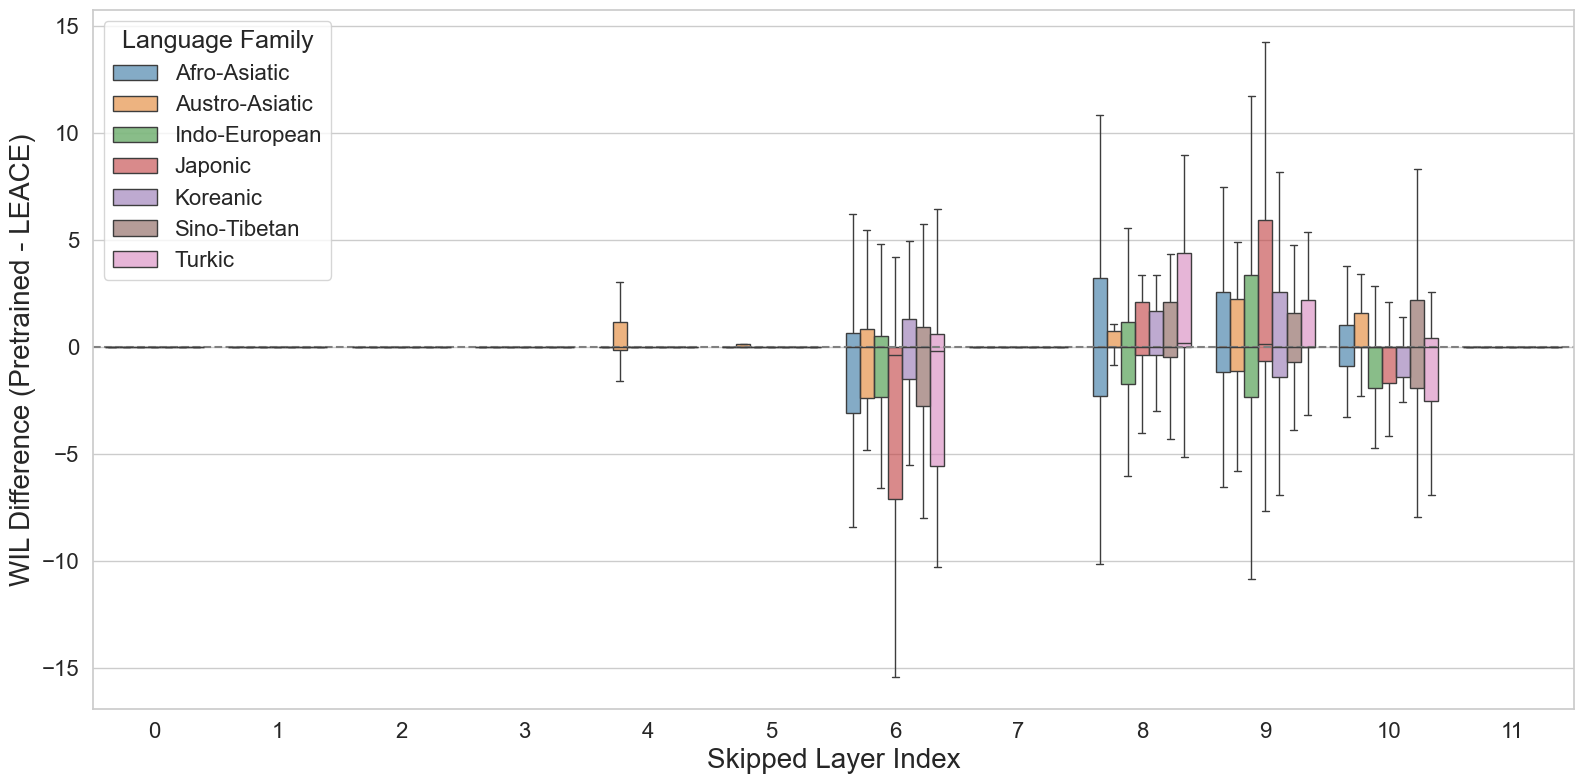

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


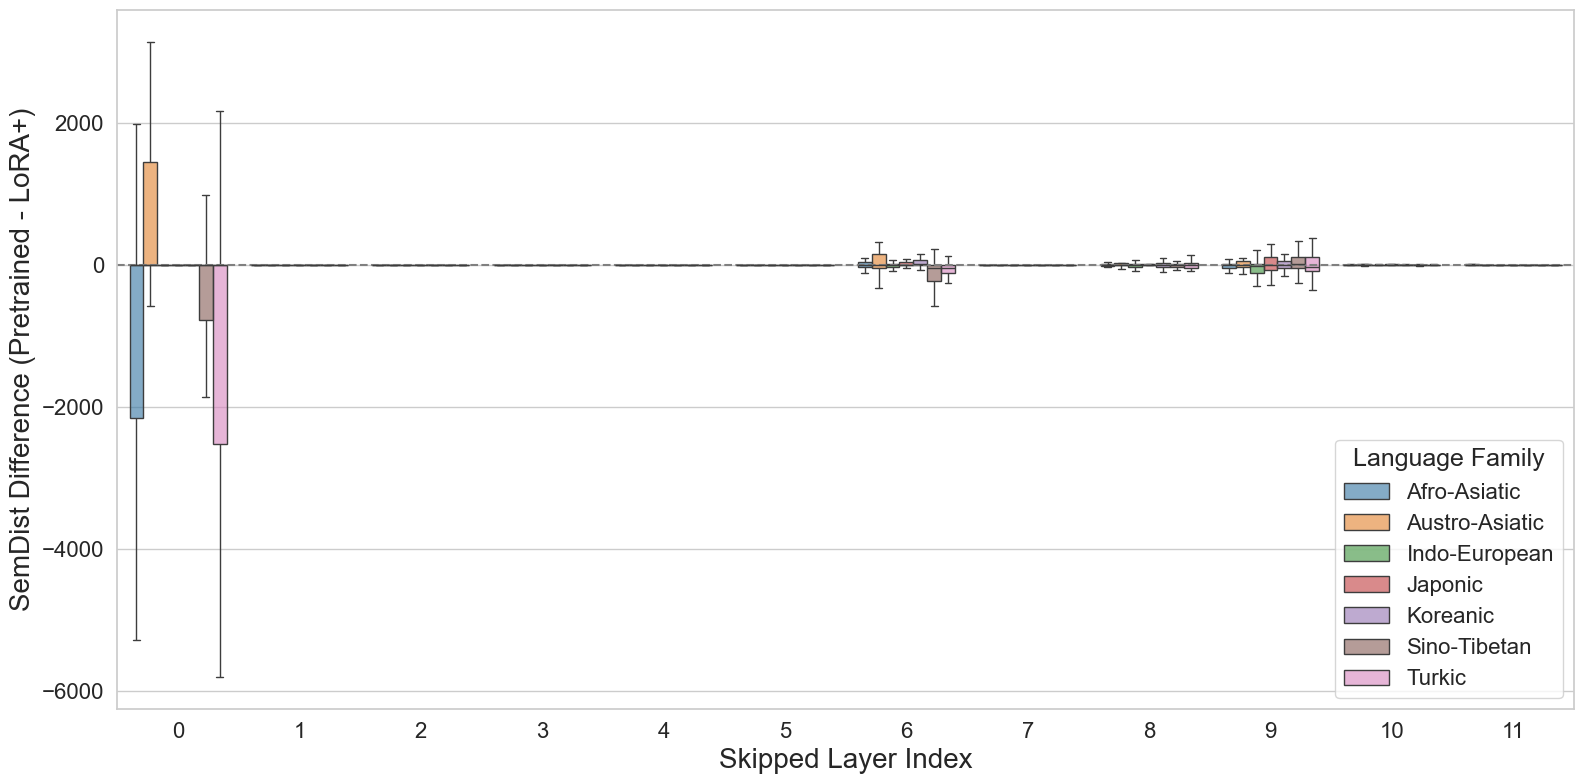

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


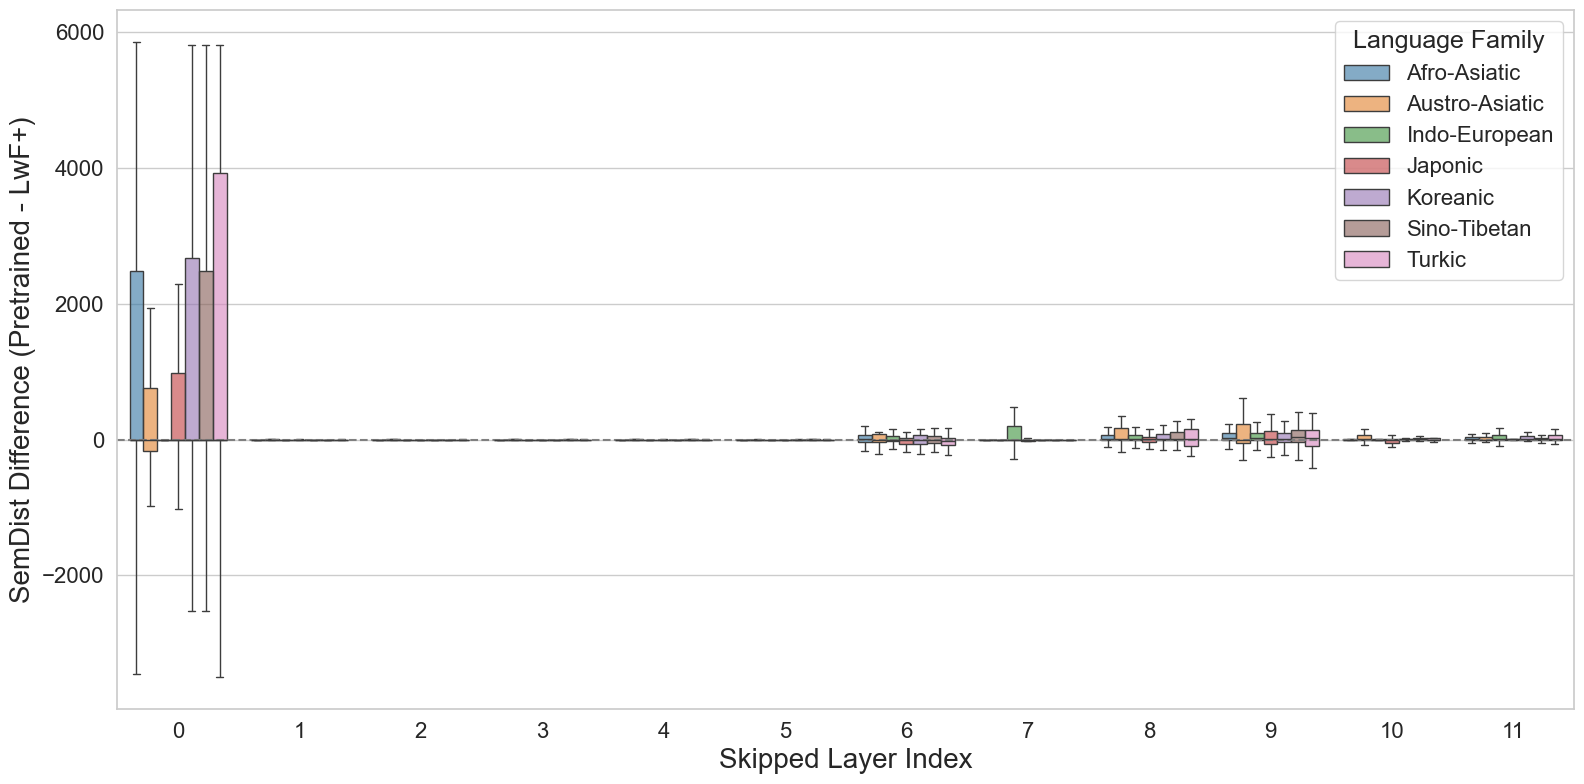

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


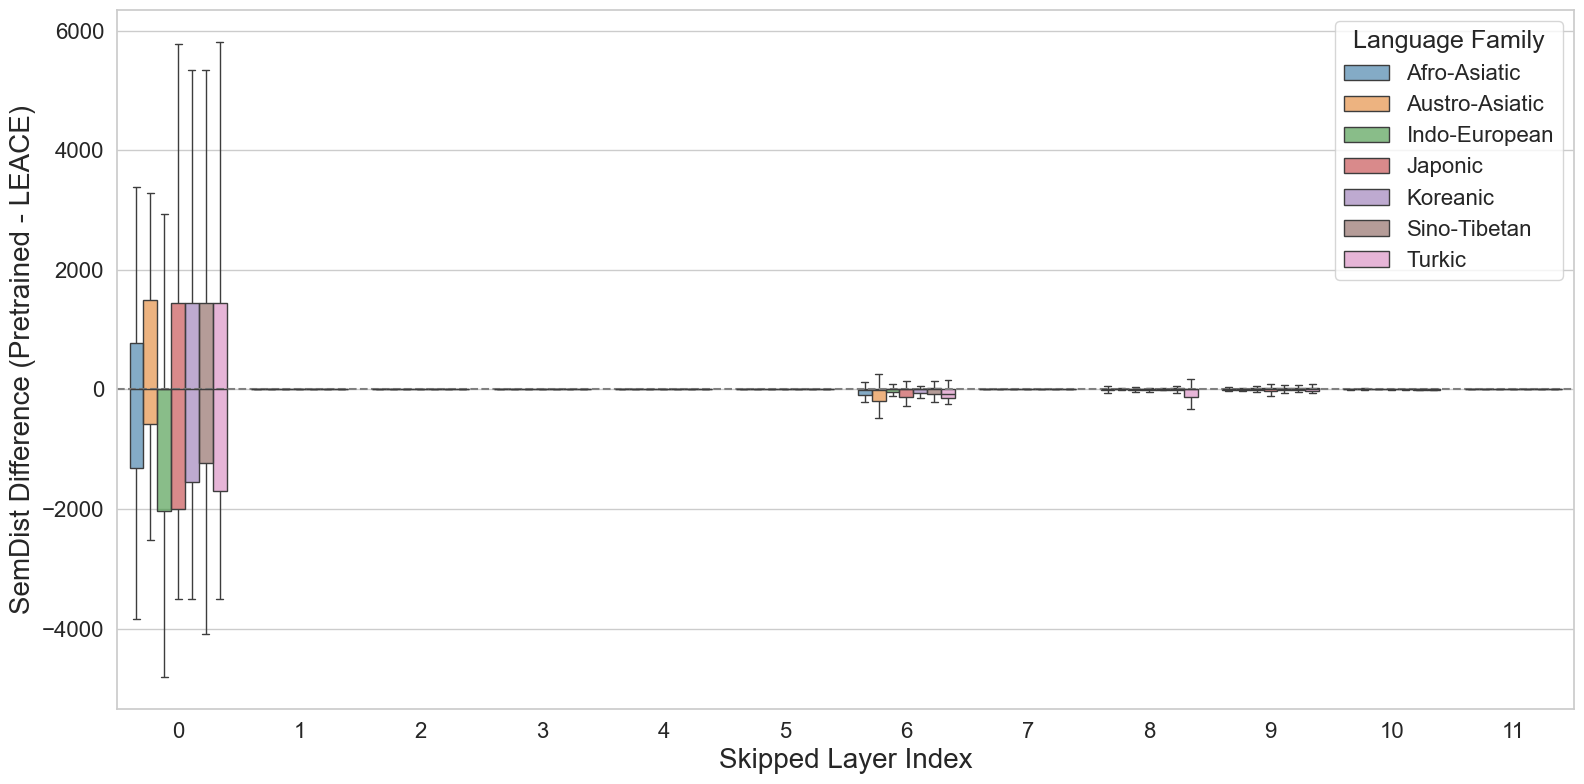

In [15]:
# ------------------------
# Loop over models
# ------------------------
for metric in ["WER", "WIL", "SemDist"]:
    for model in ["LoRA", "LWF", "LEACE"]:
        all_dfs = []

        # For each language family
        for family in all_families:
            df_family = df_all[df_all["Language_Family"] == family]
            df_base = df_family[df_family["Model"] == "Baseline"]
            df_model = df_family[df_family["Model"] == model]

            # Merge baseline and model per-sample for paired diffs
            merged = pd.merge(
                df_base[["id", "LayerNum", metric]],
                df_model[["id", "LayerNum", metric]],
                on=["id", "LayerNum"],
                suffixes=("_baseline", "_model")
            )

            # Compute paired diff
            merged["Diff"] = merged[f"{metric}_baseline"] - merged[f"{metric}_model"]
            merged["Language_Family"] = family
            all_dfs.append(merged)

        # Combine all families
        df_plot = pd.concat(all_dfs, ignore_index=True)
        df_plot = df_plot.sort_values(["LayerNum", "Language_Family"]).reset_index(drop=True)

        # ------------------------
        # Box plot
        # ------------------------
        plt.figure(figsize=(16, 8))
        sns.set(style="whitegrid")

        ax = sns.boxplot(
            data=df_plot,
            x="LayerNum",
            y="Diff",
            hue="Language_Family",
            palette=family_colors,
            showfliers=False
        )

        # Set alpha for each box
        for patch in ax.patches:
            color = patch.get_facecolor()
            patch.set_facecolor(mcolors.to_rgba(color, alpha=0.6))

        # Remove duplicated legends (from stripplot)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(),
            by_label.keys(),
            title="Language Family",
            fontsize=16,
            title_fontsize=18
        )
        if model == 'LoRA':
            text = f"{metric} Difference (Pretrained - LoRA+)"
        elif model == 'LWF':
            text = f"{metric} Difference (Pretrained - LwF+)"
        else:
            text = f"{metric} Difference (Pretrained - {model})"

        # Styling
        plt.axhline(0, color="gray", linestyle="--")
        plt.xlabel("Skipped Layer Index", fontsize=20)
        plt.ylabel(text, fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        plt.savefig(f"plot/ablation/ablation_layer_{model}_{metric}.pdf")
        plt.show()


In [27]:
transcript = 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'
script_df = pd.read_csv('results/baseline/small.csv')
script_lora_df = pd.read_csv('results/lora_best.csv')
script_lwf_df = pd.read_csv('results/lwf_best.csv')
script_leace_df = pd.read_csv('results/leace.csv')

print("==============Vietnamese40 Before===============")
preds = [EnglishTextNormalizer()(script_df[script_df['id']=='vietnamese40']['prediction'].values[0]) ]
scripts = [EnglishTextNormalizer()(transcript)]
removed, added, replaced = get_word_diffs(scripts[0], preds[0])

print(preds)
print("Removed", removed)
print("Added", added)
print("Replaced", replaced)

print("==============Vietnamese40 After===============")
preds = [EnglishTextNormalizer()(script_lwf_df[script_df['id']=='vietnamese40']['prediction'].values[0]) ]
scripts = [EnglishTextNormalizer()(transcript)]
removed, added, replaced = get_word_diffs(scripts[0], preds[0])
print(preds)
print("Removed", removed)
print("Added", added)
print("Replaced", replaced)

print("==============German31 Before===============")
preds = [EnglishTextNormalizer()(script_df[script_df['id']=='german31']['prediction'].values[0]) ]
scripts = [EnglishTextNormalizer()(transcript)]
removed, added, replaced = get_word_diffs(scripts[0], preds[0])
print(preds)
print("Removed", removed)
print("Added", added)
print("Replaced", replaced)

print("==============German31 After===============")
preds = [EnglishTextNormalizer()(script_lwf_df[script_lwf_df['id']=='german31']['prediction'].values[0]) ]
scripts = [EnglishTextNormalizer()(transcript)]
removed, added, replaced = get_word_diffs(scripts[0], preds[0])
print(preds)
print("Removed", removed)
print("Added", added)
print("Replaced", replaced)

print("==============German19 Before===============")
preds = [EnglishTextNormalizer()(script_df[script_df['id']=='german19']['prediction'].values[0]) ]
scripts = [EnglishTextNormalizer()(transcript)]
removed, added, replaced = get_word_diffs(scripts[0], preds[0])
print(preds)
print("Removed", removed)
print("Added", added)
print("Replaced", replaced)

print("==============German19 After===============")
preds = [EnglishTextNormalizer()(script_leace_df[script_leace_df['id']=='german19']['prediction'].values[0]) ]
scripts = [EnglishTextNormalizer()(transcript)]
removed, added, replaced = get_word_diffs(scripts[0], preds[0])
print(preds)
print("Removed", removed)
print("Added", added)
print("Replaced", replaced)

==============Vietnamese40 Before===============
['we call the seller ask her for the ring this thing with the hers from the store 6 spoons of the fresh snow peas 5 takes of the slab upper blue cheese and maybe a snack for her brother bob we also need a small plate of this knee and a big toy for the key she can scoot this thing into the 3 red bags and we will go meet her on wednesday at the train station']
Removed ['frog']
Added ['the', 'the', 'slab', 'upper', 'the', 'on']
Replaced [(['please'], ['we']), (['stella'], ['the', 'seller']), (['to', 'bring', 'these', 'things'], ['for', 'the', 'ring', 'this', 'thing']), (['her'], ['the', 'hers']), (['thick', 'slabs'], ['takes']), (['plastic', 'snake'], ['plate', 'of', 'this', 'knee']), (['kids'], ['key']), (['scoop', 'these', 'things'], ['scoot', 'this', 'thing'])]
==============Vietnamese40 After===============
['recall the cellar ask her to bring this thing with her from the store 6 spoon of the fresh snow peas 5 take slabs of the blue che

In [ ]:
# Load the Original results
df_ori = pd.read_csv("results/baseline/eva_small.csv")
df_ori = pd.merge(df_ori, saa_df, on="id", how="left")

# Load the Finetune-LWF results
df_Adap_Part_lwf = pd.read_csv("results/eva_lwf2.csv")
df_Adap_Part_lwf = pd.merge(df_Adap_Part_lwf, saa_df, on="id", how="left")

# Load the Finetune-LWF results
df_Adap_Part = pd.read_csv("results/eva_lwf_adapter_nolwf.csv")
df_Adap_Part = pd.merge(df_Adap_Part, saa_df, on="id", how="left")

df_Part_lwf = pd.read_csv("results/eva_lwf_base.csv")
df_Part_lwf = pd.merge(df_Part_lwf, saa_df, on="id", how="left")

df_Part = pd.read_csv("results/eva_lwf_base_without.csv")
df_Part = pd.merge(df_Part, saa_df, on="id", how="left")

# Load the Finetune-LoRA results
df_Adap_lora = pd.read_csv("results/eva_lora.csv")
df_Adap_lora = pd.merge(df_Adap_lora, saa_df, on="id", how="left")

# Load the Finetune-LoRA results
df_lora = pd.read_csv("results/eva_lora_base.csv")
df_lora = pd.merge(df_lora, saa_df, on="id", how="left")

# Load the Finetune-LEACE results
df_leace = pd.read_csv("results/eva_leace_11.csv")
df_leace = pd.merge(df_leace, saa_df, on="id", how="left")

from scipy.stats import ttest_ind
native_ori = result_small[result_small["native_language"] == 'english']['WER']

from scipy.stats import ttest_ind, mannwhitneyu


metrics = ["WER", "WIL", "SemDist"]

methods = {
    "Original": df_ori,
    "Adapter+Partial+LwF": df_Adap_Part_lwf,
    "Partial+LwF": df_Part_lwf,
    "Adapter+Partial": df_Adap_Part,
    "Partial": df_Part,
    "Adapter+LoRA": df_Adap_lora,
    "LoRA": df_lora,
    "LEACE": df_leace
}

rows = []
for metric in metrics:
    for method_name, df in methods.items():

        # Merge Original and method on ID
        merged = pd.merge(
            df_ori[["id", metric]],
            df[["id", metric]],
            on="id",
            suffixes=("_orig", "_method")
        ).dropna()
        # Select Native and Non-native subsets
        native = df[df["native_language"].str.lower() == "english"][metric]
        nonnative = df[df["native_language"].str.lower() != "english"][metric]
        
        # Compute means and stds
        native_mean = native.mean()
        nonnative_mean = nonnative.mean()
        native_std = native.std()
        nonnative_std = nonnative.std()
        diff = nonnative_mean - native_mean
        
        test_name = None
        test = None
        statistic = None
        shapiro_p = None
        if method_name != "Original":
            diffs = merged[f"{metric}_orig"] - merged[f"{metric}_method"]
            # Normality test
            shapiro_p = shapiro(diffs).pvalue
            is_normal = shapiro_p > 0.05

            # Paired test
            if is_normal:
                test = ttest_rel(merged[f"{metric}_orig"], merged[f"{metric}_method"]).plave
                statistic = ttest_rel(merged[f"{metric}_orig"], merged[f"{metric}_method"]).statistic
                test_name = "Paired t-test"
            else:
                test = wilcoxon(merged[f"{metric}_orig"], merged[f"{metric}_method"]).pvalue
                statistic = wilcoxon(merged[f"{metric}_orig"], merged[f"{metric}_method"]).statistic
                test_name = "Wilcoxon signed-rank"



        # Append row
        rows.append({
            "Method": method_name,
            "Metric": metric,
            "Native Mean": native_mean,
            "Native Std": native_std,
            "Non-native Mean": nonnative_mean,
            "Non-native Std": nonnative_std,
            "Mean Diff (Non-native - Native)": diff, 
            "Normality p": shapiro_p,
            "Test": test_name,
            "Statistic": statistic,
            "p-value": test
        })

# Convert to DataFrame
comparison_df = pd.DataFrame(rows)

# Show the table
comparison_df = comparison_df.round(3)
comparison_df


Method   Metric  Native Mean  Native Std  Non-native Mean  \
0              Original      WER        1.177       2.474            5.263   
1   Adapter+Partial+LwF      WER        1.202       2.376            5.152   
2           Partial+LwF      WER        1.370       2.827            5.236   
3       Adapter+Partial      WER        2.162       3.520            7.851   
4               Partial      WER        2.247       3.970            8.069   
5          Adapter+LoRA      WER        1.283       2.728            5.243   
6                  LoRA      WER        1.679       2.991            6.545   
7                 LEACE      WER        1.296       2.798            5.274   
8              Original      WIL        1.836       3.837            8.680   
9   Adapter+Partial+LwF      WIL        1.921       3.904            8.639   
10          Partial+LwF      WIL        2.068       4.100            8.598   
11      Adapter+Partial      WIL        3.524       5.581           13.070   
12              Partial      WIL        3.617       5.910           13.301   
13         Adapter+LoRA      WIL        1.949       4.096            8.652   
14                 LoRA      WIL        2.641       4.546           10.816   
15                LEACE      WIL        1.960       4.094            8.710   
16             Original  SemDist        1.545       4.700            6.548   
17  Adapter+Partial+LwF  SemDist        1.525       4.613            6.262   
18          Partial+LwF  SemDist        1.808       5.236            6.339   
19      Adapter+Partial  SemDist        2.113       4.799            7.785   
20              Partial  SemDist        2.464       7.157            8.278   
21         Adapter+LoRA  SemDist        1.794       5.290            6.565   
22                 LoRA  SemDist        2.147       5.903            7.542   
23                LEACE  SemDist        1.658       4.835            6.419   

    Non-native Std  Mean Diff (Non-native - Native)  Normality p  \
0            7.282                            4.086          NaN   
1            6.703                            3.950          0.0   
2            7.209                            3.866          0.0   
3            8.073                            5.689          0.0   
4            8.638                            5.822          0.0   
5            7.163                            3.960          0.0   
6            7.525                            4.865          0.0   
7            7.352                            3.978          0.0   
8           10.762                            6.845          NaN   
9           10.646                            6.718          0.0   
10          10.714                            6.530          0.0   
11          12.336                            9.547          0.0   
12          12.636                            9.684          0.0   
13          10.700                            6.703          0.0   
14          11.302                            8.175          0.0   
15          10.924                            6.750          0.0   
16          10.692                            5.003          NaN   
17          10.429                            4.737          0.0   
18          10.438                            4.531          0.0   
19          11.742                            5.673          0.0   
20          14.048                            5.814          0.0   
21          10.481                            4.772          0.0   
22          11.599                            5.394          0.0   
23          10.747                            4.760          0.0   

                    Test  Statistic  p-value  
0                   None        NaN      NaN  
1   Wilcoxon signed-rank   184953.0    0.045  
2   Wilcoxon signed-rank    51842.0    0.377  
3   Wilcoxon signed-rank    65425.5    0.000  
4   Wilcoxon signed-rank    62705.0    0.000  
5   Wilcoxon signed-rank    17832.0    0.719  
6   Wilcoxon signed-rank    73409.0 

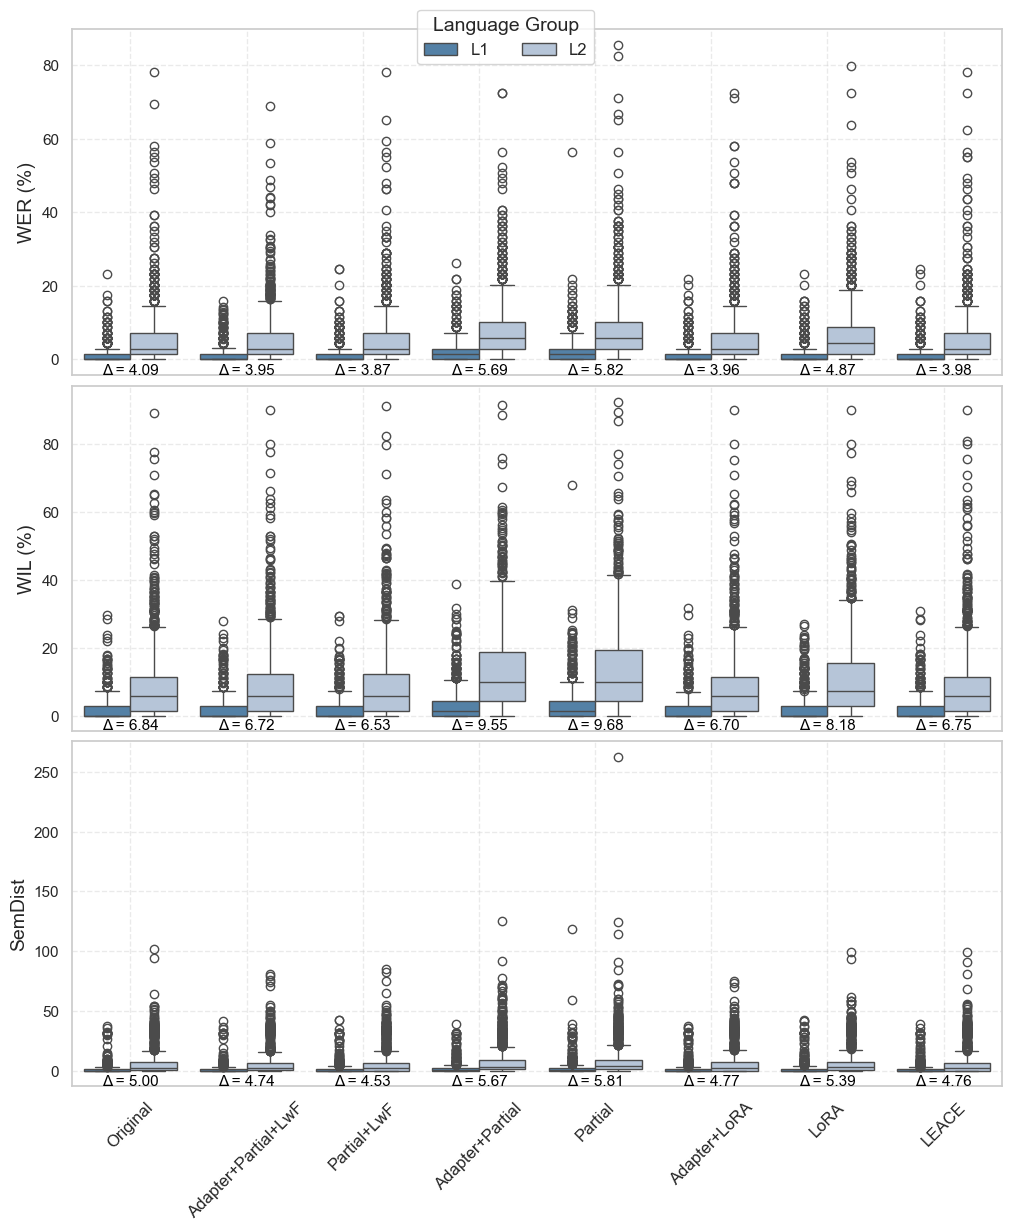

In [ ]:
palette = {
    "L1": "steelblue",
    "L2": "lightsteelblue"
}
records = []

# Loop through each method and metric
for method_name, df in methods.items():
    for metric in metrics:
        for is_native, group in zip([True, False], ["L1", "L2"]):
            subset = df[
                df["native_language"].str.lower().eq("english") if is_native else ~df["native_language"].str.lower().eq("english")
            ]
            for value in subset[metric].dropna():
                records.append({
                    "Method": method_name,
                    "Metric": metric,
                    "Language_Group": group,
                    "Value": value
                })

plot_df = pd.DataFrame(records)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True, constrained_layout=True)

method_order = list(methods.keys())
metrics = ["WER", "WIL", "SemDist"]

for ax, metric in zip(axes, metrics):
    if metric != "SemDist":
        text = f"{metric} (%)"
    else:
        text = metric
    data = plot_df[plot_df["Metric"] == metric]
    
    # Draw boxplot
    sns.boxplot(
        data=data,
        x="Method",
        y="Value",
        hue="Language_Group",
        palette=palette,
        dodge=True,
        ax=ax,
        showfliers=True
    )
    
    ax.set_ylabel(text, fontsize=14)
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45, labelsize=12)
    ax.grid(True, linestyle="--", alpha=0.4)
    
    # Compute means for delta annotations
    means = (
        data.groupby(["Method", "Language_Group"])["Value"]
        .mean()
        .reset_index()
    )
    
    # For each method, compute L1 and L2 mean difference
    for i, method in enumerate(method_order):
        try:
            l1_mean = means[(means["Method"] == method) & (means["Language_Group"] == "L1")]["Value"].values[0]
        except IndexError:
            l1_mean = None
        try:
            l2_mean = means[(means["Method"] == method) & (means["Language_Group"] == "L2")]["Value"].values[0]
        except IndexError:
            l2_mean = None
        
        if l1_mean is not None and l2_mean is not None:
            delta = l2_mean - l1_mean
            y_pos = -5
            if metric == 'SemDist':
                y_pos = -15
            # X position: center between the L1 and L2 boxes
            ax.text(
                i,
                y_pos,
                f"Δ = {delta:.2f}",
                ha="center",
                va="bottom",
                fontsize=11,
                color="black"
            )
    
    ax.legend_.remove()

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    fontsize=12,
    title="Language Group",
    title_fontsize=14
)

plt.savefig("plot/ablation/L1L2_comparison.pdf", bbox_inches="tight")
plt.show()
